# Cluster Analysis of M66

In [96]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) # uncomment to see all the rows in a dataframe

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

from astropy.io import fits
from astropy.coordinates import FK5, SkyCoord
import astropy.units as u

from XRBID.DataFrameMod import (Find, FindUnique)
from XRBID.CMDs import FitSED, MakeCCD
from XRBID.WriteScript import WriteReg

import os, sys
sys.path.insert(0, '/Users/undergradstudent/Research/XRB-Analysis/Notebooks')
from helpers.analysis import (remove_unnamed, find_parent_cluster, FitCCD,
                              calculate_distance)
from helpers.regions import make_regions

import seaborn as sns

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
M66_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"


# Notes
- This analysis excludes the use of F336W filter of HST WFC3 as the measruements were terribly poor.

# Prepare full dataset

In [5]:
M66_notes = remove_unnamed(pd.read_csv(M66_dir+'M66_XRB_notes.csv'))
M66_daoclean = remove_unnamed(pd.read_csv(M66_dir+'XRB-ejection/M66_hst_jwst_xrbs_photometry.csv'))
M66_daoclean = M66_daoclean.drop(columns='Class')

In [6]:
# Add the XRB Class to the df
M66_xrbs = M66_notes[['CSC ID', 'ID', 'Class', 'JWST ID', 'HST ID']].merge(M66_daoclean, on=['CSC ID', 'JWST ID', 'HST ID'], how='left')
M66_xrbs = M66_xrbs.drop(columns='Auxiliary ID')

# Create a new ID for easy best fit identification
M66_xrbs['Auxiliary ID'] = M66_xrbs['CSC ID'] + '-' + M66_xrbs['JWST ID'].astype(str) + '-' + M66_xrbs['HST ID'].astype(str)

# Only use the XRBs, not clusters
M66_xrbs = M66_xrbs.query('`Class` == ["HMXB", "LMXB", "IMXB"]').reset_index(drop=True)
M66_xrbs

CSC ID      ID Class  JWST ID  HST ID     JWST RA  \
0   2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
1   2CXO J112015.3+125932  CXO005  LMXB      NaN     NaN         NaN   
2   2CXO J112015.0+125936  CXO006  HMXB      2.0     1.0  170.062808   
3   2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
4   2CXO J112015.2+125921  CXO008  HMXB      7.0     3.0  170.063489   
5   2CXO J112014.7+125937  CXO009  HMXB      7.0     1.0  170.061275   
6   2CXO J112015.0+125938  CXO010  HMXB      6.0     1.0  170.062865   
7   2CXO J112014.2+125927  CXO011  LMXB      3.0     NaN  170.059328   
8   2CXO J112014.1+125923  CXO012  LMXB      3.0     NaN  170.058784   
9   2CXO J112014.3+125918  CXO013  LMXB      4.0     NaN  170.059730   
10  2CXO J112015.3+125944  CXO014  IMXB      4.0     1.0  170.063985   
11  2CXO J112014.5+125946  CXO015  LMXB      NaN     NaN         NaN   
12  2CXO J112015.8+125910  CXO016  HMXB      1.0     NaN  170.066045   
13  2CXO J112013.9+125913  CXO017  HMXB      3.0     NaN  170.058003   
14  2CXO J112013.4+125928  CXO018  HMXB      4.0     NaN  170.055929   
15  2CXO J112015.5+125955  CXO020  HMXB      7.0     NaN  170.064734   
16  2CXO J112015.8+125904  CXO021  LMXB      6.0     NaN  170.065936   
17  2CXO J112012.8+125947  CXO022  HMXB      4.0     1.0  170.053558   
18  2CXO J112012.6+125947  CXO023  HMXB      4.0     NaN  170.052608   
19  2CXO J112016.8+125959  CXO024  HMXB      6.0     3.0  170.070216   
20  2CXO J112017.1+130003  CXO026  HMXB      4.0     NaN  170.071453   
21  2CXO J112012.2+125952  CXO027  HMXB      6.0     NaN  170.051044   
22  2CXO J112012.0+125910  CXO028  HMXB      3.0     NaN  170.050110   
23  2CXO J112015.8+130019  CXO030  HMXB      2.0     NaN  170.066076   
24  2CXO J112016.6+125844  CXO031  HMXB      6.0     NaN  170.069371   
25  2CXO J112018.2+125959  CXO032  HMXB      1.0     NaN  170.075866   
26  2CXO J112018.8+125924  CXO035  HMXB      6.0     2.0  170.078486   
27  2CXO J112013.7+130025  CXO036  HMXB     16.0     4.0  170.057402   
28  2CXO J112012.3+125846  CXO037  HMXB      2.0     NaN  170.051249   
29  2CXO J112011.3+125904  CXO038  LMXB      NaN     NaN         NaN   
30  2CXO J112017.3+130019  CXO039  LMXB      7.0     NaN  170.072467   
31  2CXO J112017.6+130017  CXO041  LMXB      NaN     NaN         NaN   
32  2CXO J112017.1+130025  CXO043  LMXB      4.0     NaN  170.071501   
33  2CXO J112016.7+125830  CXO044  HMXB      1.0     1.0  170.069948   
34  2CXO J112016.4+130034  CXO045  LMXB     14.0     NaN  170.068466   
35  2CXO J112019.5+125958  CXO047  HMXB      9.0     1.0  170.081608   
36  2CXO J112018.7+130027  CXO049  LMXB      NaN     NaN         NaN   
37  2CXO J112017.5+125818  CXO050  HMXB      2.0     NaN  170.072952   
38  2CXO J112019.0+130027  CXO051  HMXB      1.0     1.0  170.079642   
39  2CXO J112011.8+125811  CXO052  HMXB      2.0     NaN  170.049453   
40  2CXO J112019.7+130030  CXO053  HMXB      5.0     NaN  170.082249   
41  2CXO J112019.6+125820  CXO055  LMXB      NaN     NaN         NaN   
42  2CXO J112008.8+125853  CXO056  LMXB      NaN     NaN         NaN   
43  2CXO J112014.9+130113  CXO057  LMXB      NaN     NaN         NaN   
44  2CXO J112013.0+125736  CXO060  HMXB      4.0     1.0  170.054191   
45  2CXO J112015.9+125727  CXO061  HMXB      NaN     2.0         NaN   
46  2CXO J112018.9+130135  CXO067  LMXB      NaN     NaN         NaN   
47  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   

     JWST Dec  F2000W ID  F3000M ID  F3350M ID  F3600M ID       JWST X  \
0   12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
1         NaN        NaN        NaN        NaN        NaN          NaN   
2   12.993437   200852.0    46417.0    42593.0    48557.0  3048.131145   
3   12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
4   12.989460   171191.0        NaN        NaN        NaN  2970.358329   
5   12.993558   201863.0        NaN        NaN

In [7]:
# Remove F336W filter to crosscheck results
M66_xrbs = M66_xrbs.drop(columns=['F336W', 'F336W Err'])

## SED fitting of best-stars

Finding best-fit model(s)...
DONE


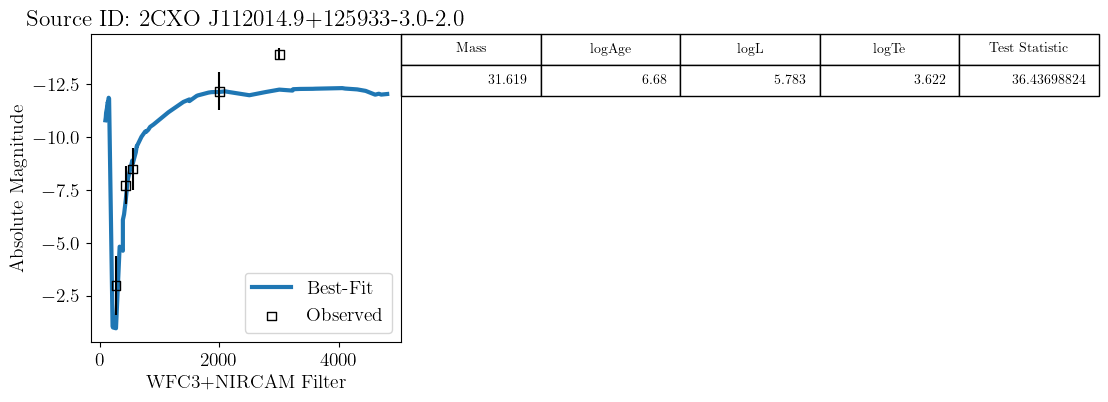

No best-fit model available for Source ID 2CXO J112015.3+125932-nan-nan.


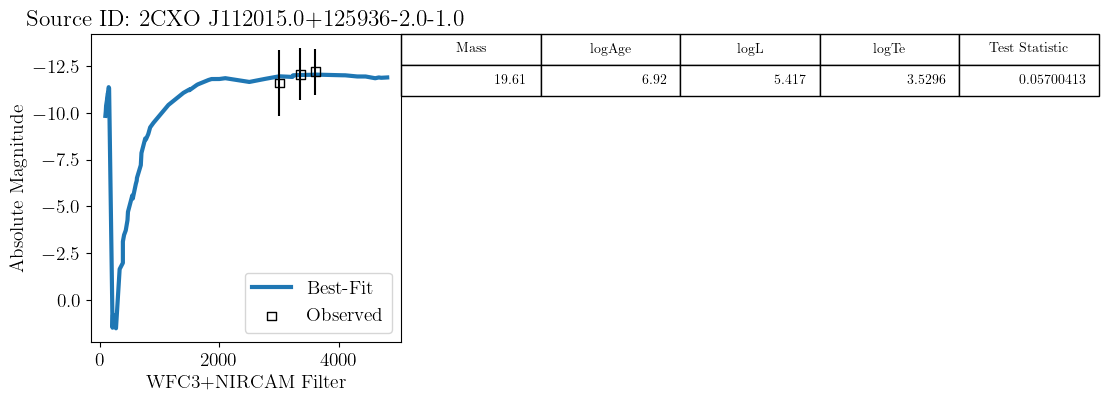

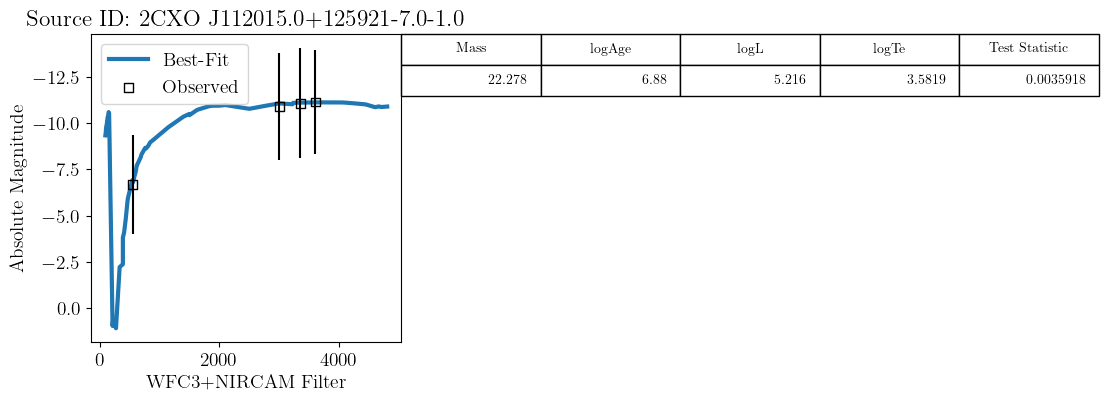

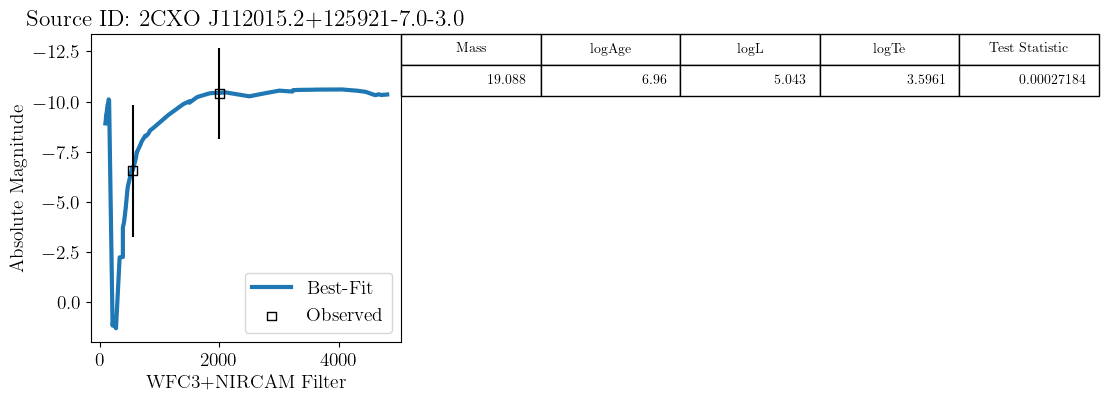

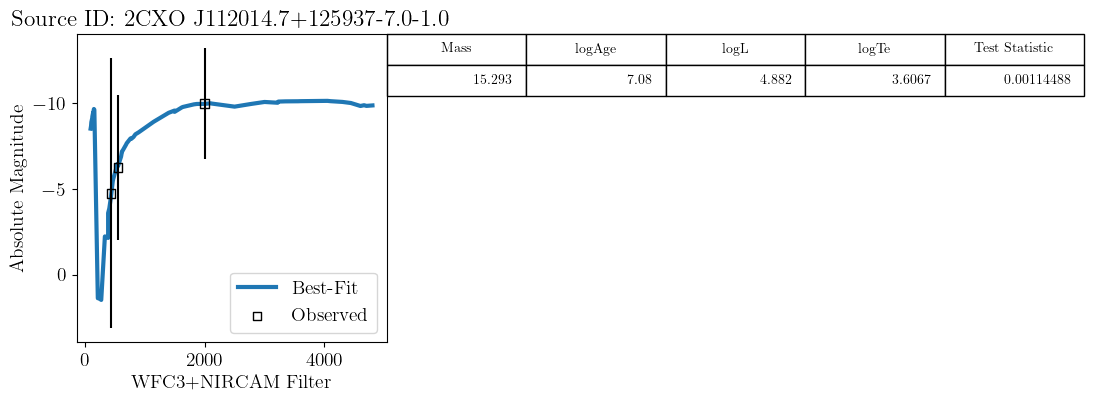

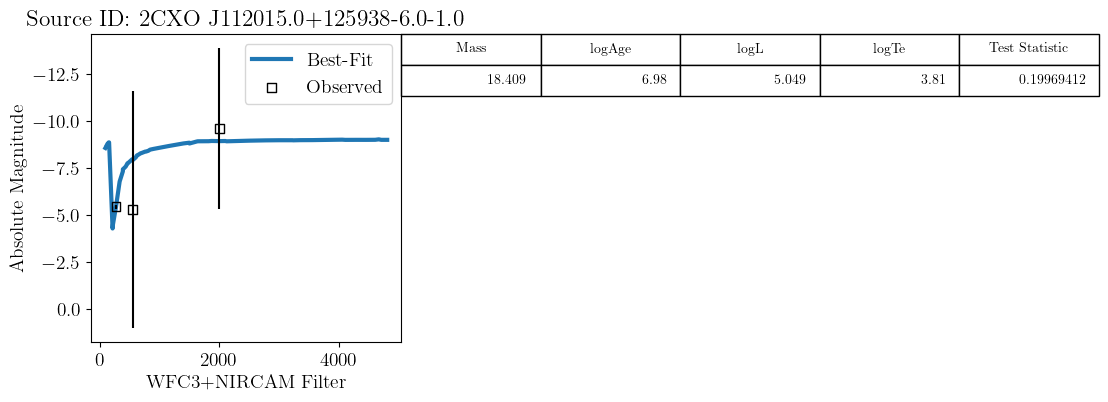

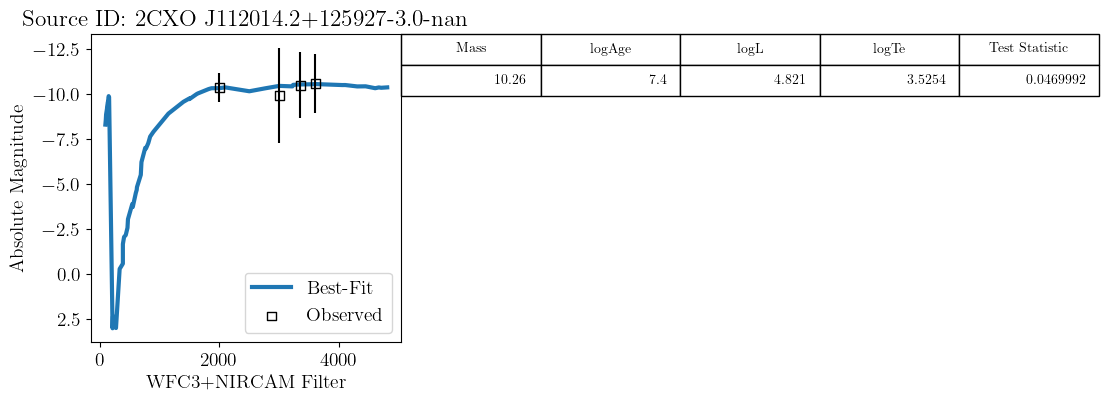

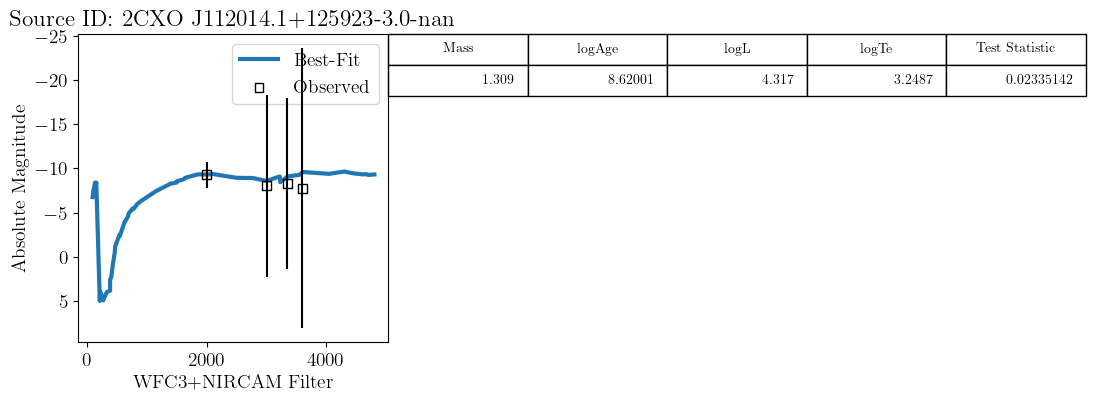

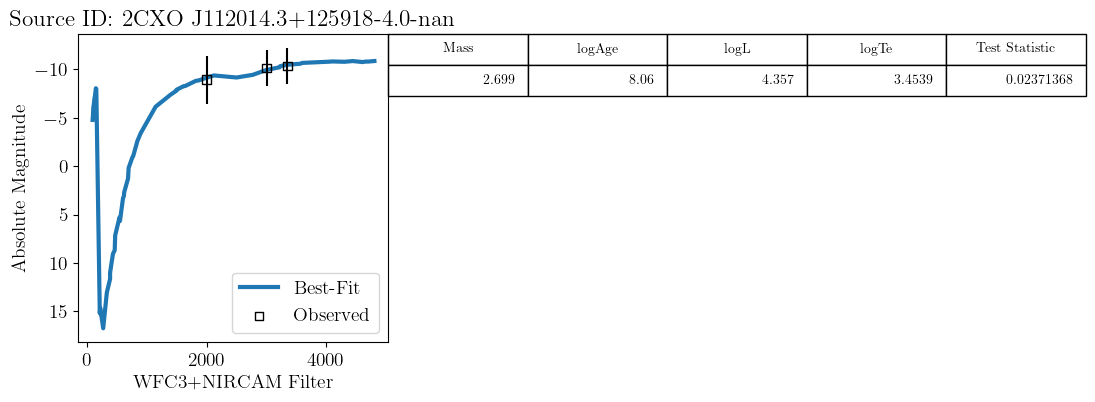

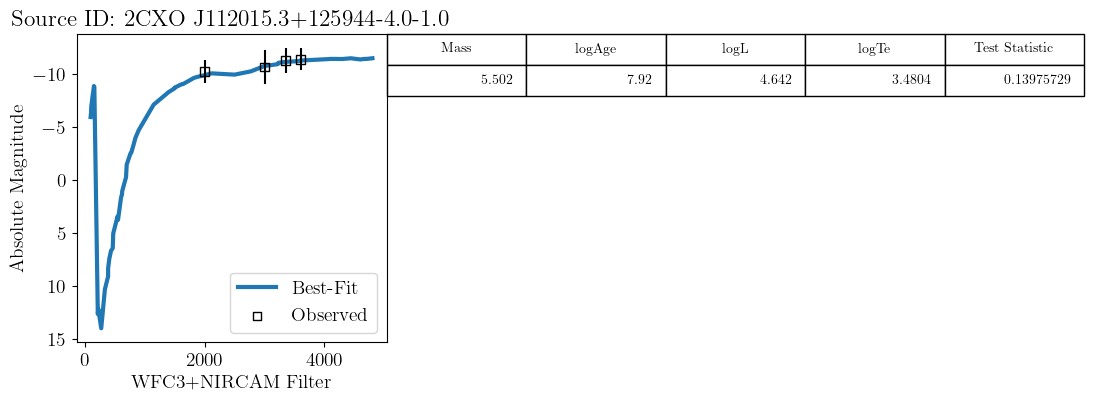

No best-fit model available for Source ID 2CXO J112014.5+125946-nan-nan.


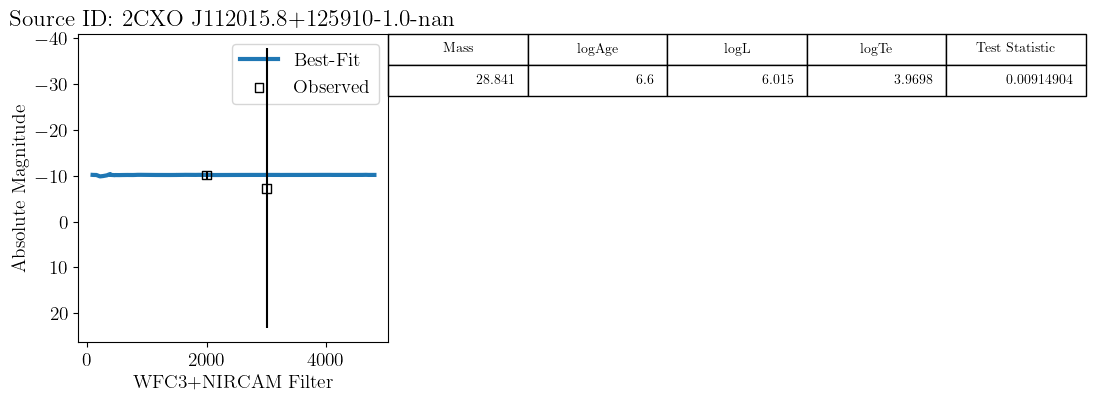

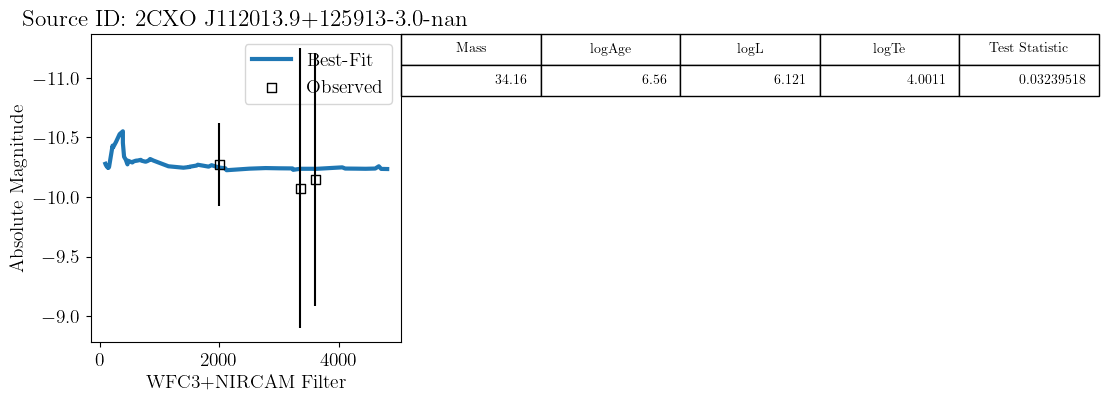

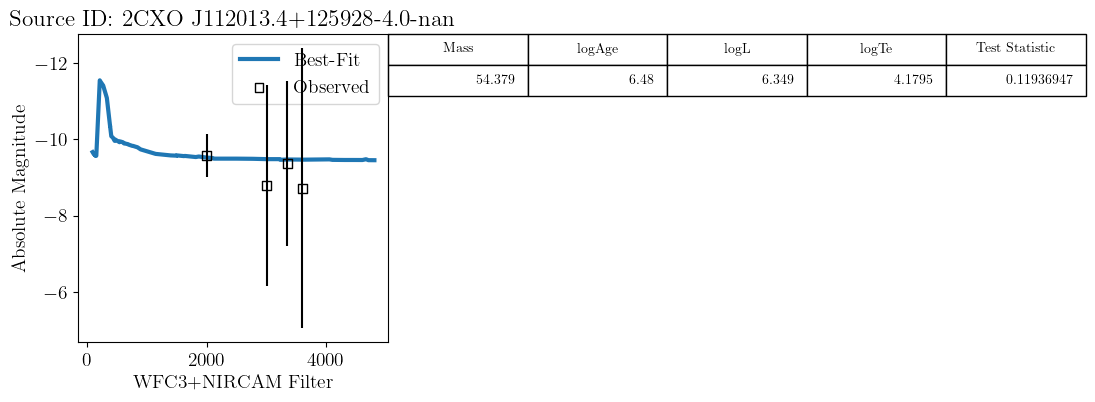

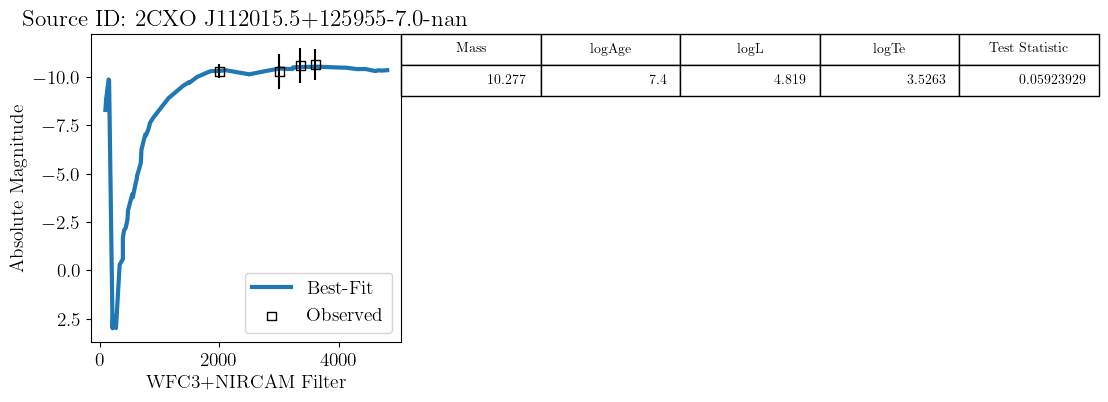

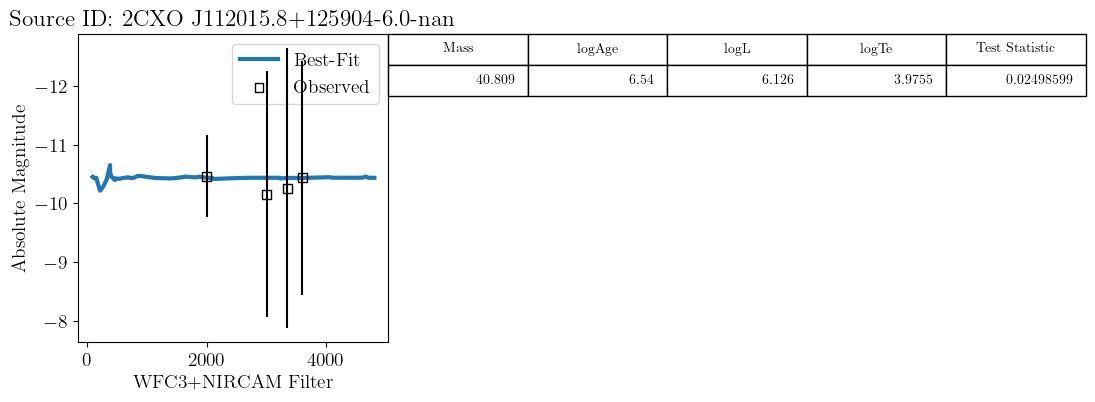

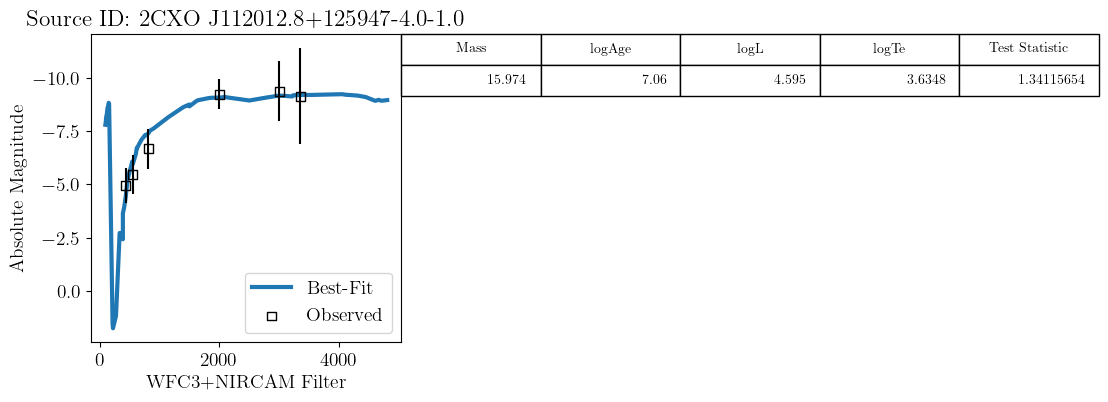

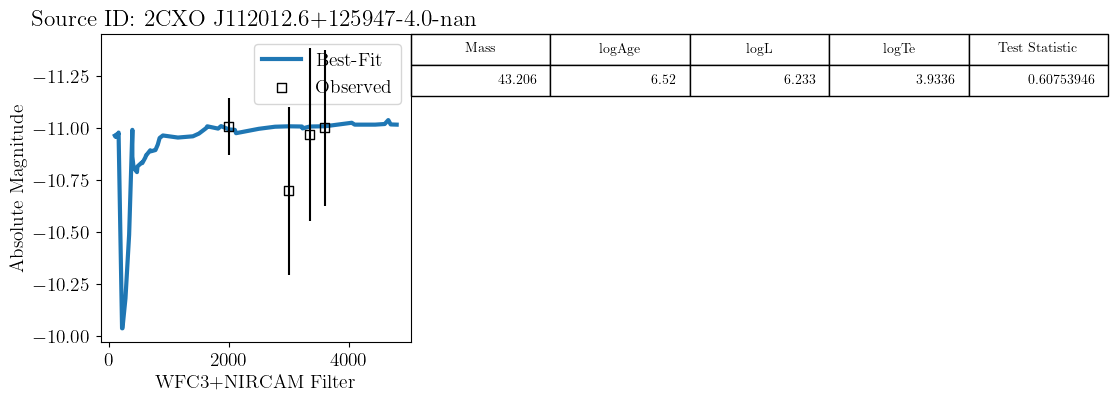

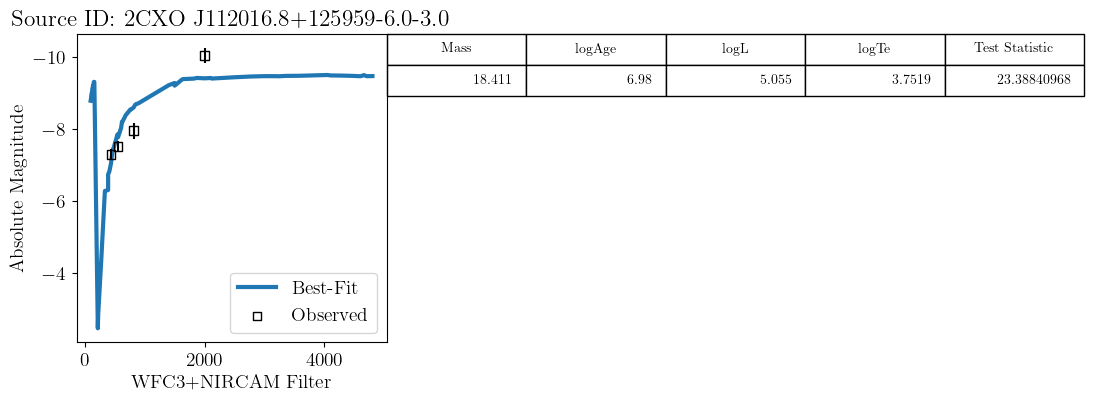

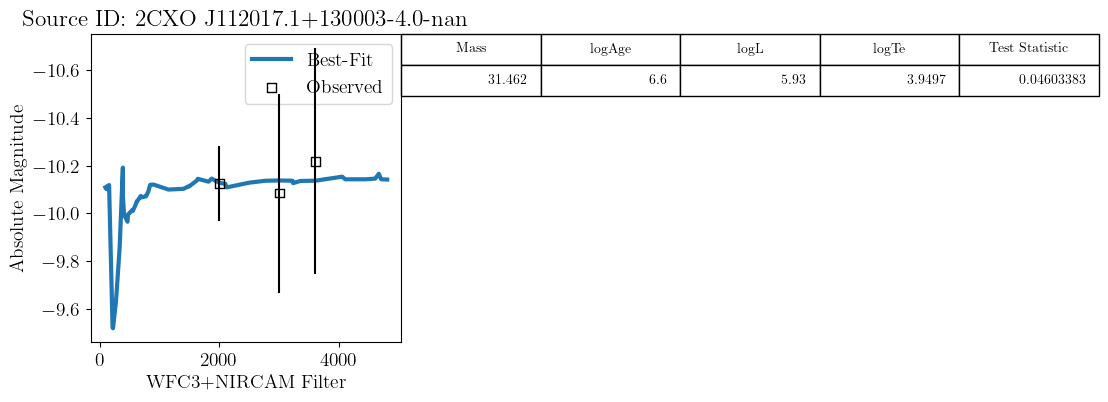

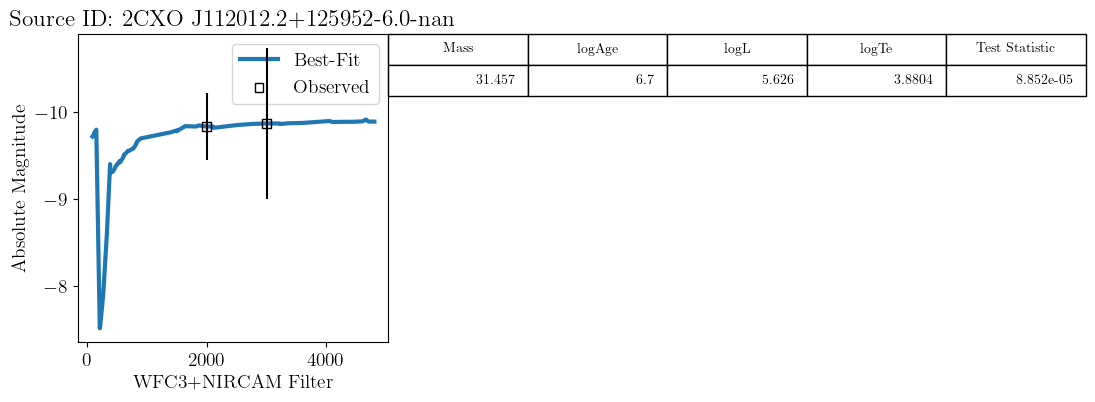

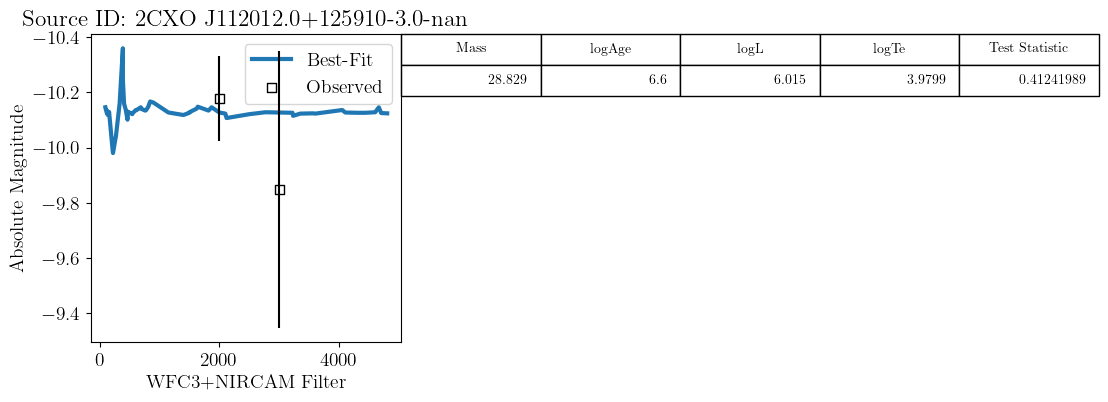

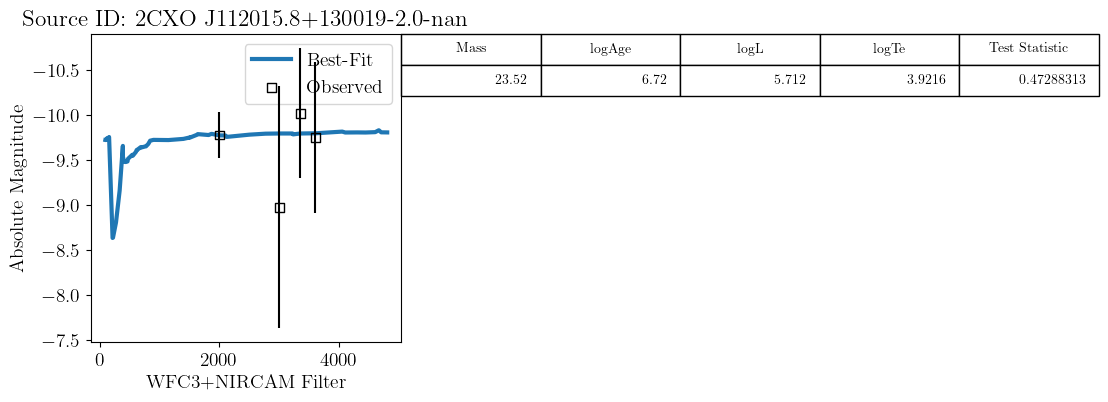

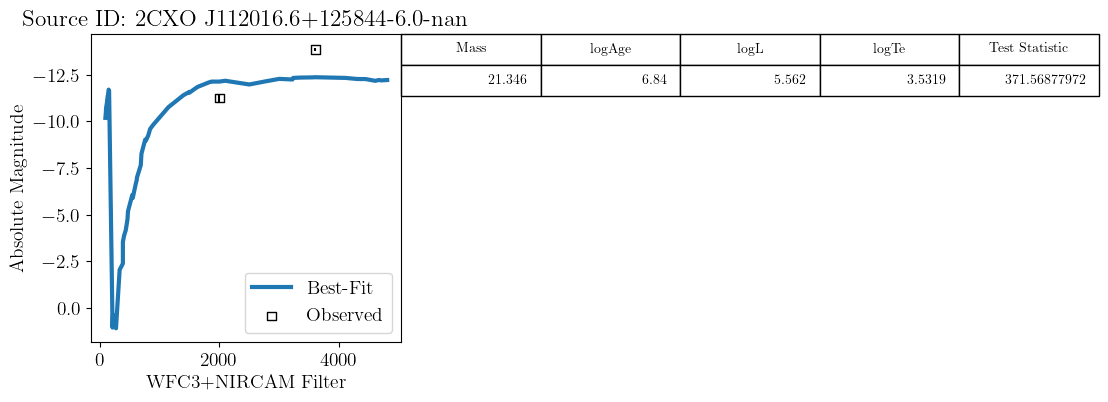

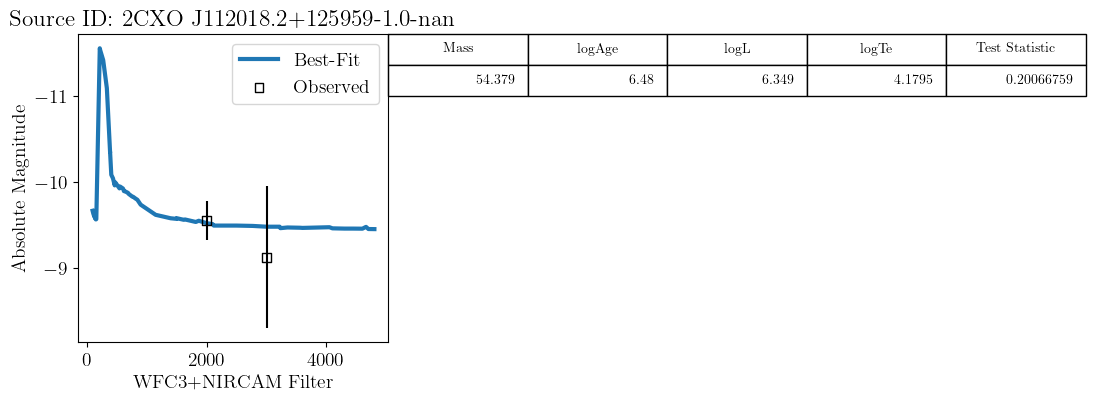

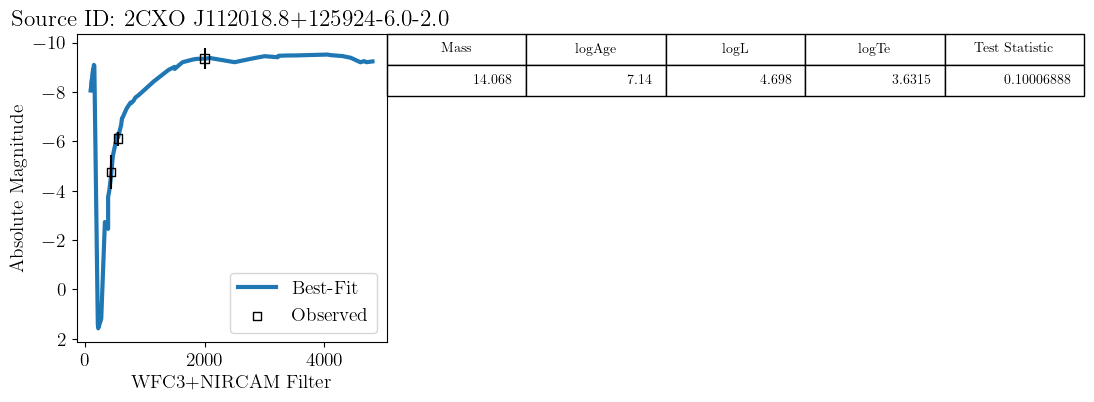

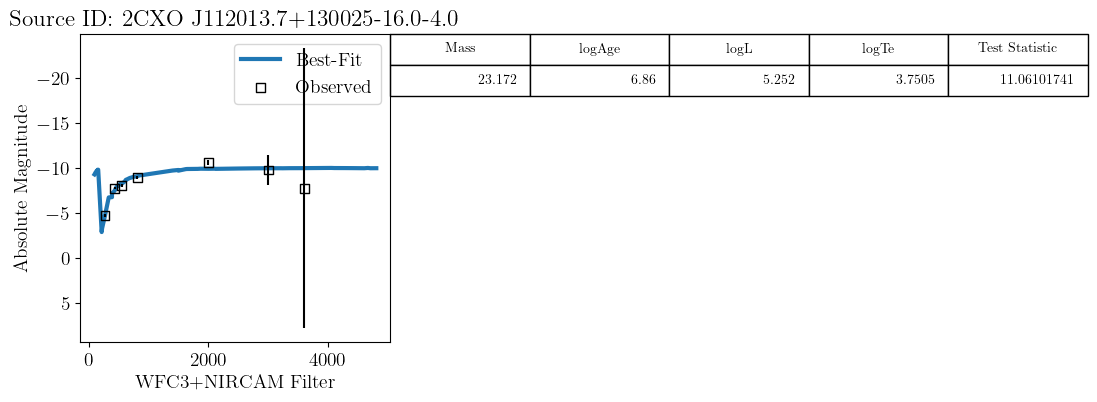

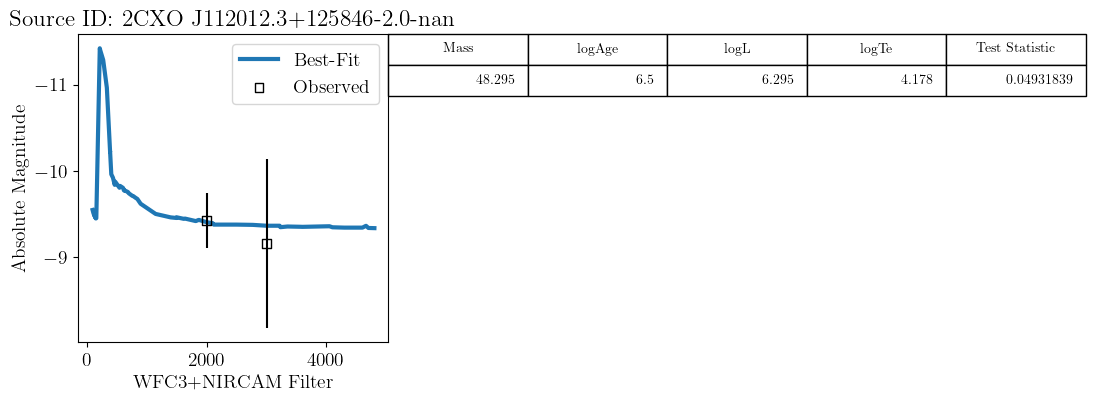

No best-fit model available for Source ID 2CXO J112011.3+125904-nan-nan.


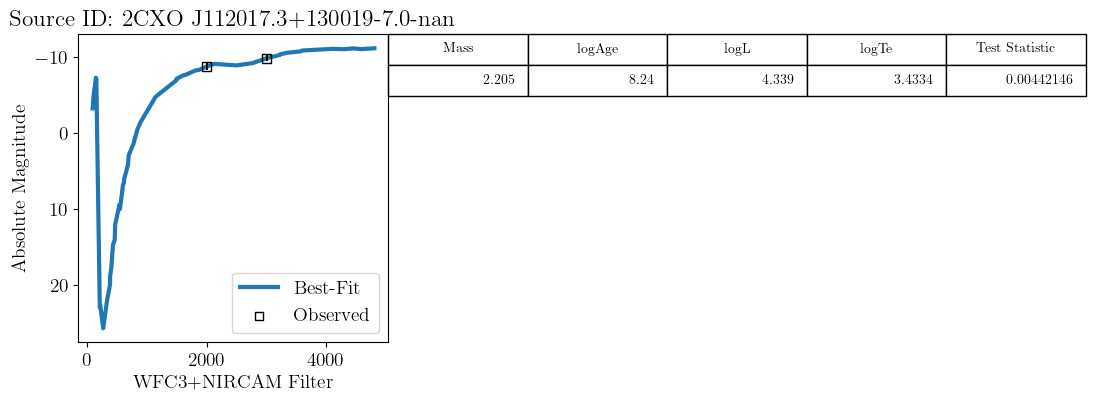

No best-fit model available for Source ID 2CXO J112017.6+130017-nan-nan.


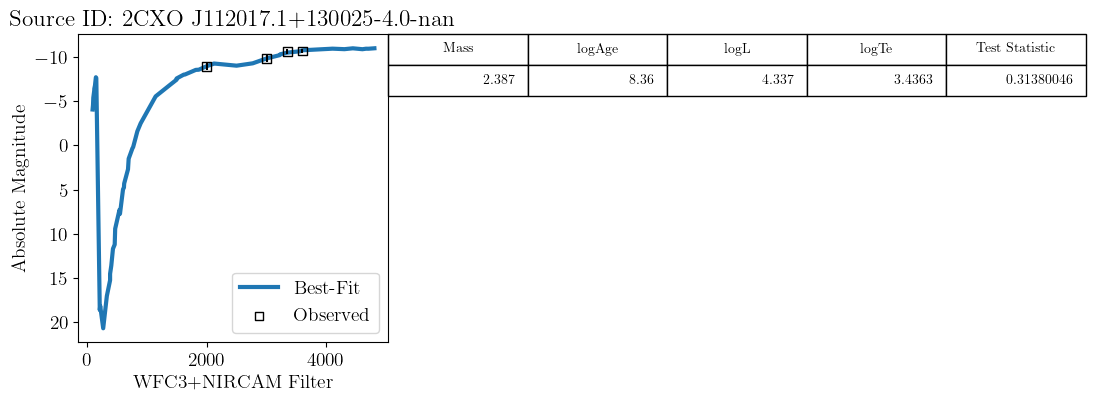

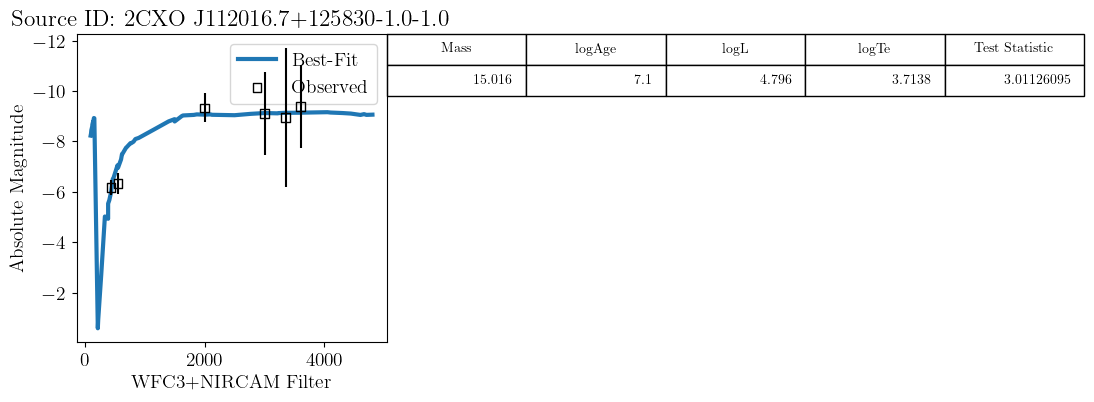

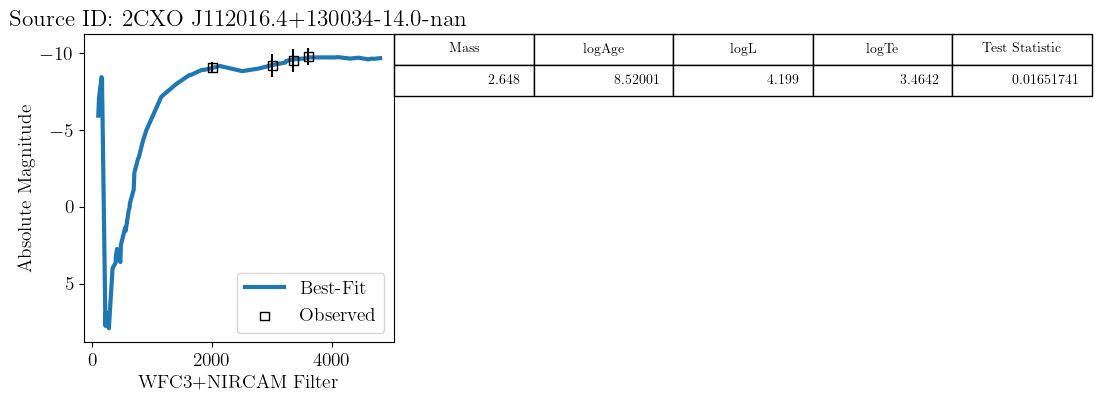

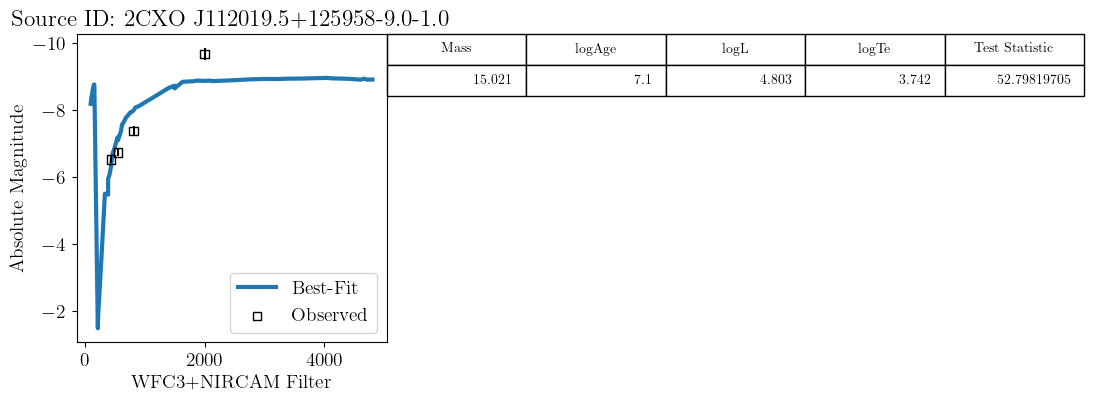

No best-fit model available for Source ID 2CXO J112018.7+130027-nan-nan.


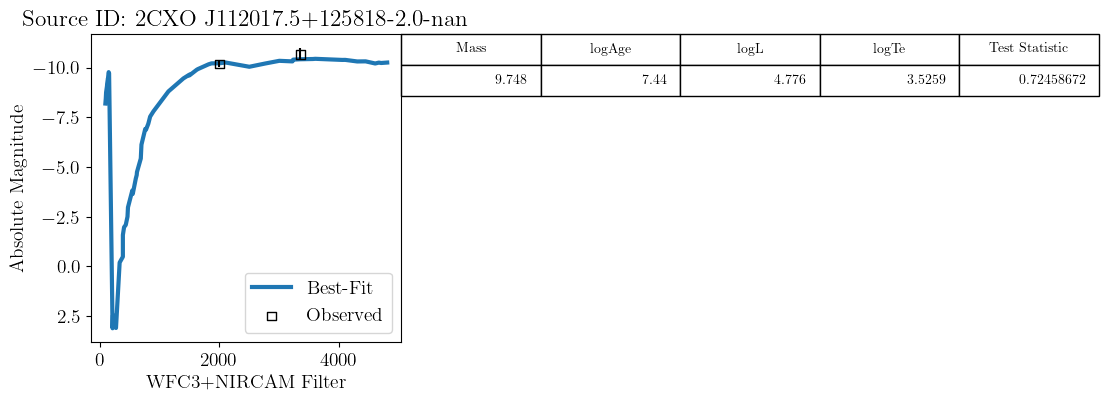

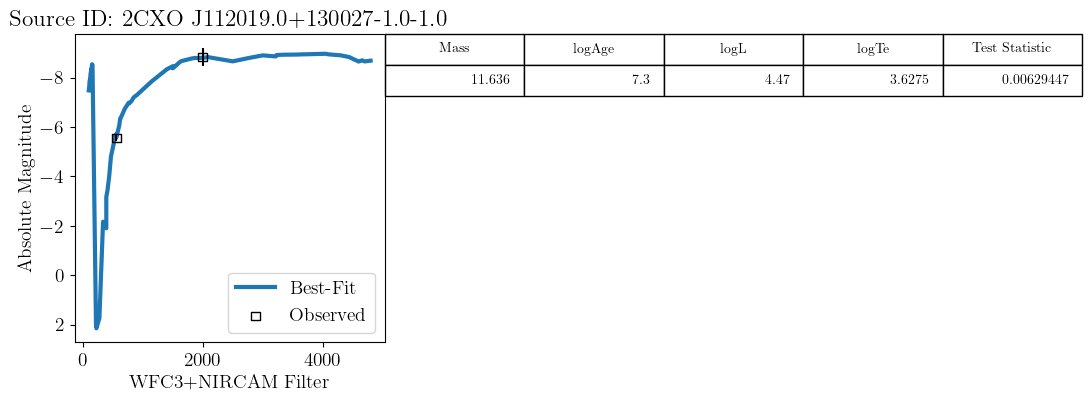

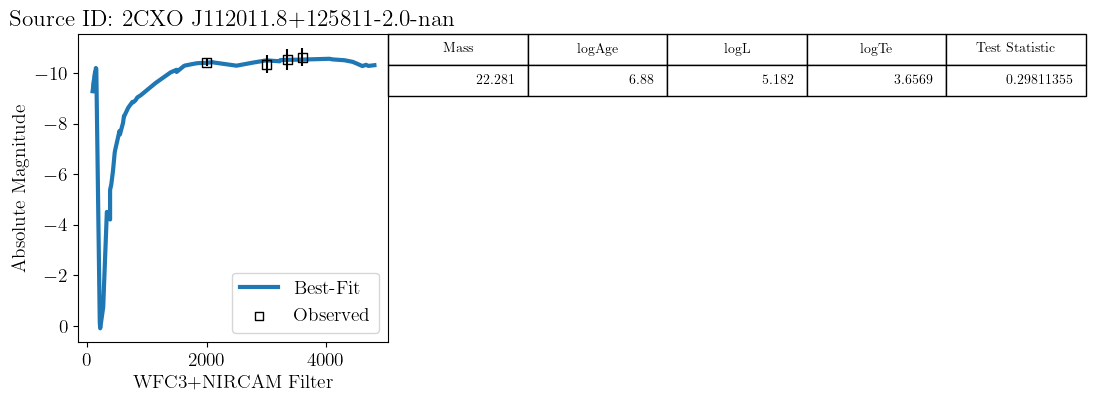

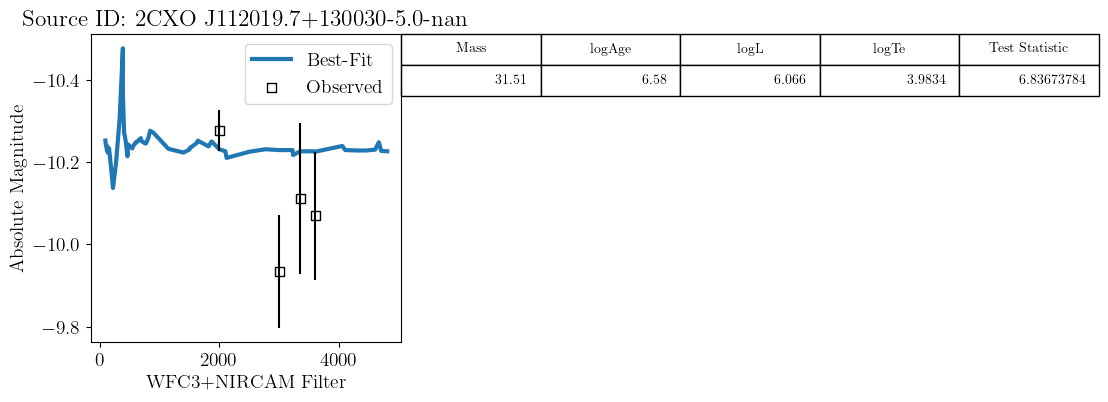

No best-fit model available for Source ID 2CXO J112019.6+125820-nan-nan.
No best-fit model available for Source ID 2CXO J112008.8+125853-nan-nan.
No best-fit model available for Source ID 2CXO J112014.9+130113-nan-nan.


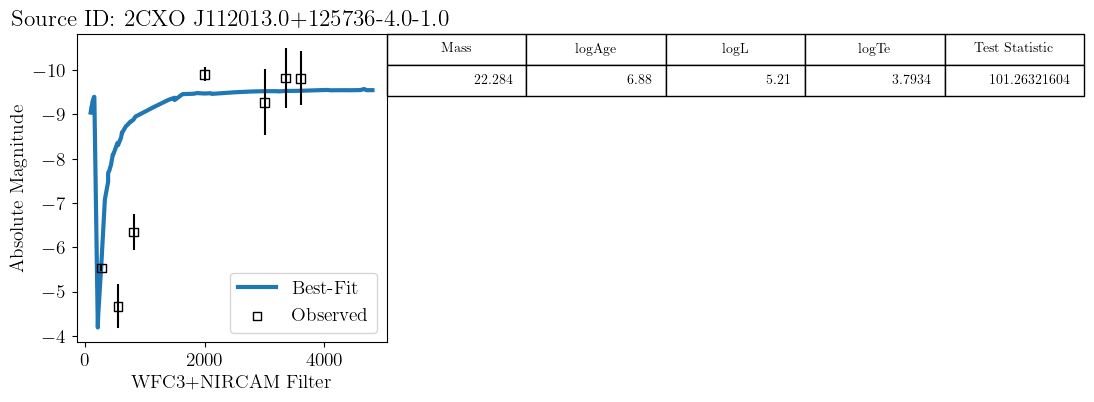

No best-fit model available for Source ID 2CXO J112015.9+125727-nan-2.0.
No best-fit model available for Source ID 2CXO J112018.9+130135-nan-nan.
No best-fit model available for Source ID 2CXO J112017.5+125644-nan-nan.


In [8]:
best_fit = FitSED(
    df=M66_xrbs,
    idheader='Auxiliary ID',
    instrument='wfc3+nircam',
    # min_models=5
)

In [9]:
# Add the useful information from SED fitting to the main df
tempfit = best_fit.copy()
tempfit = tempfit[[ 'Auxiliary ID', 'logAge', 'Mass', 'Test Statistic']]
tempfit['Stellar Age (Myr)'] = 10 ** tempfit['logAge'].values * u.yr.to(u.Myr)
tempfit = tempfit.rename(columns={'Mass': 'Star Mass (Myr)',
                                  'Test Statistic': 'SED Test Statistic'})
M66_xrbs = M66_xrbs.merge(tempfit, on='Auxiliary ID', how='left')

M66_xrbs

CSC ID      ID Class  JWST ID  HST ID     JWST RA  \
0   2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
1   2CXO J112015.3+125932  CXO005  LMXB      NaN     NaN         NaN   
2   2CXO J112015.0+125936  CXO006  HMXB      2.0     1.0  170.062808   
3   2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
4   2CXO J112015.2+125921  CXO008  HMXB      7.0     3.0  170.063489   
5   2CXO J112014.7+125937  CXO009  HMXB      7.0     1.0  170.061275   
6   2CXO J112015.0+125938  CXO010  HMXB      6.0     1.0  170.062865   
7   2CXO J112014.2+125927  CXO011  LMXB      3.0     NaN  170.059328   
8   2CXO J112014.1+125923  CXO012  LMXB      3.0     NaN  170.058784   
9   2CXO J112014.3+125918  CXO013  LMXB      4.0     NaN  170.059730   
10  2CXO J112015.3+125944  CXO014  IMXB      4.0     1.0  170.063985   
11  2CXO J112014.5+125946  CXO015  LMXB      NaN     NaN         NaN   
12  2CXO J112015.8+125910  CXO016  HMXB      1.0     NaN  170.066045   
13  2CXO J112013.9+125913  CXO017  HMXB      3.0     NaN  170.058003   
14  2CXO J112013.4+125928  CXO018  HMXB      4.0     NaN  170.055929   
15  2CXO J112015.5+125955  CXO020  HMXB      7.0     NaN  170.064734   
16  2CXO J112015.8+125904  CXO021  LMXB      6.0     NaN  170.065936   
17  2CXO J112012.8+125947  CXO022  HMXB      4.0     1.0  170.053558   
18  2CXO J112012.6+125947  CXO023  HMXB      4.0     NaN  170.052608   
19  2CXO J112016.8+125959  CXO024  HMXB      6.0     3.0  170.070216   
20  2CXO J112017.1+130003  CXO026  HMXB      4.0     NaN  170.071453   
21  2CXO J112012.2+125952  CXO027  HMXB      6.0     NaN  170.051044   
22  2CXO J112012.0+125910  CXO028  HMXB      3.0     NaN  170.050110   
23  2CXO J112015.8+130019  CXO030  HMXB      2.0     NaN  170.066076   
24  2CXO J112016.6+125844  CXO031  HMXB      6.0     NaN  170.069371   
25  2CXO J112018.2+125959  CXO032  HMXB      1.0     NaN  170.075866   
26  2CXO J112018.8+125924  CXO035  HMXB      6.0     2.0  170.078486   
27  2CXO J112013.7+130025  CXO036  HMXB     16.0     4.0  170.057402   
28  2CXO J112012.3+125846  CXO037  HMXB      2.0     NaN  170.051249   
29  2CXO J112011.3+125904  CXO038  LMXB      NaN     NaN         NaN   
30  2CXO J112017.3+130019  CXO039  LMXB      7.0     NaN  170.072467   
31  2CXO J112017.6+130017  CXO041  LMXB      NaN     NaN         NaN   
32  2CXO J112017.1+130025  CXO043  LMXB      4.0     NaN  170.071501   
33  2CXO J112016.7+125830  CXO044  HMXB      1.0     1.0  170.069948   
34  2CXO J112016.4+130034  CXO045  LMXB     14.0     NaN  170.068466   
35  2CXO J112019.5+125958  CXO047  HMXB      9.0     1.0  170.081608   
36  2CXO J112018.7+130027  CXO049  LMXB      NaN     NaN         NaN   
37  2CXO J112017.5+125818  CXO050  HMXB      2.0     NaN  170.072952   
38  2CXO J112019.0+130027  CXO051  HMXB      1.0     1.0  170.079642   
39  2CXO J112011.8+125811  CXO052  HMXB      2.0     NaN  170.049453   
40  2CXO J112019.7+130030  CXO053  HMXB      5.0     NaN  170.082249   
41  2CXO J112019.6+125820  CXO055  LMXB      NaN     NaN         NaN   
42  2CXO J112008.8+125853  CXO056  LMXB      NaN     NaN         NaN   
43  2CXO J112014.9+130113  CXO057  LMXB      NaN     NaN         NaN   
44  2CXO J112013.0+125736  CXO060  HMXB      4.0     1.0  170.054191   
45  2CXO J112015.9+125727  CXO061  HMXB      NaN     2.0         NaN   
46  2CXO J112018.9+130135  CXO067  LMXB      NaN     NaN         NaN   
47  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   

     JWST Dec  F2000W ID  F3000M ID  F3350M ID  F3600M ID       JWST X  \
0   12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
1         NaN        NaN        NaN        NaN        NaN          NaN   
2   12.993437   200852.0    46417.0    42593.0    48557.0  3048.131145   
3   12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
4   12.989460   171191.0        NaN        NaN        NaN  2970.358329   
5   12.993558   201863.0        NaN        NaN

# Find the best parent cluster

In [10]:
# Add CSC coordinates for finding the distances between clusters
M66_best = remove_unnamed(pd.read_csv(chandra_hst_dir+'M66_csc_bestrads.frame'))
temp = M66_best[['CSC ID', 'RA', 'Dec', '2Sig', '2Sig (pix)']]
temp = temp.rename(columns={
    'RA'         : 'CSC RA',
    'Dec'        : 'CSC Dec',
    '2Sig'       : '2 Sig (arcsec)',
    '2Sig (pix)' : '2 Sig (pix)'
})
M66_xrbs = M66_xrbs.merge(temp, on='CSC ID', how='left')

In [11]:
# 45.5 pc/arcsec
search_radius = 1000 / (3600 * 45.4)
print(f"Using search radius: {search_radius} deg")

Using search radius: 0.006118453255017132 deg


In [12]:
FindUnique(M66_xrbs, header='CSC ID')

CSC ID      ID Class  JWST ID  HST ID     JWST RA  \
0   2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
1   2CXO J112015.3+125932  CXO005  LMXB      NaN     NaN         NaN   
2   2CXO J112015.0+125936  CXO006  HMXB      2.0     1.0  170.062808   
3   2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
4   2CXO J112015.2+125921  CXO008  HMXB      7.0     3.0  170.063489   
5   2CXO J112014.7+125937  CXO009  HMXB      7.0     1.0  170.061275   
6   2CXO J112015.0+125938  CXO010  HMXB      6.0     1.0  170.062865   
7   2CXO J112014.2+125927  CXO011  LMXB      3.0     NaN  170.059328   
8   2CXO J112014.1+125923  CXO012  LMXB      3.0     NaN  170.058784   
9   2CXO J112014.3+125918  CXO013  LMXB      4.0     NaN  170.059730   
10  2CXO J112015.3+125944  CXO014  IMXB      4.0     1.0  170.063985   
11  2CXO J112014.5+125946  CXO015  LMXB      NaN     NaN         NaN   
12  2CXO J112015.8+125910  CXO016  HMXB      1.0     NaN  170.066045   
13  2CXO J112013.9+125913  CXO017  HMXB      3.0     NaN  170.058003   
14  2CXO J112013.4+125928  CXO018  HMXB      4.0     NaN  170.055929   
15  2CXO J112015.5+125955  CXO020  HMXB      7.0     NaN  170.064734   
16  2CXO J112015.8+125904  CXO021  LMXB      6.0     NaN  170.065936   
17  2CXO J112012.8+125947  CXO022  HMXB      4.0     1.0  170.053558   
18  2CXO J112012.6+125947  CXO023  HMXB      4.0     NaN  170.052608   
19  2CXO J112016.8+125959  CXO024  HMXB      6.0     3.0  170.070216   
20  2CXO J112017.1+130003  CXO026  HMXB      4.0     NaN  170.071453   
21  2CXO J112012.2+125952  CXO027  HMXB      6.0     NaN  170.051044   
22  2CXO J112012.0+125910  CXO028  HMXB      3.0     NaN  170.050110   
23  2CXO J112015.8+130019  CXO030  HMXB      2.0     NaN  170.066076   
24  2CXO J112016.6+125844  CXO031  HMXB      6.0     NaN  170.069371   
25  2CXO J112018.2+125959  CXO032  HMXB      1.0     NaN  170.075866   
26  2CXO J112018.8+125924  CXO035  HMXB      6.0     2.0  170.078486   
27  2CXO J112013.7+130025  CXO036  HMXB     16.0     4.0  170.057402   
28  2CXO J112012.3+125846  CXO037  HMXB      2.0     NaN  170.051249   
29  2CXO J112011.3+125904  CXO038  LMXB      NaN     NaN         NaN   
30  2CXO J112017.3+130019  CXO039  LMXB      7.0     NaN  170.072467   
31  2CXO J112017.6+130017  CXO041  LMXB      NaN     NaN         NaN   
32  2CXO J112017.1+130025  CXO043  LMXB      4.0     NaN  170.071501   
33  2CXO J112016.7+125830  CXO044  HMXB      1.0     1.0  170.069948   
34  2CXO J112016.4+130034  CXO045  LMXB     14.0     NaN  170.068466   
35  2CXO J112019.5+125958  CXO047  HMXB      9.0     1.0  170.081608   
36  2CXO J112018.7+130027  CXO049  LMXB      NaN     NaN         NaN   
37  2CXO J112017.5+125818  CXO050  HMXB      2.0     NaN  170.072952   
38  2CXO J112019.0+130027  CXO051  HMXB      1.0     1.0  170.079642   
39  2CXO J112011.8+125811  CXO052  HMXB      2.0     NaN  170.049453   
40  2CXO J112019.7+130030  CXO053  HMXB      5.0     NaN  170.082249   
41  2CXO J112019.6+125820  CXO055  LMXB      NaN     NaN         NaN   
42  2CXO J112008.8+125853  CXO056  LMXB      NaN     NaN         NaN   
43  2CXO J112014.9+130113  CXO057  LMXB      NaN     NaN         NaN   
44  2CXO J112013.0+125736  CXO060  HMXB      4.0     1.0  170.054191   
45  2CXO J112015.9+125727  CXO061  HMXB      NaN     2.0         NaN   
46  2CXO J112018.9+130135  CXO067  LMXB      NaN     NaN         NaN   
47  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   

     JWST Dec  F2000W ID  F3000M ID  F3350M ID  F3600M ID       JWST X  \
0   12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
1         NaN        NaN        NaN        NaN        NaN          NaN   
2   12.993437   200852.0    46417.0    42593.0    48557.0  3048.131145   
3   12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
4   12.989460   171191.0        NaN        NaN        NaN  2970.358329   
5   12.993558   201863.0        NaN        NaN

In [13]:
region = M66_dir+'phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg'
catalog = 'Cluster'
search_radius = search_radius

distances = calculate_distance(
    df=M66_xrbs,
    regions=region,
    catalogs=catalog,
    imagefilename=f555w,
    search_radius=search_radius,
    coordsys='fk5',
    coordheads=['CSC RA', 'CSC Dec'],
    # instrument is used for using the FWHM. I am using WFC3's fwhm for all my work
    instrument='wfc3',
    sourceid='Auxiliary ID'
)
distances

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...
Crossrefing done...
Done! Calculated Distances...


CSC RA    CSC Dec                   Auxiliary ID Cluster ID  \
0     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       6740   
1     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       6788   
2     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       6969   
3     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       7009   
4     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       7020   
...          ...        ...                            ...        ...   
4169  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        476   
4170  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        489   
4171  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        515   
4172  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        527   
4173  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        543   

                     CSC ID      ID Class JWST ID HST ID     JWST RA  \
0     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
1     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
2     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
3     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
4     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
...                     ...     ...   ...     ...    ...         ...   
4169  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   
4170  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   
4171  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   
4172  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   
4173  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   

       JWST Dec F2000W ID F3000M ID F3350M ID F3600M ID       JWST X  \
0     12.992623  194908.0   45185.0       nan       nan  3105.251503   
1     12.992623  194908.0   45185.0       nan       nan  3105.251503   
2     12.992623  194908.0   45185.0       nan       nan  3105.251503   
3     12.992623  194908.0   45185.0       nan       nan  3105.251503   
4     12.992623  194908.0   45185.0       nan       nan  3105.251503   
...         ...       ...       ...       ...       ...          ...   
4169        nan       nan       nan       nan       nan          nan   
4170        nan       nan       nan       nan       nan          nan   
4171        nan       nan       nan       nan       nan          nan   
4172        nan       nan       nan       nan       nan          nan   
4173        nan       nan       nan       nan       nan          nan   

           JWST Y        HST X        HST Y F555W ID  F275W ID F336W ID  \
0     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
1     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
2     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
3     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
4     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
...           ...          ...          ...      ...       ...      ...   
4169          nan          nan          nan      nan       nan      nan   
4170          nan          nan          nan      nan       nan      nan   
4171          nan          nan          nan      nan       nan      nan   
4172          nan          nan          nan      nan       nan      nan   
4173          nan          nan          nan      nan       nan      nan   

     F438W ID F814W ID      HST RA    HST Dec     F2000W F2000W Err  \
0     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
1     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
2     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
3     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
4     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
...       ...      ...         ...        ...        ...        ...   
4169 

### Gather all the cluster data from Phangs catalog

In [14]:
clustercat = pd.read_csv(M66_dir+'phangsclass12clustercandidatecatalogswithsizes/ngc3627_class12_w_sizes.csv')

In [15]:
clustercat = pd.read_csv(M66_dir+'phangsclass12clustercandidatecatalogswithsizes/ngc3627_class12_w_sizes.csv')

# PHANGS provide their coordinates in ICRS. Convert to FK5
ra, dec = clustercat['PHANGS_RA'].values, clustercat['PHANGS_DEC'].values
fk5 = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs').transform_to(FK5)
ra_fk5, dec_fk5 = fk5.ra.deg, fk5.dec.deg
clustercat['RA'] = ra
clustercat['Dec'] = dec

In [16]:
clusterframe = clustercat.copy()
# Rename headers to make everything consistent
clusterframe = clusterframe.rename(columns={
    'ID_PHANGS_CLUSTERS'       : 'Cluster ID',
    # 'RA': 'Cluster RA', 'Dec' : 'Cluster Dec',
    'PHANGS_CI'                : 'Cluster CI',
    'PHANGS_AGE_MINCHISQ'      : 'Cluster Age (Myr)',
    'PHANGS_AGE_MINCHISQ_ERR'  : 'Cluster Age Err (Myr)',
    'PHANGS_MASS_MINCHISQ'     : 'Cluster Mass (M_sun)',
    'PHANGS_MASS_MINCHISQ_ERR' : 'Cluster Mass Err (M_sun)',
    'PHANGS_EBV_MINCHISQ'      : 'Cluster EBV',
    'PHANGS_EBV_MINCHISQ_ERR'  : 'Cluster EBV Err',
    'PHANGS_REDUCED_MINCHISQ'  : 'Cluster Test Statistic',
    'fwhm'                     : 'Cluster FWHM',
    'r_eff(pix)'               : 'Cluster Radius Eff (pix)',
    'r_eff(arcsec)'            : 'Cluster Radius Eff (arcsec)',
    'r_eff(pc)'                : 'Cluster Radius Eff (pc)', 
    'PHANGS_F275W_VEGA_TOT'    : 'F275W',
    'PHANGS_F275W_VEGA_TOT_ERR': 'F275W Err',
    'PHANGS_F336W_VEGA_TOT'    : 'F336W',
    'PHANGS_F336W_VEGA_TOT_ERR': 'F336W Err', 
    'PHANGS_F438W_VEGA_TOT'    : 'F438W',
    'PHANGS_F438W_VEGA_TOT_ERR': 'F438W Err', 
    'PHANGS_F555W_VEGA_TOT'    : 'F555W',
    'PHANGS_F555W_VEGA_TOT_ERR': 'F555W Err',
    'PHANGS_F814W_VEGA_TOT'    : 'F814W',
    'PHANGS_F814W_VEGA_TOT_ERR': 'F814W Err'
})

In [17]:
clustercat = pd.read_csv(M66_dir+'phangsclass12clustercandidatecatalogswithsizes/ngc3627_class12_w_sizes.csv')

# PHANGS provide their coordinates in ICRS. Convert to FK5
ra, dec = clustercat['PHANGS_RA'].values, clustercat['PHANGS_DEC'].values
fk5 = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs').transform_to(FK5)
ra_fk5, dec_fk5 = fk5.ra.deg, fk5.dec.deg
clustercat['RA'] = ra
clustercat['Dec'] = dec
 
# add the cluster masses, ages and info to the main dataframe
clustercat = clustercat[[
    # 'RA', 'Dec',
    'ID_PHANGS_CLUSTERS',
    'PHANGS_CI', 
    'PHANGS_AGE_MINCHISQ',
    'PHANGS_AGE_MINCHISQ_ERR', 
    'PHANGS_MASS_MINCHISQ',
    'PHANGS_MASS_MINCHISQ_ERR', 
    'PHANGS_EBV_MINCHISQ',
    'PHANGS_EBV_MINCHISQ_ERR', 
    'PHANGS_REDUCED_MINCHISQ',
    'fwhm', 'r_eff(pix)', 
    'r_eff(arcsec)', 'r_eff(pc)'
]] 

# Rename headers to make everything consistent
clustercat = clustercat.rename(columns={
    'ID_PHANGS_CLUSTERS'       : 'Cluster ID',
    # 'RA': 'Cluster RA', 'Dec' : 'Cluster Dec',
    'PHANGS_CI'                : 'Cluster CI',
    'PHANGS_AGE_MINCHISQ'      : 'Cluster Age (Myr)',
    'PHANGS_AGE_MINCHISQ_ERR'  : 'Cluster Age Err (Myr)',
    'PHANGS_MASS_MINCHISQ'     : 'Cluster Mass (M_sun)',
    'PHANGS_MASS_MINCHISQ_ERR' : 'Cluster Mass Err (M_sun)',
    'PHANGS_EBV_MINCHISQ'      : 'Cluster EBV',
    'PHANGS_EBV_MINCHISQ_ERR'  : 'Cluster EBV Err',
    'PHANGS_REDUCED_MINCHISQ'  : 'Cluster Test Statistic',
    'fwhm'                     : 'Cluster FWHM',
    'r_eff(pix)'               : 'Cluster Radius Eff (pix)',
    'r_eff(arcsec)'            : 'Cluster Radius Eff (arcsec)',
    'r_eff(pc)'                : 'Cluster Radius Eff (pc)'
})

clustercat

Cluster ID  Cluster CI  Cluster Age (Myr)  Cluster Age Err (Myr)  \
0             14    1.440696                1.0                    1.0   
1             46    1.652545             2440.0                 1412.0   
2             55    1.554934              182.0                   28.0   
3             68    1.723422              210.0                    0.0   
4             90    1.869660              500.0                  151.0   
...          ...         ...                ...                    ...   
2707       10668    1.837798             1028.0                  625.0   
2708       10670    1.626464                5.0                    2.0   
2709       10671    1.739450              118.0                  347.0   
2710       10672    1.906561              667.0                  557.0   
2711       10673    1.693554              226.0                  239.0   

      Cluster Mass (M_sun)  Cluster Mass Err (M_sun)  Cluster EBV  \
0              8719.629994               2694.287932         0.31   
1            435789.158150             132243.181503         0.15   
2             17467.385090               2360.828542         0.00   
3             80145.110419               9281.609214         0.01   
4             55569.664342               1130.107884         0.00   
...                    ...                       ...          ...   
2707          15243.314080               6490.579020         0.04   
2708           8629.588626               2126.057035         0.92   
2709          11339.952560               1688.263020         0.35   
2710          15856.958755               2760.559736         0.08   
2711          34778.999221              10905.424521         0.38   

      Cluster EBV Err  Cluster Test Statistic  Cluster FWHM  \
0                0.04                0.155719          0.48   
1                0.17                0.675790          1.32   
2                0.01                0.798219          0.96   
3                0.03                0.181574          1.55   
4                0.10                0.702583          2.50   
...               ...                     ...           ...   
2707             0.37                0.141133          1.32   
2708             0.13                0.060492          1.18   
2709             0.24                0.026141          1.55   
2710             0.33                0.046162          3.09   
2711             0.07                0.834060          1.55   

      Cluster Radius Eff (pix)  Cluster Radius Eff (arcsec)  \
0                       0.7104                     0.028416   
1                       1.9536                     0.078144   
2                       1.4208                     0.056832   
3                       2.2940                     0.091760   
4                       3.7000                     0.148000   
...                        ...                          ...   
2707                    1.9536                     0.078144   
2708                    1.7464                     0.069856   
2709                    2.2940                     0.091760   
2710                    4.5732                     0.182928   
2711                    2.2940                     0.091760   

      Cluster Radius Eff (pc)  
0                    1.556879  
1                    4.281416  
2                    3.113757  
3                    5.027420  
4                    8.108742  
...                       ...  
2707                 4.281416  
2708                 3.827326  
2709                 5.027420  
2710                10.022406  
2711                 5.027420  

[2712 rows x 13 columns]

In [18]:
# merge cluster info with the main df
distances = distances.merge(clustercat, on=['Cluster ID'], how='left')
distances

CSC RA    CSC Dec                   Auxiliary ID Cluster ID  \
0     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       6740   
1     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       6788   
2     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       6969   
3     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       7009   
4     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0       7020   
...          ...        ...                            ...        ...   
4169  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        476   
4170  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        489   
4171  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        515   
4172  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        527   
4173  170.072915  12.945547  2CXO J112017.5+125644-nan-nan        543   

                     CSC ID      ID Class JWST ID HST ID     JWST RA  \
0     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
1     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
2     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
3     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
4     2CXO J112014.9+125933  CXO003  HMXB     3.0    2.0  170.062307   
...                     ...     ...   ...     ...    ...         ...   
4169  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   
4170  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   
4171  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   
4172  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   
4173  2CXO J112017.5+125644  CXO072  LMXB     nan    nan         nan   

       JWST Dec F2000W ID F3000M ID F3350M ID F3600M ID       JWST X  \
0     12.992623  194908.0   45185.0       nan       nan  3105.251503   
1     12.992623  194908.0   45185.0       nan       nan  3105.251503   
2     12.992623  194908.0   45185.0       nan       nan  3105.251503   
3     12.992623  194908.0   45185.0       nan       nan  3105.251503   
4     12.992623  194908.0   45185.0       nan       nan  3105.251503   
...         ...       ...       ...       ...       ...          ...   
4169        nan       nan       nan       nan       nan          nan   
4170        nan       nan       nan       nan       nan          nan   
4171        nan       nan       nan       nan       nan          nan   
4172        nan       nan       nan       nan       nan          nan   
4173        nan       nan       nan       nan       nan          nan   

           JWST Y        HST X        HST Y F555W ID  F275W ID F336W ID  \
0     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
1     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
2     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
3     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
4     5907.752641  3743.843919  5833.507868  19247.0  130956.0      nan   
...           ...          ...          ...      ...       ...      ...   
4169          nan          nan          nan      nan       nan      nan   
4170          nan          nan          nan      nan       nan      nan   
4171          nan          nan          nan      nan       nan      nan   
4172          nan          nan          nan      nan       nan      nan   
4173          nan          nan          nan      nan       nan      nan   

     F438W ID F814W ID      HST RA    HST Dec     F2000W F2000W Err  \
0     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
1     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
2     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
3     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
4     36055.0      nan  170.062292  12.992626 -12.159049  -0.904646   
...       ...      ...         ...        ...        ...        ...   
4169 

### Select the best parent cluster

I am still testing out an algorithm to select the best parent-star cluster. Currently, I have two algorithms, one with the standard weighted least squares fitting, but we are afraid that it might giving a little too much weightage to the errors in the age. The PHANGS collaboration have exceptionally high error in the cluster ages, which completely blotches some parts of my analysis. 

I have designed another algorithm within the same code that gives a lesser weightage to the errors, while placing a higher importance for the distances between the XRB and the cluster. Perhaps that might be a better way to judge this. 

In [19]:
dists = distances.copy()
dists.to_csv('/Users/undergradstudent/Downloads/temp.csv')
dists = remove_unnamed(pd.read_csv('/Users/undergradstudent/Downloads/temp.csv'))

In [20]:
potential_clusters = find_parent_cluster(df=dists, fit_type='updated wls',
                                     star_age_head='Stellar Age (Myr)')
potential_clusters

CSC RA    CSC Dec                   Auxiliary ID  Cluster ID  \
0     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        6740   
1     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        6788   
2     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        6969   
3     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        7009   
4     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        7020   
...          ...        ...                            ...         ...   
4169  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         476   
4170  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         489   
4171  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         515   
4172  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         527   
4173  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         543   

                     CSC ID      ID Class  JWST ID  HST ID     JWST RA  \
0     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
1     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
2     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
3     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
4     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
...                     ...     ...   ...      ...     ...         ...   
4169  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   
4170  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   
4171  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   
4172  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   
4173  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   

       JWST Dec  F2000W ID  F3000M ID  F3350M ID  F3600M ID       JWST X  \
0     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
1     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
2     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
3     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
4     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
...         ...        ...        ...        ...        ...          ...   
4169        NaN        NaN        NaN        NaN        NaN          NaN   
4170        NaN        NaN        NaN        NaN        NaN          NaN   
4171        NaN        NaN        NaN        NaN        NaN          NaN   
4172        NaN        NaN        NaN        NaN        NaN          NaN   
4173        NaN        NaN        NaN        NaN        NaN          NaN   

           JWST Y        HST X        HST Y  F555W ID  F275W ID  F336W ID  \
0     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
1     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
2     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
3     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
4     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
...           ...          ...          ...       ...       ...       ...   
4169          NaN          NaN          NaN       NaN       NaN       NaN   
4170          NaN          NaN          NaN       NaN       NaN       NaN   
4171          NaN          NaN          NaN       NaN       NaN       NaN   
4172          NaN          NaN          NaN       NaN       NaN       NaN   
4173          NaN          NaN          NaN       NaN       NaN       NaN   

      F438W ID  F814W ID      HST RA    HST Dec     F2000W  F2000W Err  \
0      36055.0       NaN  170.062292  12.992626 -12.159049   -0.904646   
1      36055.0       NaN  170.062292  12.992626 -12.159049   -0.904646   
2      36055.0       NaN  170.062292  12.992626 -12.159049   -0.904646   
3      36055.0       NaN  170.062292  12.992626 -12.159049   -0.904646   
4      36055.0       NaN

In [21]:
candidate_clusters = find_parent_cluster(df=dists, fit_type='wls',
                                     star_age_head='Stellar Age (Myr)')
candidate_clusters

CSC RA    CSC Dec                   Auxiliary ID  Cluster ID  \
0     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        6740   
1     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        6788   
2     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        6969   
3     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        7009   
4     170.062259  12.992633  2CXO J112014.9+125933-3.0-2.0        7020   
...          ...        ...                            ...         ...   
4169  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         476   
4170  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         489   
4171  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         515   
4172  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         527   
4173  170.072915  12.945547  2CXO J112017.5+125644-nan-nan         543   

                     CSC ID      ID Class  JWST ID  HST ID     JWST RA  \
0     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
1     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
2     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
3     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
4     2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
...                     ...     ...   ...      ...     ...         ...   
4169  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   
4170  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   
4171  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   
4172  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   
4173  2CXO J112017.5+125644  CXO072  LMXB      NaN     NaN         NaN   

       JWST Dec  F2000W ID  F3000M ID  F3350M ID  F3600M ID       JWST X  \
0     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
1     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
2     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
3     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
4     12.992623   194908.0    45185.0        NaN        NaN  3105.251503   
...         ...        ...        ...        ...        ...          ...   
4169        NaN        NaN        NaN        NaN        NaN          NaN   
4170        NaN        NaN        NaN        NaN        NaN          NaN   
4171        NaN        NaN        NaN        NaN        NaN          NaN   
4172        NaN        NaN        NaN        NaN        NaN          NaN   
4173        NaN        NaN        NaN        NaN        NaN          NaN   

           JWST Y        HST X        HST Y  F555W ID  F275W ID  F336W ID  \
0     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
1     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
2     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
3     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
4     5907.752641  3743.843919  5833.507868   19247.0  130956.0       NaN   
...           ...          ...          ...       ...       ...       ...   
4169          NaN          NaN          NaN       NaN       NaN       NaN   
4170          NaN          NaN          NaN       NaN       NaN       NaN   
4171          NaN          NaN          NaN       NaN       NaN       NaN   
4172          NaN          NaN          NaN       NaN       NaN       NaN   
4173          NaN          NaN          NaN       NaN       NaN       NaN   

      F438W ID  F814W ID      HST RA    HST Dec     F2000W  F2000W Err  \
0      36055.0       NaN  170.062292  12.992626 -12.159049   -0.904646   
1      36055.0       NaN  170.062292  12.992626 -12.159049   -0.904646   
2      36055.0       NaN  170.062292  12.992626 -12.159049   -0.904646   
3      36055.0       NaN  170.062292  12.992626 -12.159049   -0.904646   
4      36055.0       NaN

In [22]:
# Select only the cluster with the lowest test statistic
def choose_xrb_cluster(df):
    '''Finds the xrb- cluster with the smallest test statistic'''
    xrb_cluster = pd.DataFrame()
    for cscid in FindUnique(df, header='CSC ID')['CSC ID'].tolist():
        temp = Find(candidate_clusters, f'CSC ID = {cscid}')
        test_stat = temp['XRB-Parent Test Statistic'].min()
        cluster = Find(temp, f'XRB-Parent Test Statistic == {test_stat}').iloc[[0]]
        xrb_cluster = pd.concat([xrb_cluster, cluster])

    xrb_cluster = xrb_cluster.reset_index(drop=True)
    return xrb_cluster

xrb_cluster = choose_xrb_cluster(candidate_clusters)
xrb_cluster

CSC RA    CSC Dec                    Auxiliary ID  Cluster ID  \
0   170.062259  12.992633   2CXO J112014.9+125933-3.0-2.0        6790   
1   170.064119  12.992230   2CXO J112015.3+125932-nan-nan        6723   
2   170.062785  12.993429   2CXO J112015.0+125936-2.0-1.0        6790   
3   170.062538  12.989251   2CXO J112015.0+125921-7.0-1.0        6790   
4   170.063419  12.989393   2CXO J112015.2+125921-7.0-3.0        6790   
5   170.061339  12.993597   2CXO J112014.7+125937-7.0-1.0        6790   
6   170.062887  12.993977   2CXO J112015.0+125938-6.0-1.0        6790   
7   170.059380  12.990875   2CXO J112014.2+125927-3.0-nan        6790   
8   170.058772  12.989771   2CXO J112014.1+125923-3.0-nan        6303   
9   170.059709  12.988377   2CXO J112014.3+125918-4.0-nan        6811   
10  170.064028  12.995589   2CXO J112015.3+125944-4.0-1.0        7805   
11  170.060678  12.996263   2CXO J112014.5+125946-nan-nan        7303   
12  170.065983  12.986237   2CXO J112015.8+125910-1.0-nan        6183   
13  170.058048  12.986939   2CXO J112013.9+125913-3.0-nan        6790   
14  170.055921  12.991105   2CXO J112013.4+125928-4.0-nan        7667   
15  170.064793  12.998581   2CXO J112015.5+125955-7.0-nan        7811   
16  170.065903  12.984421   2CXO J112015.8+125904-6.0-nan        6183   
17  170.053614  12.996594   2CXO J112012.8+125947-4.0-1.0        7667   
18  170.052527  12.996542   2CXO J112012.6+125947-4.0-nan        7667   
19  170.070149  12.999835   2CXO J112016.8+125959-6.0-3.0        9119   
20  170.071585  13.000886   2CXO J112017.1+130003-4.0-nan        9552   
21  170.050873  12.997819   2CXO J112012.2+125952-6.0-nan        8570   
22  170.050187  12.986338   2CXO J112012.0+125910-3.0-nan        6956   
23  170.066003  13.005280   2CXO J112015.8+130019-2.0-nan        9374   
24  170.069365  12.978872   2CXO J112016.6+125844-6.0-nan        3961   
25  170.075880  12.999774   2CXO J112018.2+125959-1.0-nan        7963   
26  170.078512  12.990211   2CXO J112018.8+125924-6.0-2.0        7509   
27  170.057330  13.006947  2CXO J112013.7+130025-16.0-4.0        8866   
28  170.051250  12.979514   2CXO J112012.3+125846-2.0-nan        3848   
29  170.047453  12.984491   2CXO J112011.3+125904-nan-nan        4689   
30  170.072362  13.005469   2CXO J112017.3+130019-7.0-nan        9783   
31  170.073486  13.004897   2CXO J112017.6+130017-nan-nan        8425   
32  170.071464  13.007172   2CXO J112017.1+130025-4.0-nan        9783   
33  170.069903  12.975028   2CXO J112016.7+125830-1.0-1.0        4612   
34  170.068581  13.009677  2CXO J112016.4+130034-14.0-nan        9783   
35  170.081516  12.999423   2CXO J112019.5+125958-9.0-1.0        8250   
36  170.078060  13.007556   2CXO J112018.7+130027-nan-nan        9073   
37  170.072942  12.971853   2CXO J112017.5+125818-2.0-nan        1867   
38  170.079541  13.007541   2CXO J112019.0+130027-1.0-1.0        9448   
39  170.049536  12.969903   2CXO J112011.8+125811-2.0-nan        1922   
40  170.082346  13.008354   2CXO J112019.7+130030-5.0-nan        9275   
41  170.081928  12.972281   2CXO J112019.6+125820-nan-nan        2657   
42  170.036750  12.981370   2CXO J112008.8+125853-nan-nan        3359   
43  170.062220  13.020364   2CXO J112014.9+130113-nan-nan       10480   
44  170.054213  12.960156   2CXO J112013.0+125736-4.0-1.0        1069   
45  170.066456  12.957710   2CXO J112015.9+125727-nan-2.0         732   
46  170.079137  13.026464   2CXO J112018.9+130135-nan-nan       10613   
47  170.072915  12.945547   2CXO J112017.5+125644-nan-nan         401   

                   CSC ID      ID Class  JWST ID  HST ID     JWST RA  \
0   2CXO J112014.9+125933  CXO003  HMXB      3.0     2.0  170.062307   
1   2CXO J112015.3+125932  CXO005  LMXB      NaN     NaN         NaN   
2   2CXO J112015.0+125936  CXO006  HMXB      2.0     1.0  170.062808   
3   2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
4   2CXO J112015.2+125921  CXO008  HMXB      7.0     3.0  170.063489  

## Determine which cluster parent identification algorithm to use

In [23]:
cscid = M66_xrbs['CSC ID'].tolist()[0]
test = Find(candidate_clusters, f'CSC ID == {cscid}')
test = test.sort_values(by=['XRB-Parent Test Statistic']).reset_index(drop=True).iloc[:10]
test = test.sort_values(by=['Cluster Separation (pc)']).reset_index(drop=True)
print('########## Using the original WLS ################')
display(test[['CSC ID', 'Cluster ID', 'Stellar Age (Myr)','Cluster Age (Myr)', 'Cluster Age Err (Myr)',
      'Cluster Separation (pc)', 'XRB-Parent Test Statistic']])

temp = Find(potential_clusters, f'CSC ID == {cscid}')
temp = temp.sort_values(by='XRB-Parent Test Statistic').reset_index(drop=True).iloc[:10]
temp = temp.sort_values(by=['Cluster Separation (pc)']).reset_index(drop=True)
print("######### Using Updated WLS #################")
display(temp[['CSC ID', 'Cluster ID', 'Stellar Age (Myr)','Cluster Age (Myr)', 'Cluster Age Err (Myr)',
      'Cluster Separation (pc)', 'XRB-Parent Test Statistic']])

########## Using the original WLS ################


CSC ID  Cluster ID  Stellar Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112014.9+125933        7496           4.786301             2623.0   
1  2CXO J112014.9+125933        7842           4.786301                2.0   
2  2CXO J112014.9+125933        7811           4.786301              403.0   
3  2CXO J112014.9+125933        7359           4.786301                5.0   
4  2CXO J112014.9+125933        6790           4.786301                6.0   
5  2CXO J112014.9+125933        8045           4.786301              465.0   
6  2CXO J112014.9+125933        6740           4.786301                5.0   
7  2CXO J112014.9+125933        7005           4.786301               34.0   
8  2CXO J112014.9+125933        7720           4.786301                5.0   
9  2CXO J112014.9+125933        8032           4.786301                7.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  XRB-Parent Test Statistic  
0                 9282.0               306.342735               7.956591e-02  
1                   47.0               403.731732               3.514474e-03  
2                 3357.0               458.291314               1.407115e-02  
3                   66.0               662.771003               1.048377e-05  
4                 1468.0               757.229005               6.835494e-07  
5                 1009.0               774.217608               2.080352e-01  
6                  153.0               808.528449               1.950843e-06  
7                   37.0               809.581407               6.234041e-01  
8                   97.0               859.999633               4.853576e-06  
9                   39.0               978.390830               3.221870e-03

######### Using Updated WLS #################


CSC ID  Cluster ID  Stellar Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112014.9+125933        7842           4.786301                2.0   
1  2CXO J112014.9+125933        7811           4.786301              403.0   
2  2CXO J112014.9+125933        7359           4.786301                5.0   
3  2CXO J112014.9+125933        6790           4.786301                6.0   
4  2CXO J112014.9+125933        6740           4.786301                5.0   
5  2CXO J112014.9+125933        7005           4.786301               34.0   
6  2CXO J112014.9+125933        7720           4.786301                5.0   
7  2CXO J112014.9+125933        7477           4.786301               30.0   
8  2CXO J112014.9+125933        6588           4.786301                1.0   
9  2CXO J112014.9+125933        8032           4.786301                7.0   

   Cluster Age Err (Myr)  Cluster Separation (pc)  XRB-Parent Test Statistic  
0                   47.0               403.731732                  66.688518  
1                 3357.0               458.291314               21648.244156  
2                   66.0               662.771003                   0.458590  
3                 1468.0               757.229005                   0.759842  
4                  153.0               808.528449                   0.241329  
5                   37.0               809.581407               18673.765648  
6                   97.0               859.999633                   0.404885  
7                   16.0               930.550319               36973.708286  
8                    4.0               962.017703                3447.889407  
9                   39.0               978.390830                 122.937658

In [24]:
clusterframe.query('`Cluster ID` == 7359')

Cluster ID  PHANGS_X  PHANGS_Y   PHANGS_RA  PHANGS_DEC  \
2184        7359   6627.31    7901.0  170.065996   12.990868   

      PHANGS_CLUSTER_CLASS_HUMAN  PHANGS_CLUSTER_CLASS_ML_VGG  \
2184                         NaN                          1.0   

      PHANGS_CLUSTER_CLASS_ML_VGG_QUAL     F275W  F275W Err      F336W  \
2184                               1.0  22.03657   0.048314  22.172539   

      F336W Err      F438W  F438W Err      F555W  F555W Err      F814W  \
2184   0.050986  22.873665    0.03842  22.847099    0.03804  22.573229   

      F814W Err  PHANGS_F275W_mJy_TOT  PHANGS_F275W_mJy_TOT_ERR  \
2184   0.091735              0.001358                  0.000061   

      PHANGS_F336W_mJy_TOT  PHANGS_F336W_mJy_TOT_ERR  PHANGS_F438W_mJy_TOT  \
2184              0.001654                  0.000078              0.002921   

      PHANGS_F438W_mJy_TOT_ERR  PHANGS_F555W_mJy_TOT  \
2184                  0.000103              0.002659   

      PHANGS_F555W_mJy_TOT_ERR  PHANGS_F814W_mJy_TOT  \
2184                  0.000093              0.002253   

      PHANGS_F814W_mJy_TOT_ERR  Cluster CI  Cluster Age (Myr)  \
2184                  0.000191    1.628657                5.0   

      Cluster Age Err (Myr)  Cluster Mass (M_sun)  Cluster Mass Err (M_sun)  \
2184                   66.0           2181.870017                5059.76734   

      Cluster EBV  Cluster EBV Err  Cluster Test Statistic  NO_DETECTION_FLAG  \
2184         0.34             0.33                0.969558                0.0   

      Cluster FWHM  Cluster Radius Eff (pix)  Cluster Radius Eff (arcsec)  \
2184          0.96                    1.4208                     0.056832   

      Cluster Radius Eff (pc)          RA        Dec  
2184                 3.113757  170.065996  12.990868

Plotting reddening arrow for V-I vs. B-V


<module 'matplotlib.pyplot' from '/Users/undergradstudent/anaconda3/envs/stenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

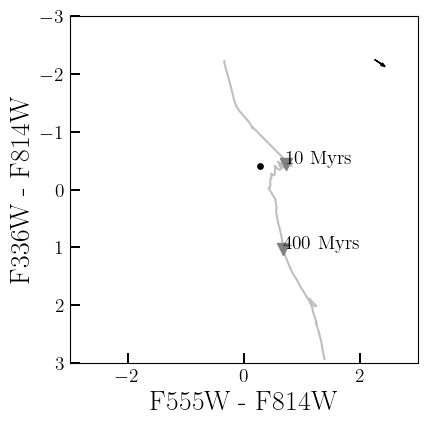

In [25]:
MakeCCD(
    clusters=clusterframe.query('`Cluster ID` == 7359'),
    instrument='wfc3',
    xcolor=['F555W', 'F814W'],
    ycolor=['F336W', 'F814W']
)

In [26]:
cluster_notes = M66_xrbs[['CSC ID', 'ID', 'Class']].copy()
cluster_notes['Cluster ID'] = None
cluster_notes['Notes'] = None
cluster_notes.to_csv(M66_dir+'/XRB-ejection/M66_cluster_notes.txt')

In [27]:
from helpers.regions import make_regions
temp['Distances'] = np.round(temp['Cluster Separation (pc)'].values, 0)

# Make vector regions
make_regions(sources=temp, hdu=f555w, outfile='/Users/undergradstudent/Downloads/xrb_cluster_temp.reg',
             reg_type='vector',
             coordsys='fk5', coordheads=['JWST RA', 'JWST Dec'],
             additional_coords=['Cluster RA', 'Cluster Dec'],
             idheader='Distances')

# Make regions around clusters
WriteReg(
    sources=temp,
    outfile='/Users/undergradstudent/Downloads/clusters_temp.reg',
    idheader='Cluster Age (Myr)',
    coordsys='fk5',
    coordheads=['Cluster RA', 'Cluster Dec'],
    radius=0.05,
    radunit='arcsec'
)

Saving /Users/undergradstudent/Downloads/xrb_cluster_temp.reg
/Users/undergradstudent/Downloads/xrb_cluster_temp.reg saved!
Saving /Users/undergradstudent/Downloads/clusters_temp.reg
/Users/undergradstudent/Downloads/clusters_temp.reg saved!


## Phangs ages are horrible 

Cluster Age: 6.0 +/- 1468.0
Plotting reddening arrow for V-I vs. B-V


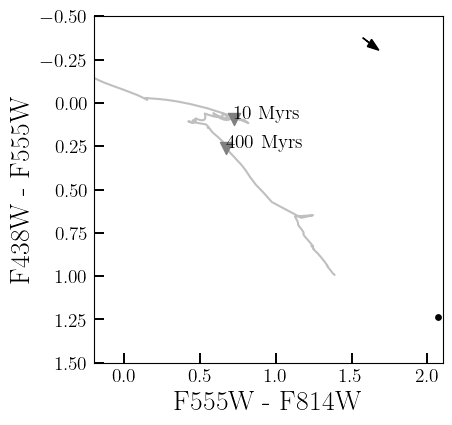

Cluster Age: 2.0 +/- 47.0
Plotting reddening arrow for V-I vs. B-V
Finding best-fit model(s)...
DONE


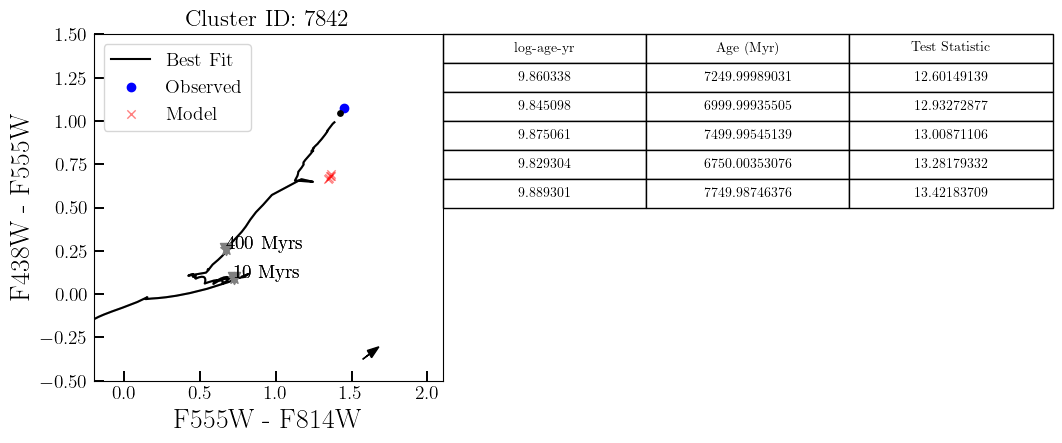

Unnamed: 0 index  log-age-yr    Vmag    Kmag  V-F225W  V-F336W  V-F438W  \
0       4566   NaN    9.829304  6.9098  3.3385  -0.9939  -0.8048  -0.7990   
1       4567   NaN    9.845098  6.9533  3.3869  -0.8794  -0.7549  -0.7863   
2       4568   NaN    9.860338  7.0100  3.4500  -0.7983  -0.7215  -0.7814   
3       4569   NaN    9.875061  7.0274  3.4772  -0.7618  -0.7040  -0.7735   
4       4570   NaN    9.889301  7.0457  3.5042  -0.7288  -0.6881  -0.7665   

   V-F547M  V-F555W  V-F606W  V-F625W  V-F656N  V-F657N  V-F658N  V-F814W  \
0  -0.0201  -0.1028   0.2232   0.4197   0.8647   0.7337   0.7924   1.2636   
1  -0.0201  -0.1016   0.2227   0.4188   0.8630   0.7322   0.7912   1.2595   
2  -0.0202  -0.1011   0.2234   0.4200   0.8645   0.7335   0.7927   1.2577   
3  -0.0202  -0.1003   0.2224   0.4183   0.8605   0.7302   0.7897   1.2498   
4  -0.0202  -0.0995   0.2215   0.4167   0.8571   0.7273   0.7870   1.2426   

   log Nly   Mt/Lb   Mt/Lv   Mt/Lk    Z Library  F225W - F336W  F225W - F438W  \
0  41.3442  4.1316  3.8547  0.5774  0.1  stelib         0.1891         0.1949   
1  41.3298  4.2495  4.0063  0.6028  0.1  stelib         0.1245         0.0931   
2  41.3048  4.4532  4.2146  0.6379  0.1  stelib         0.0768         0.0169   
3  41.2968  4.4893  4.2762  0.6531  0.1  stelib         0.0578        -0.0117   
4  41.2889  4.5331  4.3426  0.6686  0.1  stelib         0.0407        -0.0377   

   F225W - F555W  F225W - F814W  F336W - F438W  F336W - F555W  F336W - F814W  \
0         0.8911         2.2575         0.0058         0.7020         2.0684   
1         0.7778         2.1389        -0.0314         0.6533         2.0144   
2         0.6972         2.0560        -0.0599         0.6204         1.9792   
3         0.6615         2.0116        -0.0695         0.6037         1.9538   
4         0.6293         1.9714        -0.0784         0.5886         1.9307   

   F438W - F555W  F438W - F814W  F555W - F814W  Test Statistic Cluster ID  \
0         0.6962         2.0626         1.3664       13.281793       7842   
1         0.6847         2.0458         1.3611       12.932729       7842   
2         0.6803         2.0391         1.3588       12.601491       7842   
3         0.6732         2.0233         1.3501       13.008711       7842   
4         0.6670         2.0091         1.3421       13.421837       7842   

   level_0    Age (Myr)  
0   4566.0  6750.003531  
1   4567.0  6999.999355  
2   4568.0  7249.999890  
3   4569.0  7499.995451  
4   4570.0  7749.987464

In [550]:
temp = Find(clustercat, 'Cluster ID == 6790')\
            .rename(columns={'F275W': 'F225W', 'F275W Err': 'F225W Err'}).reset_index(drop=True)
print(f'Cluster Age: {temp['Cluster Age (Myr)'].iloc[0]} +/- {temp['Cluster Age Err (Myr)'].iloc[0]}')
MakeCCD(temp, ycolor=['F438W', 'F555W'],
        instrument='wfc3', E_BV=E_BV, ylim=(1.5, -0.5), xlim=(-0.2, 2.1) )
plt.show()
temp = Find(clustercat, 'Cluster ID == 7842')\
            .rename(columns={'F275W': 'F225W', 'F275W Err': 'F225W Err'}).reset_index(drop=True)
print(f'Cluster Age: {temp['Cluster Age (Myr)'].iloc[0]} +/- {temp['Cluster Age Err (Myr)'].iloc[0]}')
MakeCCD(temp, ycolor=['F438W', 'F555W'],
        instrument='wfc3', E_BV=E_BV, ylim=(1.5, -0.5), xlim=(-0.2, 2.1))
FitCCD(temp, idheader='Cluster ID',
       instrument='wfc3', plotCCD=True, E_BV=E_BV)

## New Approach for Parent Cluster Identifcation:


I have tried XRB parent cluster identification a couple of times and I do not trust the PHANGS cluster ages and masses. They have extremely big errors which add a really big variability in the data. 

With my first approach, I tried finding the nearest cluster with similar ages but since I did not incorporate any errors, I abandoned that approach. Next, I employed chisquared and weighted least squares techniques to find the parent cluster but that does not account for distance. So for our newest approach, we are using an updates weighted least squares technique where we also incorporate distance: 
$$\chi^2 = \sum\frac{(\text{Stellar Age} - \text{Cluster Age})^2}{\frac{\text{Cluster Age Err}}{\text{Separation}}}$$

In [3]:
clustercat = pd.read_csv(M66_dir+'XRB-ejection/phangs_cluster_catalog.frame')
M66_xrbs = pd.read_csv(M66_dir+"XRB-ejection/M66_xrbs_info.txt")
distances = pd.read_csv(M66_dir+'XRB-ejection/M66_XRB_distances.txt')
dists = distances.copy()

In [4]:
candidate_clusters = find_parent_cluster(df=dists, fit_type='updated wls',
                                     star_age_head='Stellar Age (Myr)')

In [5]:
# Select only the cluster with the lowest test statistic
def choose_xrb_cluster(df, num):
    '''Finds the xrb-cluster pair with the smallest test statistic and the nearest distance'''
    xrb_cluster = pd.DataFrame()
    for cscid in FindUnique(df, header='CSC ID')['CSC ID'].tolist():
        temp = Find(candidate_clusters, f'CSC ID = {cscid}').sort_values(by='XRB-Parent Test Statistic')
        cluster = temp.iloc[:num].sort_values(by='Cluster Separation (pc)')
        xrb_cluster = pd.concat([xrb_cluster, cluster])

    xrb_cluster = xrb_cluster.reset_index(drop=True)
    return xrb_cluster

In [6]:
xrb_cluster = choose_xrb_cluster(candidate_clusters, num=10)
xrb_cluster[['CSC ID', 'Cluster ID', 'Stellar Age (Myr)', 'Cluster Age (Myr)',
              'Cluster Age Err (Myr)', 'Cluster Separation (pc)',
              'XRB-Parent Test Statistic']]

CSC ID  Cluster ID  Stellar Age (Myr)  Cluster Age (Myr)  \
0    2CXO J112014.9+125933        7842           4.786301                2.0   
1    2CXO J112014.9+125933        7811           4.786301              403.0   
2    2CXO J112014.9+125933        7359           4.786301                5.0   
3    2CXO J112014.9+125933        6790           4.786301                6.0   
4    2CXO J112014.9+125933        6740           4.786301                5.0   
..                     ...         ...                ...                ...   
467  2CXO J112017.5+125644         103                NaN              182.0   
468  2CXO J112017.5+125644         427                NaN              261.0   
469  2CXO J112017.5+125644          56                NaN              147.0   
470  2CXO J112017.5+125644          96                NaN              136.0   
471  2CXO J112017.5+125644          42                NaN               10.0   

     Cluster Age Err (Myr)  Cluster Separation (pc)  XRB-Parent Test Statistic  
0                     47.0               403.731732                  66.688518  
1                   3357.0               458.291314               21648.244156  
2                     66.0               662.771003                   0.458590  
3                   1468.0               757.229005                   0.759842  
4                    153.0               808.528449                   0.241329  
..                     ...                      ...                        ...  
467                    0.0               840.302476                        NaN  
468                   79.0               932.026737                        NaN  
469                   29.0               936.560057                        NaN  
470                   83.0               948.944512                        NaN  
471                    1.0               981.909928                        NaN  

[472 rows x 7 columns]

### CCD fitting on selected clusters

In [7]:
E_BV = 0.122 - 0.093
best_fit = FitCCD(clustercat.rename(columns={'F275W': 'F225W', 'F275W Err': 'F225W Err'}), 
                instrument='wfc3', idheader='Cluster ID', E_BV=E_BV, plotCCD=False,
                min_models=1)

Finding best-fit model(s)...
DONE


In [8]:
best_fit.query('`Cluster ID` == 7359')

Unnamed: 0 index  log-age-yr    Vmag    Kmag  V-F225W  V-F336W  V-F438W  \
1958       2970   NaN    7.806546  3.1344 -0.1071   0.8931   0.6488   0.0352   

      V-F547M  V-F555W  V-F606W  V-F625W  V-F656N  V-F657N  V-F658N  V-F814W  \
1958  -0.0031   0.0076   0.0241   0.0323   0.0714   0.1064   0.1671   0.5115   

      log Nly  Mt/Lb   Mt/Lv   Mt/Lk    Z  Library  F225W - F336W  \
1958  41.3915  0.082  0.1557  0.0316  0.1  xmiless        -0.2443   

      F225W - F438W  F225W - F555W  F225W - F814W  F336W - F438W  \
1958        -0.8579        -0.8855        -0.3816        -0.6136   

      F336W - F555W  F336W - F814W  F438W - F555W  F438W - F814W  \
1958        -0.6412        -0.1373        -0.0276         0.4763   

      F555W - F814W  Test Statistic Cluster ID  level_0  Age (Myr)  
1958         0.5039       23.287875       7359   2970.0  64.053962

In [9]:
best_fit = best_fit.rename(columns={"Age (Myr)": 'Cluster Bestfit Age (Myr)',
                                    'Test Statistic': 'CCD Test Statistic'})
xrb_cluster = xrb_cluster.merge(best_fit[['Cluster ID', 'log-age-yr', 'Cluster Bestfit Age (Myr)', 'CCD Test Statistic']], how='left', on='Cluster ID')

In [10]:
xrb_cluster.query('`CSC ID` == "2CXO J112015.0+125921"')

CSC RA    CSC Dec                   Auxiliary ID Cluster ID  \
30  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       6790   
31  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       6740   
32  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       7359   
33  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       6229   
34  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       6625   
35  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       6610   
36  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       5993   
37  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       6453   
38  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       6538   
39  170.062538  12.989251  2CXO J112015.0+125921-7.0-1.0       7842   

                   CSC ID      ID Class  JWST ID  HST ID     JWST RA  \
30  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
31  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
32  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
33  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
34  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
35  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
36  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
37  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
38  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   
39  2CXO J112015.0+125921  CXO007  HMXB      7.0     1.0  170.062475   

     JWST Dec  F2000W ID  F3000M ID  F3350M ID  F3600M ID       JWST X  \
30  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
31  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
32  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
33  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
34  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
35  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
36  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
37  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
38  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   
39  12.989191   169350.0    39698.0    36199.0    41583.0  3086.128147   

         JWST Y        HST X        HST Y  F555W ID  F275W ID  F336W ID  \
30  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   
31  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   
32  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   
33  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   
34  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   
35  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   
36  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   
37  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   
38  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   
39  5505.907098  3727.624318  5519.646556   16435.0       NaN       NaN   

    F438W ID  F814W ID      HST RA    HST Dec  F2000W  F2000W Err     F3000M  \
30       NaN       NaN  170.062475  12.989172     NaN   13.846357 -10.932239   
31       NaN       NaN  170.062475  12.989172     NaN   13.846357 -10.932239   
32       NaN       NaN  170.062475  12.989172     NaN   13.846357 -10.932239   
33       NaN       NaN  170.062475  12.989172     NaN   13.846357 -10.932239   
34       NaN       NaN  170.062475  12.989172     NaN   13.846357 -10.932239   
35       NaN       NaN  170.062475  12.989172     NaN   13.846357 -10.932239   
36       NaN       NaN  170.062475  12.989172     NaN   13.846357 -10.932239   
37       NaN       NaN  170.062475  12.989172     NaN   13.846357 -10.932239   
38       NaN       NaN  170.062475  12.989172     NaN   13.846357 -10.93

I am manually looping through each X-ray source to find the best cluster parent.

In [77]:
i = 4
xrbid = M66_xrbs['CSC ID'].tolist()[i]
source = Find(xrb_cluster, f'CSC ID == {xrbid}')
display(source[['CSC ID', 'Cluster ID', 'Stellar Age (Myr)', 'Cluster Age (Myr)',
                 'Cluster Age Err (Myr)', 'Cluster Bestfit Age (Myr)', 'Cluster Separation (pc)',
                 'CCD Test Statistic']])
print(f'Stellar Age (Myr): {source.iloc[0]['Stellar Age (Myr)']}')

CSC ID Cluster ID  Stellar Age (Myr)  Cluster Age (Myr)  \
0  2CXO J112015.2+125921       6790           9.120108                6.0   
1  2CXO J112015.2+125921       6740           9.120108                5.0   
2  2CXO J112015.2+125921       7359           9.120108                5.0   
3  2CXO J112015.2+125921       6625           9.120108                5.0   
4  2CXO J112015.2+125921       6229           9.120108                3.0   
5  2CXO J112015.2+125921       6610           9.120108                8.0   
6  2CXO J112015.2+125921       6660           9.120108               13.0   
7  2CXO J112015.2+125921       6335           9.120108                9.0   
8  2CXO J112015.2+125921       6538           9.120108                5.0   
9  2CXO J112015.2+125921       5993           9.120108                7.0   

   Cluster Age Err (Myr)  Cluster Bestfit Age (Myr)  Cluster Separation (pc)  \
0                 1468.0                4750.004270               303.717083   
1                  153.0                1679.998910               372.267972   
2                   66.0                  64.053962               477.002141   
3                   77.0                1608.999837               676.154981   
4                   68.0                1139.097766               740.829561   
5                    6.0                  42.500007               750.713764   
6                   33.0               20000.000200               767.903593   
7                    1.0                  25.118980               817.988970   
8                   38.0                3499.999643               826.483392   
9                   42.0                  47.499933               942.597482   

   CCD Test Statistic  
0           64.338881  
1          567.240918  
2           23.287875  
3            6.239926  
4           33.836583  
5          412.217070  
6            6.422884  
7           58.647696  
8            9.709406  
9           57.776880

Stellar Age (Myr): 9.120108393559097


Plotting reddening arrow for V-I vs. B-V
Plotting reddening arrow for V-I vs. B-V


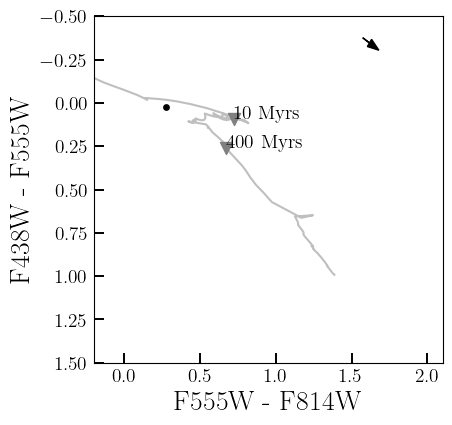

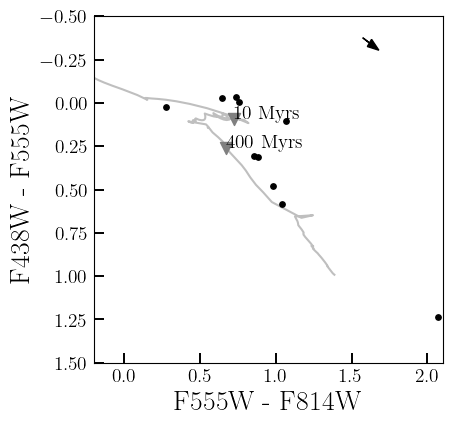

Finding best-fit model(s)...
DONE


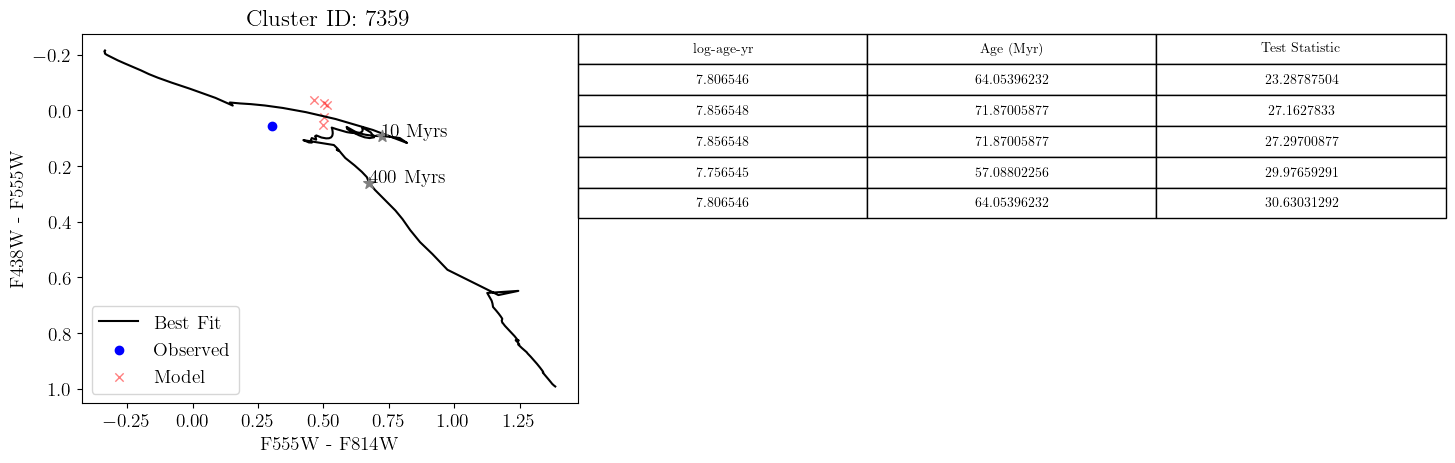

Unnamed: 0 index  log-age-yr    Vmag    Kmag  V-F225W  V-F336W  V-F438W  \
0       1211   NaN    7.856548  2.8086  0.8486   0.8445   0.5854  -0.0608   
1       2969   NaN    7.756545  3.0551 -0.1981   0.9859   0.7021   0.0471   
2       2970   NaN    7.806546  3.1344 -0.1071   0.8931   0.6488   0.0352   
3       2971   NaN    7.856548  3.2012 -0.0092   0.8087   0.5977   0.0245   
4       4290   NaN    7.806546  2.6761  0.7401   0.8432   0.5641  -0.0264   

   V-F547M  V-F555W  V-F606W  V-F625W  V-F656N  V-F657N  V-F658N  V-F814W  \
0  -0.0085  -0.0079   0.0679   0.1254   0.3799   0.2660   0.3005   0.4902   
1  -0.0030   0.0097   0.0206   0.0247   0.0635   0.0948   0.1552   0.4751   
2  -0.0031   0.0076   0.0241   0.0323   0.0714   0.1064   0.1671   0.5115   
3  -0.0031   0.0057   0.0261   0.0373   0.0735   0.1127   0.1740   0.5204   
4  -0.0067  -0.0029   0.0633   0.1131   0.2915   0.2650   0.3376   0.4996   

   log Nly   Mt/Lb   Mt/Lv   Mt/Lk     Z  Library  F225W - F336W  \
0  39.5100  0.0716  0.1252  0.0827  0.05    BaSeL        -0.2591   
1  41.3372  0.0759  0.1458  0.0293  0.10  xmiless        -0.2838   
2  41.3915  0.0820  0.1557  0.0316  0.10  xmiless        -0.2443   
3  41.4435  0.0874  0.1643  0.0343  0.10  xmiless        -0.2110   
4  39.7867  0.0624  0.1117  0.0754  0.05   stelib        -0.2791   

   F225W - F438W  F225W - F555W  F225W - F814W  F336W - F438W  F336W - F555W  \
0        -0.9053        -0.8524        -0.3543        -0.6462        -0.5933   
1        -0.9388        -0.9762        -0.5108        -0.6550        -0.6924   
2        -0.8579        -0.8855        -0.3816        -0.6136        -0.6412   
3        -0.7842        -0.8030        -0.2883        -0.5732        -0.5920   
4        -0.8696        -0.8461        -0.3436        -0.5905        -0.5670   

   F336W - F814W  F438W - F555W  F438W - F814W  F555W - F814W  Test Statistic  \
0        -0.0952         0.0529         0.5510         0.4981       27.297009   
1        -0.2270        -0.0374         0.4280         0.4654       29.976593   
2        -0.1373        -0.0276         0.4763         0.5039       23.287875   
3        -0.0773        -0.0188         0.4959         0.5147       27.162783   
4        -0.0645         0.0235         0.5260         0.5025       30.630313   

  Cluster ID  level_0  Age (Myr)  
0       7359   1211.0  71.870059  
1       7359   2969.0  57.088023  
2       7359   2970.0  64.053962  
3       7359   2971.0  71.870059  
4       7359   4290.0  64.053962

In [78]:
temp_clusters = source['Cluster ID'].tolist()
temp_clusters = clustercat.query('`Cluster ID` in @temp_clusters')\
            .rename(columns={'F275W': 'F225W', 'F275W Err': 'F225W Err'}).reset_index(drop=True)
clusterid = 7359
MakeCCD(Find(temp_clusters, f'Cluster ID == {clusterid}'), ycolor=['F438W', 'F555W'],
        instrument='wfc3', E_BV=E_BV, ylim=(1.5, -0.5), xlim=(-0.2, 2.1))
MakeCCD(temp_clusters, ycolor=['F438W', 'F555W'],
        instrument='wfc3', E_BV=E_BV, ylim=(1.5, -0.5), xlim=(-0.2, 2.1) )
plt.show()
FitCCD(Find(temp_clusters, f'Cluster ID == {clusterid}'), instrument='wfc3', idheader='Cluster ID',
       plotCCD=True, E_BV=E_BV)
# FitCCD(Find(temp_clusters, f'Cluster ID == {clusterid}'), instrument='wfc3', idheader='Cluster ID',
#        plotCCD=True, xcolor=['F225W', 'F336W'], ycolor=['F555W', 'F814W'], E_BV=E_BV)

# FitCCD problems

look at the HST/JWST image

Finding best-fit model(s)...
DONE


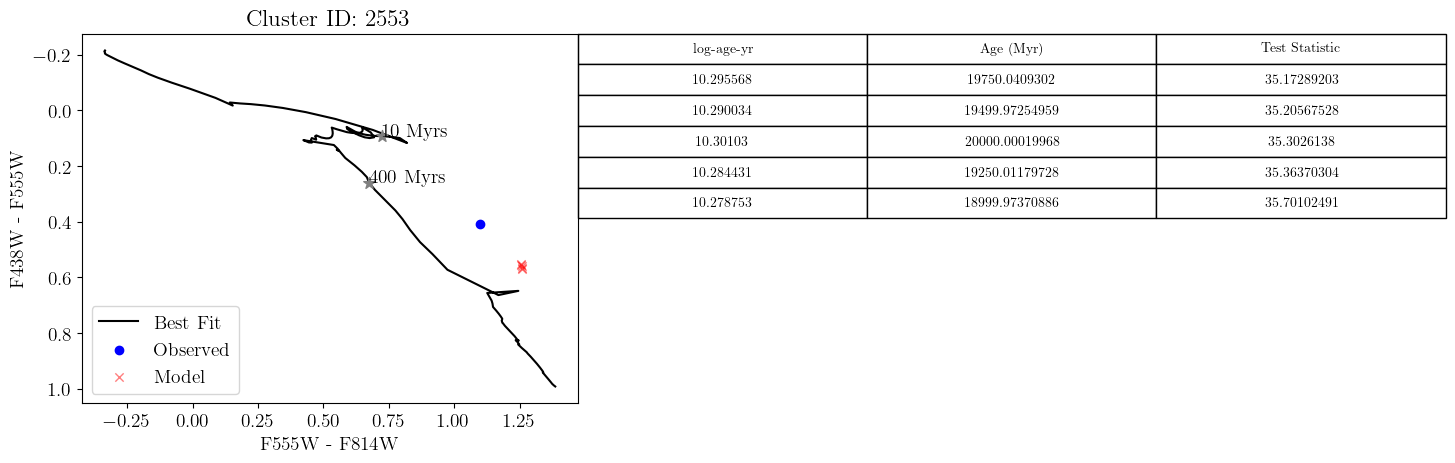

Unnamed: 0 index  log-age-yr    Vmag    Kmag  V-F225W  V-F336W  V-F438W  \
0       3075   NaN   10.278753  8.1805  4.4511   0.2080  -0.2502  -0.6573   
1       3076   NaN   10.284431  8.1911  4.4596   0.2326  -0.2334  -0.6521   
2       3077   NaN   10.290034  8.2018  4.4681   0.2559  -0.2173  -0.6471   
3       3078   NaN   10.295568  8.2129  4.4767   0.2781  -0.2020  -0.6422   
4       3079   NaN   10.301030  8.2241  4.4853   0.2991  -0.1874  -0.6376   

   V-F547M  V-F555W  V-F606W  V-F625W  V-F656N  V-F657N  V-F658N  V-F814W  \
0  -0.0212  -0.0876   0.2031   0.3883   0.7514   0.6387   0.6986   1.1736   
1  -0.0211  -0.0872   0.2025   0.3871   0.7499   0.6373   0.6971   1.1723   
2  -0.0210  -0.0867   0.2019   0.3859   0.7484   0.6359   0.6958   1.1712   
3  -0.0209  -0.0863   0.2014   0.3848   0.7470   0.6346   0.6945   1.1701   
4  -0.0209  -0.0859   0.2008   0.3837   0.7456   0.6333   0.6932   1.1692   

   log Nly    Mt/Lb    Mt/Lv   Mt/Lk    Z  Library  F225W - F336W  \
0  41.0675  11.3081  11.8985  1.5409  0.1  xmiless        -0.4582   
1  41.0732  11.3620  12.0088  1.5521  0.1  xmiless        -0.4660   
2  41.0784  11.4201  12.1223  1.5634  0.1  xmiless        -0.4732   
3  41.0833  11.4832  12.2401  1.5750  0.1  xmiless        -0.4801   
4  41.0879  11.5506  12.3612  1.5868  0.1  xmiless        -0.4865   

   F225W - F438W  F225W - F555W  F225W - F814W  F336W - F438W  F336W - F555W  \
0        -0.8653        -0.2956         0.9656        -0.4071         0.1626   
1        -0.8847        -0.3198         0.9397        -0.4187         0.1462   
2        -0.9030        -0.3426         0.9153        -0.4298         0.1306   
3        -0.9203        -0.3644         0.8920        -0.4402         0.1157   
4        -0.9367        -0.3850         0.8701        -0.4502         0.1015   

   F336W - F814W  F438W - F555W  F438W - F814W  F555W - F814W  Test Statistic  \
0         1.4238         0.5697         1.8309         1.2612       35.701025   
1         1.4057         0.5649         1.8244         1.2595       35.363703   
2         1.3885         0.5604         1.8183         1.2579       35.205675   
3         1.3721         0.5559         1.8123         1.2564       35.172892   
4         1.3566         0.5517         1.8068         1.2551       35.302614   

  Cluster ID  level_0     Age (Myr)  
0       2553   3075.0  18999.973709  
1       2553   3076.0  19250.011797  
2       2553   3077.0  19499.972550  
3       2553   3078.0  19750.040930  
4       2553   3079.0  20000.000200

In [13]:
# Age is more than 13 Gyr
FitCCD(Find(clustercat, 'Cluster ID = 2553').rename(columns={'F275W': 'F225W', 'F275W Err': 'F225W Err'}), idheader='Cluster ID',
       instrument='wfc3', plotCCD=True, E_BV=E_BV)

# Calculate Velocities

In [14]:
import itertools

def CalcEjection(df, cluster_age, cluster_rad, cluster_mass, xrb_mass, dist, m_avg=0.4, N_int=20): 
    """
    Calculates the absolute minimum and approximate maximum velocities of XRBs ejected from 
    nearby clusters, given the age, radius, and mass of the cluster, mass of the XRB donor star, 
    and distance between the cluster and XRB.
    
    The maximum velocity is calculated based on which ejection mechanism minimizes
    the travel time of the XRB given the cluster parameters: natal kicks, or 
    single-binary (3-body) interactions. These are based on the maximum formation 
    time of a compact object, or the ejection time following a series of strong 
    interactions.
    
    Make sure the age of the cluster and age of the star are in the same units. 
    Distance between the XRB and cluster should be in [UNITS].
    
    PARAMETERS:
    -----------
    cluster_age [float]    :    Age of the parent cluster, in Myrs
    cluster_rad [float]    :    Radius of the parent cluster, in parsecs
    cluster_mass[float]    :    Mass of the parent cluster, in Msun
    xrb_mass    [float]    :    Mass of the XRB donor star, in Msun
    dist        [float]    :    Distance between the cluster and XRB in parsecs.
    m_avg       [float]    :    Average mass of the star in the cluster. Default is 
                                0.4 Msun, based on the Kroupa 2001 IMF. 
    N_int       [int]      :    Number of single-binary interactions required before
                                the XRB is ejected from the cluster. Default is 20.
    """
    
    df = df.copy()

    # UNITS
    Myr2sec = 3.1536e13 # Multiply Myr by Myr2sec to get time in secs
    sec2Myr = 1./Myr2sec
    pc2km = 3.086e13    # Multiply pc by pc2km to get km
    km2pc = 1./pc2km
    pc2au = 206265  # multiply pc by pc2au to get au
    au2pc = 1./pc2au
    
    # Gravitational constant
    # G = 6.6743e-11 # m^3 / km / s^2
    G_astro = 4.3009e-3 # in pc(km/s)^2/Msun or 1.908e5 in (km/s)^2*Rsun/Msun

    
    #############################################################
    #####   CALCULATION OF THE MAXIMUM VELOCITY OF THE XRB  #####
    #############################################################  
    
    # units km/s
    vmin = (dist*pc2km) / (cluster_age*Myr2sec)
    
    #############################################################
    ##### CALCULATION OF THE COMPACT OBJECT FORMATION TIME  #####
    #############################################################
    
    # Time of CO formation assumes CO formed from 8Msun star 
    # and takes and additional 1 Myr to complete metal burning
    
    # Calculate a mesh of stellar masses between 8-200Msun
    # Determine which gives the longest Tco without exceeding the
    # age of the cluster
    for m in range(200,7,-1):
        Tco_m = (1e10*(m)**(-2.5))/1.e6 + 1
        if Tco_m < cluster_age:
            #Tco = 57 # units Myrs
            Tco = (1e10*(m)**(-2.5))/1.e6 + 1
            Tmin_co = cluster_age - Tco # units Myrs
            Tco_mass = m
            # Tmin_co will be the travel time, and Tco is the max ejection time
            
    # Starting list of timings and their methodology
    timings = [round(Tmin_co,3)]
    timings_name = [f"Natal Kick ({Tco_mass} Msun)"]
    
    #print(timings) 
    
    #############################################################
    ##### CALCULATION OF THE SINGLE-BINARY INTERACTION TIME #####
    #############################################################
    

    # Calculating scape velocity of the cluster
    Mcl = cluster_mass # units Msun
    Rcl = cluster_rad  # units pc
    v_esc = np.sqrt(2*G_astro*Mcl/Rcl) # in km/s
    
    fbs = np.linspace(0.2,0.9,8)
    Ns = np.linspace(1,100,100)
    
    Tsbs = []
    for vals in itertools.product(fbs, Ns):
        Tsb = singlebinarytime(cluster_rad=cluster_rad,
                               cluster_mass=cluster_mass, 
                               xrb_mass=xrb_mass, fb=vals[0], 
                               m_avg=m_avg, N_int=vals[1])

        # Tsb is the ejection time of the XRB for this set of parameters
        Tsbs.append(Tsb)
        
        # Calculating the minimum travel time of the XRB, post-ejection, in Myrs
        Tmin_sb = cluster_age - Tsb
    
        #Adding to list of timings, the list of travel times given the ejection time
        timings.append(round(Tmin_sb,3))
        timings_name.append(f"Dynamical Interactions (fb={vals[0]}, N={int(vals[1])})")
    
    #############################################################
    #####   CALCULATION OF THE MAXIMUM VELOCITY OF THE XRB  #####
    #############################################################  
    
    # Selecting the minimum positive travel time as Tmin
    # Negative travel times are not allowed, as it implies the 
    # ejection time is longer than the age of the cluster
    Tmin = min(t for t in timings if t > 0) 
    best_model = timings_name[timings.index(Tmin)]

    # Pulling the ejection time of the best 
    try: Tsb_ej = Tsbs[timings.index(min([t for t in timings[1:] if t > 0])) - 1]
    except: pass; 
    

    # Choosing the 
    # Calculating vmax, assuming the maximum distance is 1000pc
    vmax = (1000.*pc2km)/(Tmin*Myr2sec)

    #####################
    ##### Printouts #####
    #####################

   #print("Cluster Age [Myr]:", cluster_age)
   #print("Cluster Mass [Msun]:", cluster_mass)
   #print("Cluster Effective Radius [pc]:", cluster_rad)
   #print("Cluster Half-mass Radius:", Rh)
   #print("Cluster Density [Msun/pc^3]:", dens)
   #print("Cluster Velocity Dispersion [km/s]:", np.sqrt(v_disp2))
    
    df['XRB Kick Ejection Time (Myr)'] = np.nan
    df["XRB Dynamical Ejection Time (Myr)"] = np.nan
    df["Min. XRB Dynamical Interaction Time (Myr)"] = np.nan
    df['Max. Velocity method'] = np.nan
    df['Minimum travel time (Myr)'] = np.nan
    df['Cluster Escape Velocity (km/s)'] = np.nan
    df['Minimum XRB Velocity (km/s)'] = np.nan
    df['Maximum XRB Velocity (km/s)'] = np.nan
    
    try:
        # print("####### SIMULATION RESULTS ########\n")
        # print("XRB Kick Ejection Time:", round(Tco, 3), "Myr")
        df['XRB Kick Ejection Time (Myr)'] = Tco
        try:
            # print("XRB Dynamical Ejection Time:", round(Tsb_ej,3), "Myr")
            df["XRB Dynamical Ejection Time (Myr)"] = Tsb_ej
        except: 
            # print("Min. XRB Dynamical Interaction Time:", round(min(Tsbs),3), "Myr")
            df["Min. XRB Dynamical Interaction Time (Myr)"] = min(Tsbs)
        # print("Max. Velocity Method:", best_model)
        df['Max. Velocity method'] = best_model
        # print("Minimum travel time:", round(Tmin,3),"Myr")
        df['Minimum travel time (Myr)'] = Tmin.min()
        # print("Cluster Escape Velocity:", round(v_esc,3), "km/s")
        df['Cluster Escape Velocity (km/s)'] = v_esc
        # print("Minimum XRB Velocity:", round(vmin,3), "km/s")
        df['Minimum XRB Velocity (km/s)'] = vmin
        # print("Maximum XRB Velocity:", round(vmax,3), "km/s")
        df['Maximum XRB Velocity (km/s)'] = vmax
        # print("\n-----------------------------------\n")
    except: 
        # print("Invalid ejection times: Tmin is negative. Check parameters of XRB-cluster pair.")
        # print("Minimum XRB Velocity:", vmin)
        df['Minimum XRB Velocity (km/s)'] = vmin
        # print("Escape XRB Velocity:", v_esc)
        df['Cluster Escape Velocity (km/s)'] = v_esc
        # print("\n-----------------------------------\n")
        
    # df['XRB Kick Ejection Time (Myr)'] = Tco
    # if Tsb_ej: df["XRB Dynamical Ejection Time (Myr)"] = Tsb_ej
    # if Tsbs: df["Min. XRB Dynamical Interaction Time (Myr)"] = Tsbs
    # df['Max. Velocity method'] = best_model
    # df['Minimum travel time (Myr)'] = Tmin
    # df['Cluster Escape Velocity (km/s)'] = v_esc
    # df['Minimum XRB Velocity (km/s)'] = vmin
    # df['Maximum XRB Velocity'] = vmax

    return df
        
#######################

def singlebinarytime(cluster_mass, cluster_rad, xrb_mass, fb=0.5, m_avg=0.4, N_int=20):
    
    """
    Calculating the single-binary interaction time from Herrera-Urquiet et al. (2025).
    Properties of the cluster used in the calculation come from the Plummer cluster model
    (Plummer 1911; Aarseth et al. 1974). 
    
    Returns the total ejection time in Myrs. 
    
    cluster_mass    [float]    :    Mass of the cluster in Msun. 
    cluster_rad     [float]    :    Effective radius of the cluster in pc. 
    xrb_mass        [float]    :    Mass of the XRB in Msun. 
    fb              [float]    :    Fraction of stars in a cluster that are part
                                    of a binary. Can only take values between 0-0.99.
    m_avg           [float]    :    Average mass of stars in the cluster in Msun. 
                                    Default is 0.4, consistent with the Kroupa IMF. 
    N_int           [int]      :    Number of single-binary interactions before the 
                                    XRB is ejected from the cluster. Default is 20. 
    
    """
    
    # UNITS
    Myr2sec = 3.1536e13 # Multiply Myr by Myr2sec to get time in secs
    sec2Myr = 1./Myr2sec
    pc2km = 3.086e13    # Multiply pc by pc2km to get km
    km2pc = 1./pc2km
    pc2au = 206265  # multiply pc by pc2au to get au
    au2pc = 1./pc2au
    au2km = 1.496e8
    km2au = 1./au2km
    G_astro = 4.3009e-3
    
    # Calculating scape velocity of the cluster
    Mcl = cluster_mass # units Msun
    Rcl = cluster_rad  # units pc

    # Core radius is 1/2 half-mass radius, which is (4/3)*Reff
    R_core = 0.5 * (4./3.) * Rcl
    rP = R_core/0.6455 # length-scale of the Plummer model
    
    #print(f"rP: {rP}, R_core: {R_core}, Rcluster={Rcl}")
    # Core density from Plummer model (see Wilkinson et al. 2003)
    D_core = (3*Mcl)/(4*np.pi*rP**3) * (1 + (R_core/rP)**2)**(-5./2.)
    n_core = D_core/m_avg # number density, units pc^-3 
    
    #print(f"Mass: {Mcl}, Density: {D_core}, n: {n_core}")
    # Calculating escape velocity and velocity dispersion
    v_esc = np.sqrt(2*G_astro*Mcl/Rcl) # in km/s
    # Velocity dispersion of the cluster squared, from virial theorem
    # e.g. https://publish.obsidian.md/astrowiki/G.+Galaxies/Velocity+Dispersion#:~:text=Galaxy%20Velocity%20Dispersion,Derivation
    v_disp = np.sqrt((2./3.)*G_astro*Mcl/Rcl) # in (km/s)^2
 
    # Semi-major axis calculation, from Equation 16 in 
    # Rando Forastier, B., Mar´ın Pina, D., Gieles, M., Portegies185
    # Zwart, S., & Antonini, F. 2025, A&A, 697, A118,186
    # doi: 10.1051/0004-6361/202450890
    # Results in units pc
    # a_ej = G_astro * (Mco*Mdonor*Ms3)/(Msb*Mxrb) * 1./(v_esc)**2 * 0.2*(1 - np.exp(-7.0*Ms3/Mxrb))
    
    # Equation above is obsolete now. Use this single value below
    a_ej_au = 168 # Adopted from Herrera-Urquiesta et al. (2025)
    
    time = 3.4e7 * (1-fb)**(-1) * fb**(-1) * (1./R_core)**3 * ((1e3)/n_core)**2 * (v_disp/5.) * (0.5/m_avg) * (1./(a_ej_au))
    #print("Time [Myr]:", time/1e6)
    #print("Ejection Time [Myr]:", N_int*time/1e6)
    return N_int*time/1e6


In [15]:
parents = remove_unnamed(pd.read_csv(M66_dir+'XRB-ejection/M66_cluster_notes.txt'))
parents = Find(parents, 'Cluster ID != Nan')
parents

CSC ID      ID Class  Cluster ID  \
0   2CXO J112014.9+125933  CXO003  HMXB      7359.0   
1   2CXO J112015.0+125936  CXO006  HMXB      8032.0   
2   2CXO J112015.0+125921  CXO007  HMXB      7359.0   
3   2CXO J112015.2+125921  CXO008  HMXB      7359.0   
4   2CXO J112014.7+125937  CXO009  HMXB      7359.0   
5   2CXO J112015.0+125938  CXO010  HMXB      8004.0   
6   2CXO J112014.2+125927  CXO011  LMXB      7720.0   
7   2CXO J112014.1+125923  CXO012  LMXB      7066.0   
8   2CXO J112014.3+125918  CXO013  LMXB      7020.0   
9   2CXO J112015.3+125944  CXO014  IMXB      8073.0   
10  2CXO J112015.8+125910  CXO016  HMXB      6381.0   
11  2CXO J112013.9+125913  CXO017  HMXB      7251.0   
12  2CXO J112013.4+125928  CXO018  HMXB      6269.0   
13  2CXO J112015.5+125955  CXO020  HMXB      8032.0   
14  2CXO J112015.8+125904  CXO021  LMXB      5345.0   
15  2CXO J112012.8+125947  CXO022  HMXB      8368.0   
16  2CXO J112012.6+125947  CXO023  HMXB      7827.0   
17  2CXO J112016.8+125959  CXO024  HMXB      8501.0   
18  2CXO J112017.1+130003  CXO026  HMXB      9088.0   
19  2CXO J112012.2+125952  CXO027  HMXB      8627.0   
20  2CXO J112012.0+125910  CXO028  HMXB      6798.0   
21  2CXO J112015.8+130019  CXO030  HMXB      9398.0   
22  2CXO J112016.6+125844  CXO031  HMXB      4070.0   
23  2CXO J112018.2+125959  CXO032  HMXB      8019.0   
24  2CXO J112018.8+125924  CXO035  HMXB      7406.0   
25  2CXO J112013.7+130025  CXO036  HMXB      9598.0   
26  2CXO J112012.3+125846  CXO037  HMXB      5857.0   
27  2CXO J112017.3+130019  CXO039  LMXB      9948.0   
28  2CXO J112017.1+130025  CXO043  LMXB      9453.0   
29  2CXO J112016.7+125830  CXO044  HMXB      3724.0   
30  2CXO J112016.4+130034  CXO045  LMXB     10243.0   
31  2CXO J112019.5+125958  CXO047  HMXB      8028.0   
32  2CXO J112017.5+125818  CXO050  HMXB      2918.0   
33  2CXO J112019.0+130027  CXO051  HMXB      9555.0   
34  2CXO J112011.8+125811  CXO052  HMXB      2612.0   
35  2CXO J112019.7+130030  CXO053  HMXB      9555.0   
36  2CXO J112013.0+125736  CXO060  HMXB      1183.0   

                              Notes  
0                               NaN  
1        7359 is also a good parent  
2                               NaN  
3                               NaN  
4                               NaN  
5                               NaN  
6                               NaN  
7                               NaN  
8                               NaN  
9                               NaN  
10                              NaN  
11                              NaN  
12                              NaN  
13                              NaN  
14                              NaN  
15                              NaN  
16                              NaN  
17                              NaN  
18                              NaN  
19                              NaN  
20                              NaN  
21                              NaN  
22                              NaN  
23                              NaN  
24                              NaN  
25                              NaN  
26                              NaN  
27                              NaN  
28                              NaN  
29                              NaN  
30                              NaN  
31                              NaN  
32                              NaN  
33   Phangs age bad but my age good  
34                              NaN  
35                              NaN  
36                              NaN

In [16]:
xrb_parent = parents.merge(xrb_cluster, on=['Cluster ID', 'CSC ID', 'ID', 'Class'], how='left')
xrb_parent

CSC ID      ID Class Cluster ID  \
0   2CXO J112014.9+125933  CXO003  HMXB     7359.0   
1   2CXO J112015.0+125936  CXO006  HMXB     8032.0   
2   2CXO J112015.0+125921  CXO007  HMXB     7359.0   
3   2CXO J112015.2+125921  CXO008  HMXB     7359.0   
4   2CXO J112014.7+125937  CXO009  HMXB     7359.0   
5   2CXO J112015.0+125938  CXO010  HMXB     8004.0   
6   2CXO J112014.2+125927  CXO011  LMXB     7720.0   
7   2CXO J112014.1+125923  CXO012  LMXB     7066.0   
8   2CXO J112014.3+125918  CXO013  LMXB     7020.0   
9   2CXO J112015.3+125944  CXO014  IMXB     8073.0   
10  2CXO J112015.8+125910  CXO016  HMXB     6381.0   
11  2CXO J112013.9+125913  CXO017  HMXB     7251.0   
12  2CXO J112013.4+125928  CXO018  HMXB     6269.0   
13  2CXO J112015.5+125955  CXO020  HMXB     8032.0   
14  2CXO J112015.8+125904  CXO021  LMXB     5345.0   
15  2CXO J112012.8+125947  CXO022  HMXB     8368.0   
16  2CXO J112012.6+125947  CXO023  HMXB     7827.0   
17  2CXO J112016.8+125959  CXO024  HMXB     8501.0   
18  2CXO J112017.1+130003  CXO026  HMXB     9088.0   
19  2CXO J112012.2+125952  CXO027  HMXB     8627.0   
20  2CXO J112012.0+125910  CXO028  HMXB     6798.0   
21  2CXO J112015.8+130019  CXO030  HMXB     9398.0   
22  2CXO J112016.6+125844  CXO031  HMXB     4070.0   
23  2CXO J112018.2+125959  CXO032  HMXB     8019.0   
24  2CXO J112018.8+125924  CXO035  HMXB     7406.0   
25  2CXO J112013.7+130025  CXO036  HMXB     9598.0   
26  2CXO J112012.3+125846  CXO037  HMXB     5857.0   
27  2CXO J112017.3+130019  CXO039  LMXB     9948.0   
28  2CXO J112017.1+130025  CXO043  LMXB     9453.0   
29  2CXO J112016.7+125830  CXO044  HMXB     3724.0   
30  2CXO J112016.4+130034  CXO045  LMXB    10243.0   
31  2CXO J112019.5+125958  CXO047  HMXB     8028.0   
32  2CXO J112017.5+125818  CXO050  HMXB     2918.0   
33  2CXO J112019.0+130027  CXO051  HMXB     9555.0   
34  2CXO J112011.8+125811  CXO052  HMXB     2612.0   
35  2CXO J112019.7+130030  CXO053  HMXB     9555.0   
36  2CXO J112013.0+125736  CXO060  HMXB     1183.0   

                              Notes      CSC RA    CSC Dec  \
0                               NaN  170.062259  12.992633   
1        7359 is also a good parent  170.062785  12.993429   
2                               NaN  170.062538  12.989251   
3                               NaN  170.063419  12.989393   
4                               NaN  170.061339  12.993597   
5                               NaN  170.062887  12.993977   
6                               NaN  170.059380  12.990875   
7                               NaN  170.058772  12.989771   
8                               NaN  170.059709  12.988377   
9                               NaN  170.064028  12.995589   
10                              NaN  170.065983  12.986237   
11                              NaN  170.058048  12.986939   
12                              NaN  170.055921  12.991105   
13                              NaN  170.064793  12.998581   
14                              NaN  170.065903  12.984421   
15                              NaN  170.053614  12.996594   
16                              NaN  170.052527  12.996542   
17                              NaN  170.070149  12.999835   
18                              NaN  170.071585  13.000886   
19                              NaN  170.050873  12.997819   
20                              NaN  170.050187  12.986338   
21                              NaN  170.066003  13.005280   
22                              NaN  170.069365  12.978872   
23                              NaN  170.075880  12.999774   
24                              NaN  170.078512  12.990211   
25                              NaN  170.057330  13.006947   
26                              NaN  170.051250  12.979514   
27                              NaN  170.072362  13.005469   
28                              NaN  170.071464  13.007172   
29                              NaN  170.069903  12.975028   
30                              NaN  170.068

In [17]:
# Convert Effective radius to half mass radius
# for velocity calculations
r_eff = xrb_parent['Cluster Radius Eff (pc)'].values 
r_h = (4 / 3 * r_eff)
xrb_parent.insert(xrb_parent.columns.get_loc('Cluster Radius Eff (pc)') + 1,
                 'Cluster half-mass Radius (pc)', r_h)

In [18]:
xrb_parent

CSC ID      ID Class Cluster ID  \
0   2CXO J112014.9+125933  CXO003  HMXB     7359.0   
1   2CXO J112015.0+125936  CXO006  HMXB     8032.0   
2   2CXO J112015.0+125921  CXO007  HMXB     7359.0   
3   2CXO J112015.2+125921  CXO008  HMXB     7359.0   
4   2CXO J112014.7+125937  CXO009  HMXB     7359.0   
5   2CXO J112015.0+125938  CXO010  HMXB     8004.0   
6   2CXO J112014.2+125927  CXO011  LMXB     7720.0   
7   2CXO J112014.1+125923  CXO012  LMXB     7066.0   
8   2CXO J112014.3+125918  CXO013  LMXB     7020.0   
9   2CXO J112015.3+125944  CXO014  IMXB     8073.0   
10  2CXO J112015.8+125910  CXO016  HMXB     6381.0   
11  2CXO J112013.9+125913  CXO017  HMXB     7251.0   
12  2CXO J112013.4+125928  CXO018  HMXB     6269.0   
13  2CXO J112015.5+125955  CXO020  HMXB     8032.0   
14  2CXO J112015.8+125904  CXO021  LMXB     5345.0   
15  2CXO J112012.8+125947  CXO022  HMXB     8368.0   
16  2CXO J112012.6+125947  CXO023  HMXB     7827.0   
17  2CXO J112016.8+125959  CXO024  HMXB     8501.0   
18  2CXO J112017.1+130003  CXO026  HMXB     9088.0   
19  2CXO J112012.2+125952  CXO027  HMXB     8627.0   
20  2CXO J112012.0+125910  CXO028  HMXB     6798.0   
21  2CXO J112015.8+130019  CXO030  HMXB     9398.0   
22  2CXO J112016.6+125844  CXO031  HMXB     4070.0   
23  2CXO J112018.2+125959  CXO032  HMXB     8019.0   
24  2CXO J112018.8+125924  CXO035  HMXB     7406.0   
25  2CXO J112013.7+130025  CXO036  HMXB     9598.0   
26  2CXO J112012.3+125846  CXO037  HMXB     5857.0   
27  2CXO J112017.3+130019  CXO039  LMXB     9948.0   
28  2CXO J112017.1+130025  CXO043  LMXB     9453.0   
29  2CXO J112016.7+125830  CXO044  HMXB     3724.0   
30  2CXO J112016.4+130034  CXO045  LMXB    10243.0   
31  2CXO J112019.5+125958  CXO047  HMXB     8028.0   
32  2CXO J112017.5+125818  CXO050  HMXB     2918.0   
33  2CXO J112019.0+130027  CXO051  HMXB     9555.0   
34  2CXO J112011.8+125811  CXO052  HMXB     2612.0   
35  2CXO J112019.7+130030  CXO053  HMXB     9555.0   
36  2CXO J112013.0+125736  CXO060  HMXB     1183.0   

                              Notes      CSC RA    CSC Dec  \
0                               NaN  170.062259  12.992633   
1        7359 is also a good parent  170.062785  12.993429   
2                               NaN  170.062538  12.989251   
3                               NaN  170.063419  12.989393   
4                               NaN  170.061339  12.993597   
5                               NaN  170.062887  12.993977   
6                               NaN  170.059380  12.990875   
7                               NaN  170.058772  12.989771   
8                               NaN  170.059709  12.988377   
9                               NaN  170.064028  12.995589   
10                              NaN  170.065983  12.986237   
11                              NaN  170.058048  12.986939   
12                              NaN  170.055921  12.991105   
13                              NaN  170.064793  12.998581   
14                              NaN  170.065903  12.984421   
15                              NaN  170.053614  12.996594   
16                              NaN  170.052527  12.996542   
17                              NaN  170.070149  12.999835   
18                              NaN  170.071585  13.000886   
19                              NaN  170.050873  12.997819   
20                              NaN  170.050187  12.986338   
21                              NaN  170.066003  13.005280   
22                              NaN  170.069365  12.978872   
23                              NaN  170.075880  12.999774   
24                              NaN  170.078512  12.990211   
25                              NaN  170.057330  13.006947   
26                              NaN  170.051250  12.979514   
27                              NaN  170.072362  13.005469   
28                              NaN  170.071464  13.007172   
29                              NaN  170.069903  12.975028   
30                              NaN  170.068

In [19]:
velocity = pd.DataFrame()
for i in range(len(xrb_parent)):
    data = CalcEjection(
        df=xrb_parent.iloc[[i]],
        cluster_age=xrb_parent['Stellar Age (Myr)'].values[i],
        cluster_rad=xrb_parent['Cluster half-mass Radius (pc)'].values[i],
        cluster_mass=xrb_parent['Cluster Mass (M_sun)'].values[i],
        xrb_mass=xrb_parent['Star Mass (Myr)'].values[i],
        dist=xrb_parent['Cluster Separation (pc)'].values[i],
    )
    velocity = pd.concat([velocity, data])

velocity

CSC ID      ID Class Cluster ID  \
0   2CXO J112014.9+125933  CXO003  HMXB     7359.0   
1   2CXO J112015.0+125936  CXO006  HMXB     8032.0   
2   2CXO J112015.0+125921  CXO007  HMXB     7359.0   
3   2CXO J112015.2+125921  CXO008  HMXB     7359.0   
4   2CXO J112014.7+125937  CXO009  HMXB     7359.0   
5   2CXO J112015.0+125938  CXO010  HMXB     8004.0   
6   2CXO J112014.2+125927  CXO011  LMXB     7720.0   
7   2CXO J112014.1+125923  CXO012  LMXB     7066.0   
8   2CXO J112014.3+125918  CXO013  LMXB     7020.0   
9   2CXO J112015.3+125944  CXO014  IMXB     8073.0   
10  2CXO J112015.8+125910  CXO016  HMXB     6381.0   
11  2CXO J112013.9+125913  CXO017  HMXB     7251.0   
12  2CXO J112013.4+125928  CXO018  HMXB     6269.0   
13  2CXO J112015.5+125955  CXO020  HMXB     8032.0   
14  2CXO J112015.8+125904  CXO021  LMXB     5345.0   
15  2CXO J112012.8+125947  CXO022  HMXB     8368.0   
16  2CXO J112012.6+125947  CXO023  HMXB     7827.0   
17  2CXO J112016.8+125959  CXO024  HMXB     8501.0   
18  2CXO J112017.1+130003  CXO026  HMXB     9088.0   
19  2CXO J112012.2+125952  CXO027  HMXB     8627.0   
20  2CXO J112012.0+125910  CXO028  HMXB     6798.0   
21  2CXO J112015.8+130019  CXO030  HMXB     9398.0   
22  2CXO J112016.6+125844  CXO031  HMXB     4070.0   
23  2CXO J112018.2+125959  CXO032  HMXB     8019.0   
24  2CXO J112018.8+125924  CXO035  HMXB     7406.0   
25  2CXO J112013.7+130025  CXO036  HMXB     9598.0   
26  2CXO J112012.3+125846  CXO037  HMXB     5857.0   
27  2CXO J112017.3+130019  CXO039  LMXB     9948.0   
28  2CXO J112017.1+130025  CXO043  LMXB     9453.0   
29  2CXO J112016.7+125830  CXO044  HMXB     3724.0   
30  2CXO J112016.4+130034  CXO045  LMXB    10243.0   
31  2CXO J112019.5+125958  CXO047  HMXB     8028.0   
32  2CXO J112017.5+125818  CXO050  HMXB     2918.0   
33  2CXO J112019.0+130027  CXO051  HMXB     9555.0   
34  2CXO J112011.8+125811  CXO052  HMXB     2612.0   
35  2CXO J112019.7+130030  CXO053  HMXB     9555.0   
36  2CXO J112013.0+125736  CXO060  HMXB     1183.0   

                              Notes      CSC RA    CSC Dec  \
0                               NaN  170.062259  12.992633   
1        7359 is also a good parent  170.062785  12.993429   
2                               NaN  170.062538  12.989251   
3                               NaN  170.063419  12.989393   
4                               NaN  170.061339  12.993597   
5                               NaN  170.062887  12.993977   
6                               NaN  170.059380  12.990875   
7                               NaN  170.058772  12.989771   
8                               NaN  170.059709  12.988377   
9                               NaN  170.064028  12.995589   
10                              NaN  170.065983  12.986237   
11                              NaN  170.058048  12.986939   
12                              NaN  170.055921  12.991105   
13                              NaN  170.064793  12.998581   
14                              NaN  170.065903  12.984421   
15                              NaN  170.053614  12.996594   
16                              NaN  170.052527  12.996542   
17                              NaN  170.070149  12.999835   
18                              NaN  170.071585  13.000886   
19                              NaN  170.050873  12.997819   
20                              NaN  170.050187  12.986338   
21                              NaN  170.066003  13.005280   
22                              NaN  170.069365  12.978872   
23                              NaN  170.075880  12.999774   
24                              NaN  170.078512  12.990211   
25                              NaN  170.057330  13.006947   
26                              NaN  170.051250  12.979514   
27                              NaN  170.072362  13.005469   
28                              NaN  170.071464  13.007172   
29                              NaN  170.069903  12.975028   
30                              NaN  170.068

In [125]:
# Make XRB to cluster regions
from helpers.regions import make_regions
make_regions(sources=velocity, hdu=f555w, outfile=M66_dir+'XRB-ejection/M66_xrb_to_cluster.reg',
             coordsys='fk5', coordheads=['Cluster RA', 'Cluster Dec'], reg_type='vector',
             additional_coords=['CSC RA', 'CSC Dec'], radunit='arcsec',)

# Make cluster regions
WriteReg(sources=velocity, outfile=M66_dir+'XRB-ejection/M66_parent_clusters.reg',
         coordsys='fk5', coordheads=['Cluster RA', 'Cluster Dec'],
         radunit='arcsec', radius=0.3)

# Make XRB regions
WriteReg(sources=velocity, outfile=M66_dir+'XRB-ejection/M66_XRBs.reg',
         coordsys='fk5', coordheads=['JWST RA', 'JWST Dec'],
         radunit='arcsec', radius=0.3)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_xrb_to_cluster.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_xrb_to_cluster.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_parent_clusters.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_parent_clusters.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_XRBs.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_XRBs.reg saved!


# Plots
1. Cluster separation density
2. Distance Plots
3. Velocity Plots:  I think it might be instructive to either plot a rectangular region from v_esc to 2v_esc or plot just cluster escape velocity as a KDE on those XRB velocity KDEs.
4. XRB Lx vs Distance
5. XRB Lx vs Velocity
6. XRB Donor star vs cluster age
7. Stellar age vs Cluster Age
8. M/R vs Velocity

## # Clusters associated with each XRB

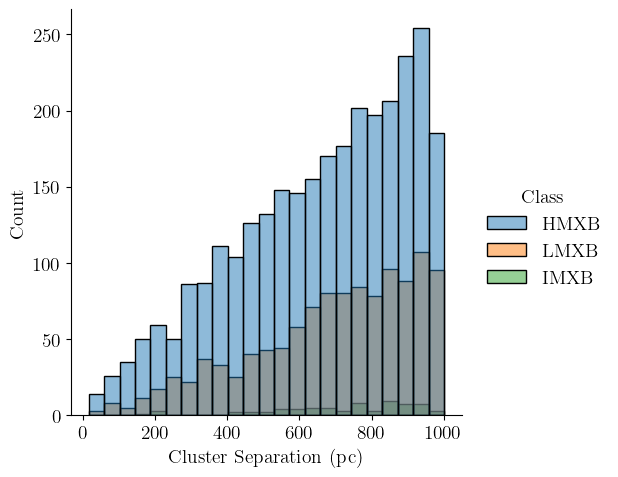

In [20]:
sns.displot(
    data=distances,
    x='Cluster Separation (pc)',
    kind='hist',
    hue='Class',
    legend=True
)
plt.show()

## Distance Plots

In [21]:
def make_plots(df, x, hue='Class', savefile=False, xlabel="Separation (pc)", bins=10):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

    sns.kdeplot(
        data=df,
        x=x,
        fill=True, 
        ax=ax[0], 
        alpha=0.5,
        hue=hue,
        palette='bright'
    )
    ax[0].set(xlabel=None)
    sns.histplot(
        data=df,
        bins=bins,
        x=x,
        hue=hue,
        legend=True,
        # kind='hist',
        palette='bright',
        alpha=0.5,
        ax=ax[1]
    )
    ax[1].set(xlabel=None)

    # ax[1].hist(x=velocity['Cluster Separation (pc)'].values, bins=30)
    # ax[1].set_ylabel('Counts')

    fig.supxlabel(xlabel, x=0.5, y=0.05)
    plt.tight_layout()
    if savefile:
        plt.savefig(M66_dir+'M66_XRB_ejection_compact_association_cat_separation.png')
    plt.show()

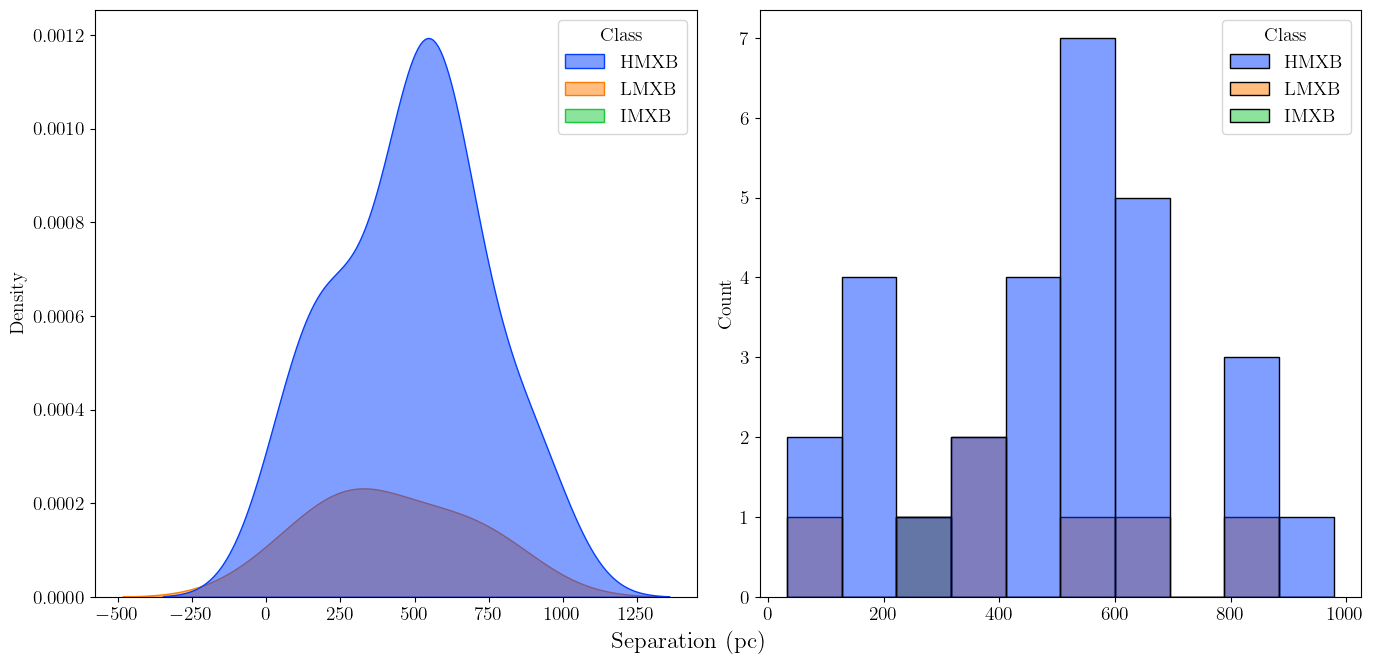

In [22]:
make_plots(df=xrb_parent, x='Cluster Separation (pc)')

## Velocity Plots

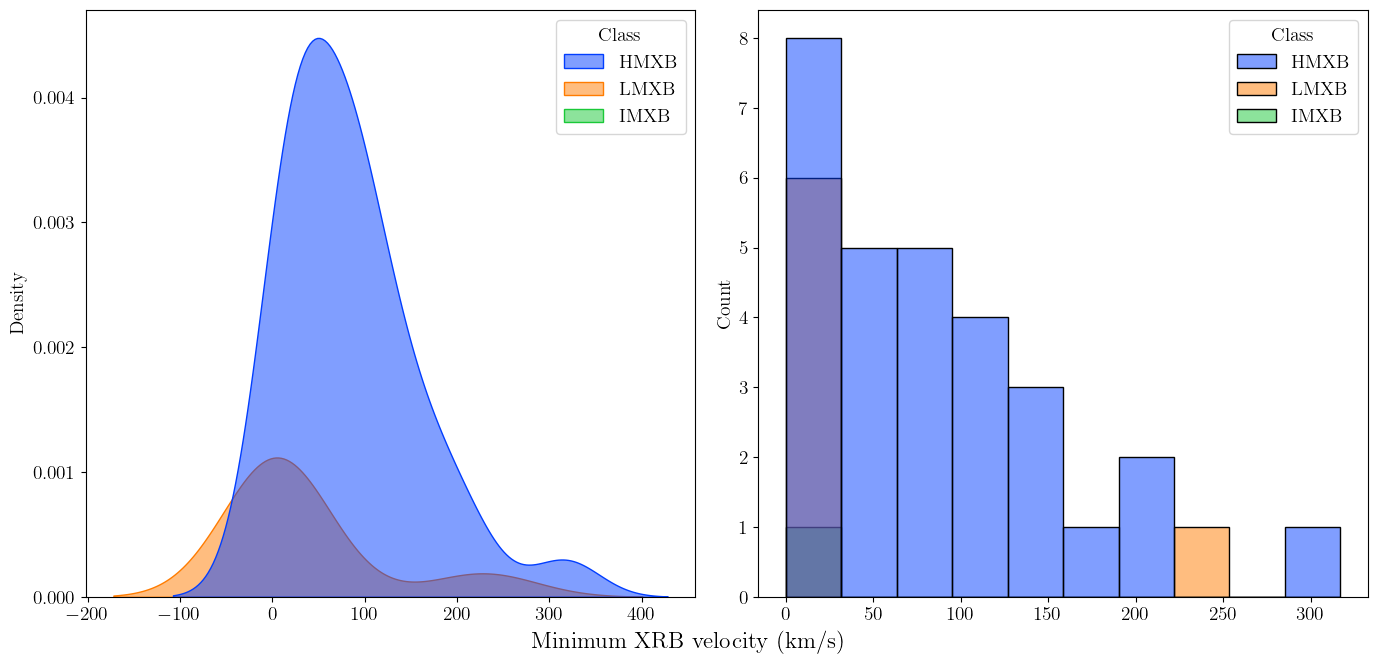

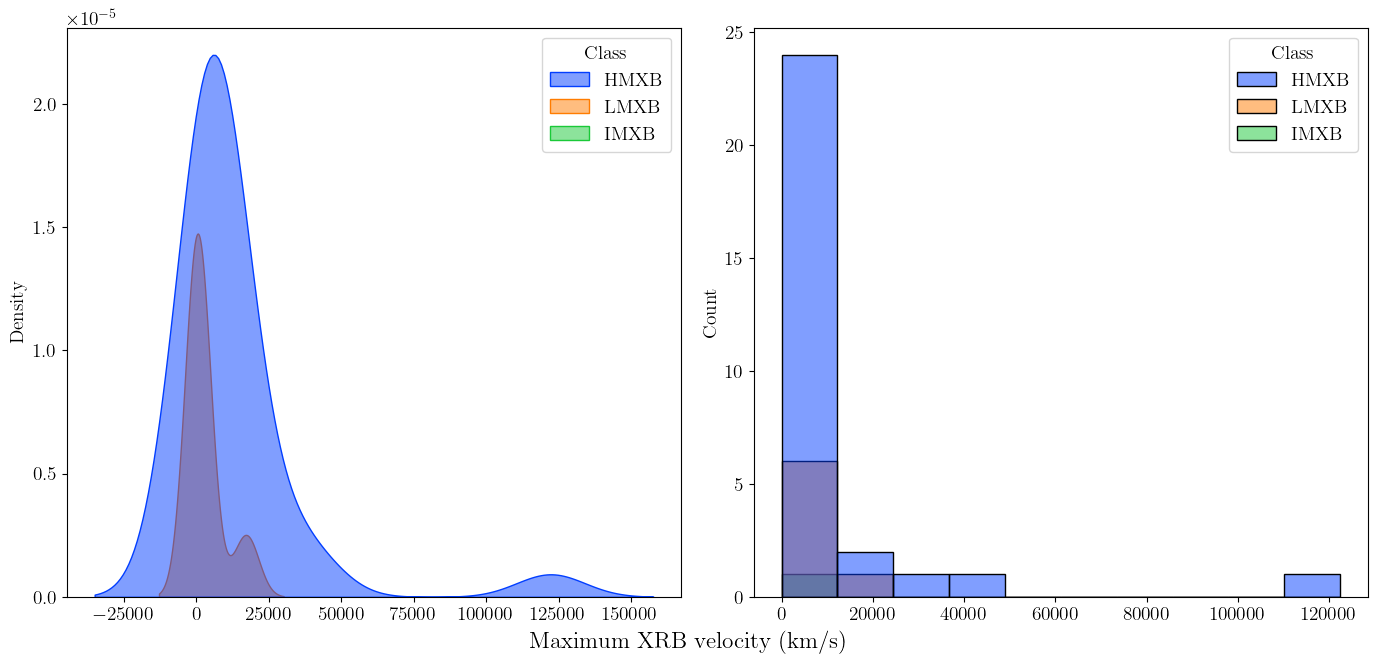

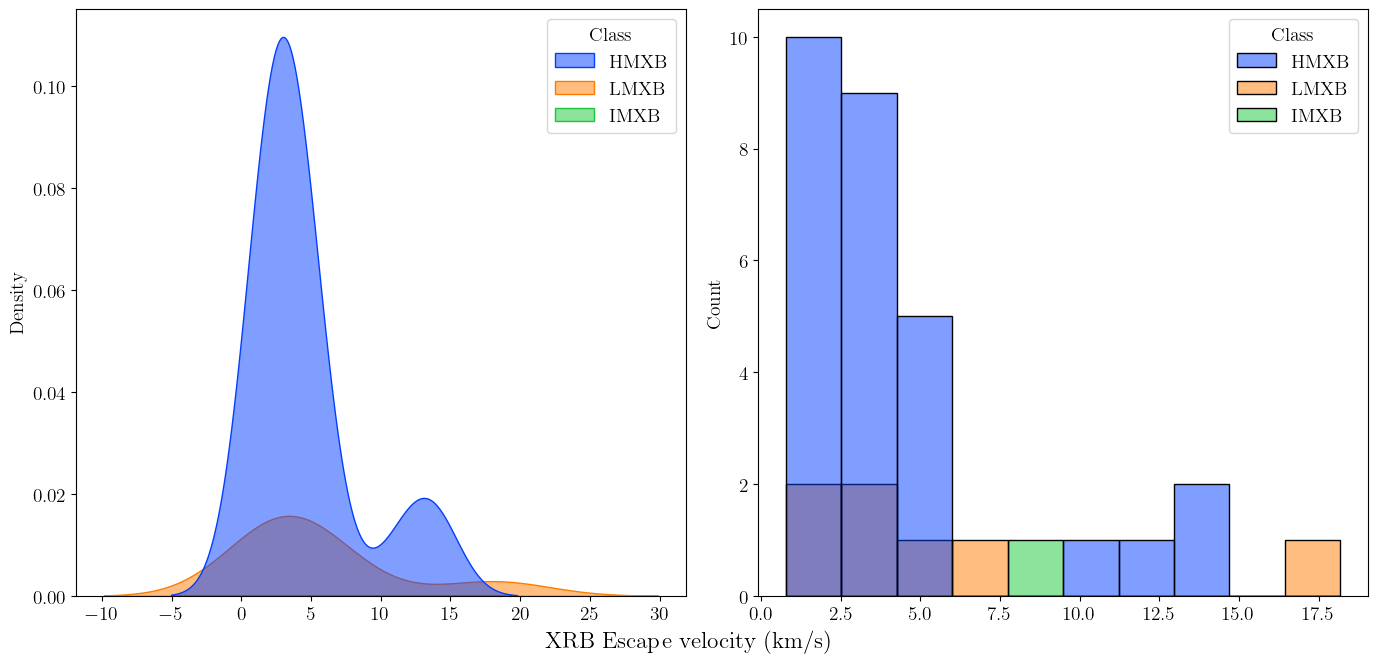

In [23]:
make_plots(
    df=velocity,
    x='Minimum XRB Velocity (km/s)',
    # bins=10,
    xlabel='Minimum XRB velocity (km/s)'
)
make_plots(
    df=velocity,
    x='Maximum XRB Velocity (km/s)',
    # bins=10,
    xlabel='Maximum XRB velocity (km/s)'
)
make_plots(
    df=velocity,
    x='Cluster Escape Velocity (km/s)',
    # bins=10,
    xlabel='XRB Escape velocity (km/s)'
)

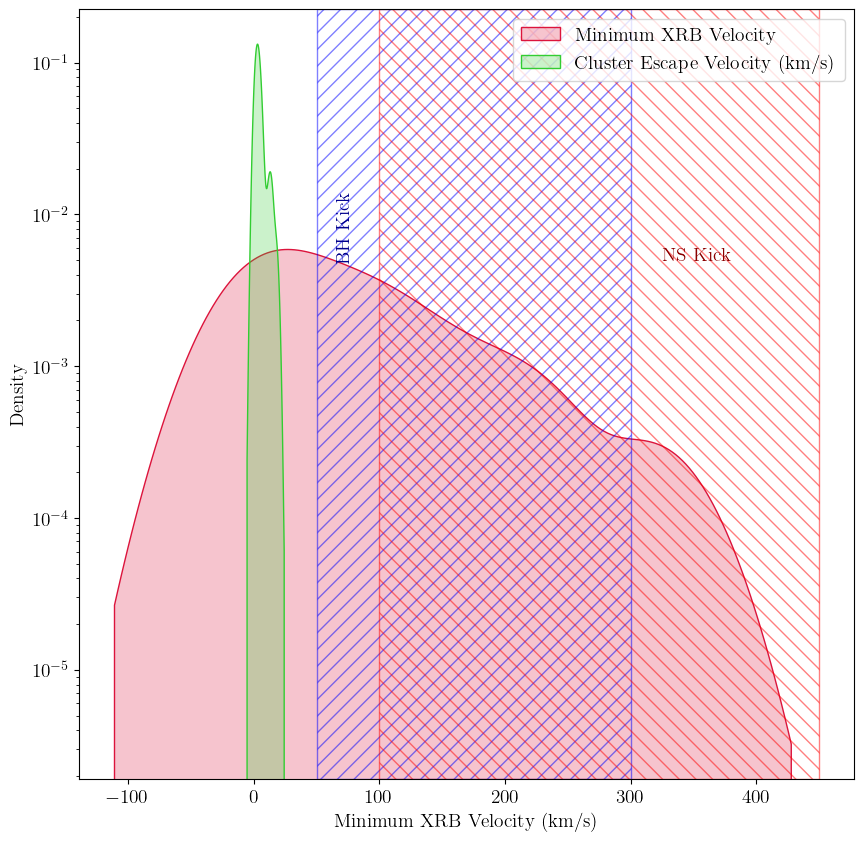

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(
    data=velocity, 
    x='Minimum XRB Velocity (km/s)',
    ax=ax,
    color='crimson',
    # hue='Class',
    label='Minimum XRB Velocity',
    fill=True
)
sns.kdeplot(
    data=velocity,
    x='Cluster Escape Velocity (km/s)',
    label='Cluster Escape Velocity (km/s)',
    color='limegreen',
    fill=True,
    ax=ax
)
# plt.axvspan(median, 2*median, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.annotate("BH Kick", (65, 0.005), color="darkblue", rotation=90)
plt.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
plt.annotate("NS Kick", (325,0.005), color="darkred",)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()

Text(325, 0.005, 'NS Kick')

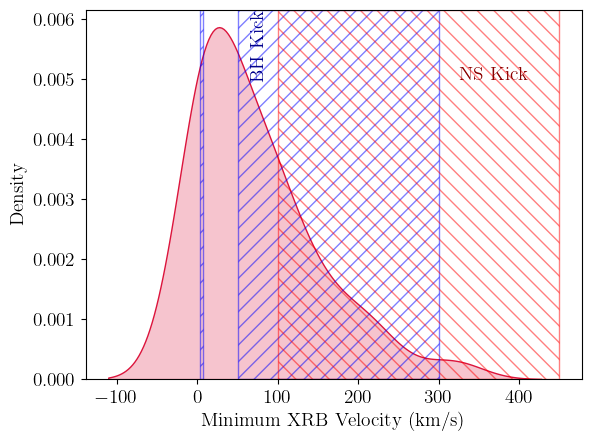

In [27]:
sns.kdeplot(
    data=velocity, 
    x='Minimum XRB Velocity (km/s)',
    color='crimson',
    label='Minimum XRB Velocity',
    fill=True
)
plt.axvspan(median, 2*median, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.annotate("BH Kick", (65, 0.005), color="darkblue", rotation=90)
plt.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
plt.annotate("NS Kick", (325,0.005), color="darkred",)


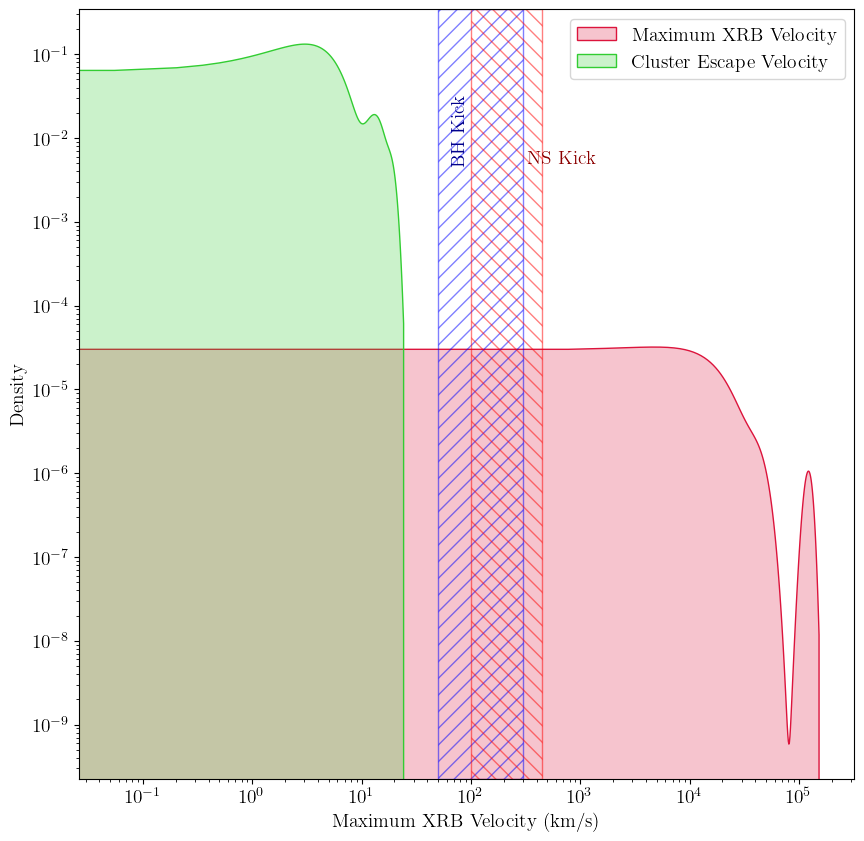

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(
    data=velocity, 
    x='Maximum XRB Velocity (km/s)',
    ax=ax,
    color='crimson',
    label='Maximum XRB Velocity',
    fill=True
)

sns.kdeplot(
    data=velocity, 
    x='Cluster Escape Velocity (km/s)',
    ax=ax,
    color='limegreen',
    label='Cluster Escape Velocity',
    fill=True
)
plt.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.annotate("BH Kick", (65, 0.005), color="darkblue", rotation=90)
plt.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
plt.annotate("NS Kick", (325,0.005), color="darkred",)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [26]:
median = np.nanmedian(velocity['Cluster Escape Velocity (km/s)'])
median

np.float64(3.5868521582121646)

Text(325, 0.005, 'NS Kick')

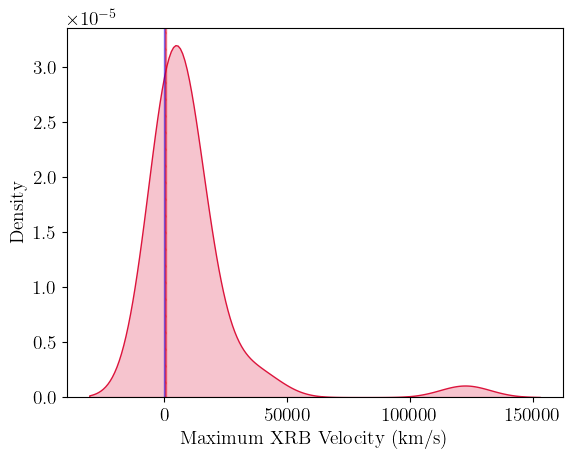

In [28]:
sns.kdeplot(
    data=velocity, 
    x='Maximum XRB Velocity (km/s)',
    color='crimson',
    label='Minimum XRB Velocity',
    fill=True
)
plt.axvspan(median, 2*median, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.annotate("BH Kick", (65, 0.005), color="darkblue", rotation=90)
plt.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
plt.annotate("NS Kick", (325,0.005), color="darkred",)


## XRB Lx vs Distance

In [29]:
M66_best = pd.read_csv(chandra_hst_dir+'M66_csc_bestrads.frame')

In [30]:
distances = distances.merge(M66_best[['CSC ID', 'LogLx']], on='CSC ID', how='left')

In [31]:
velocity = velocity.merge(M66_best[['CSC ID', 'LogLx']], on='CSC ID', how='left')

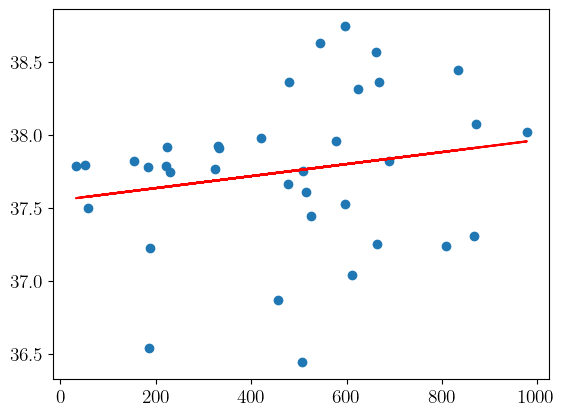

In [32]:
# Perform linear regression
from scipy import stats
x = np.delete(velocity['Cluster Separation (pc)'].values, 30)
y = np.delete(velocity['LogLx'].values, 30)
res = stats.linregress(np.nan_to_num(x), np.nan_to_num(y))
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

In [33]:
# temp = velocity.drop(30)
# temp.to_csv('/Users/undergradstudent/Downloads/temp.csv')

In [34]:
velocity

CSC ID      ID Class Cluster ID  \
0   2CXO J112014.9+125933  CXO003  HMXB     7359.0   
1   2CXO J112015.0+125936  CXO006  HMXB     8032.0   
2   2CXO J112015.0+125921  CXO007  HMXB     7359.0   
3   2CXO J112015.2+125921  CXO008  HMXB     7359.0   
4   2CXO J112014.7+125937  CXO009  HMXB     7359.0   
5   2CXO J112015.0+125938  CXO010  HMXB     8004.0   
6   2CXO J112014.2+125927  CXO011  LMXB     7720.0   
7   2CXO J112014.1+125923  CXO012  LMXB     7066.0   
8   2CXO J112014.3+125918  CXO013  LMXB     7020.0   
9   2CXO J112015.3+125944  CXO014  IMXB     8073.0   
10  2CXO J112015.8+125910  CXO016  HMXB     6381.0   
11  2CXO J112013.9+125913  CXO017  HMXB     7251.0   
12  2CXO J112013.4+125928  CXO018  HMXB     6269.0   
13  2CXO J112015.5+125955  CXO020  HMXB     8032.0   
14  2CXO J112015.8+125904  CXO021  LMXB     5345.0   
15  2CXO J112012.8+125947  CXO022  HMXB     8368.0   
16  2CXO J112012.6+125947  CXO023  HMXB     7827.0   
17  2CXO J112016.8+125959  CXO024  HMXB     8501.0   
18  2CXO J112017.1+130003  CXO026  HMXB     9088.0   
19  2CXO J112012.2+125952  CXO027  HMXB     8627.0   
20  2CXO J112012.0+125910  CXO028  HMXB     6798.0   
21  2CXO J112015.8+130019  CXO030  HMXB     9398.0   
22  2CXO J112016.6+125844  CXO031  HMXB     4070.0   
23  2CXO J112018.2+125959  CXO032  HMXB     8019.0   
24  2CXO J112018.8+125924  CXO035  HMXB     7406.0   
25  2CXO J112013.7+130025  CXO036  HMXB     9598.0   
26  2CXO J112012.3+125846  CXO037  HMXB     5857.0   
27  2CXO J112017.3+130019  CXO039  LMXB     9948.0   
28  2CXO J112017.1+130025  CXO043  LMXB     9453.0   
29  2CXO J112016.7+125830  CXO044  HMXB     3724.0   
30  2CXO J112016.4+130034  CXO045  LMXB    10243.0   
31  2CXO J112019.5+125958  CXO047  HMXB     8028.0   
32  2CXO J112017.5+125818  CXO050  HMXB     2918.0   
33  2CXO J112019.0+130027  CXO051  HMXB     9555.0   
34  2CXO J112011.8+125811  CXO052  HMXB     2612.0   
35  2CXO J112019.7+130030  CXO053  HMXB     9555.0   
36  2CXO J112013.0+125736  CXO060  HMXB     1183.0   

                              Notes      CSC RA    CSC Dec  \
0                               NaN  170.062259  12.992633   
1        7359 is also a good parent  170.062785  12.993429   
2                               NaN  170.062538  12.989251   
3                               NaN  170.063419  12.989393   
4                               NaN  170.061339  12.993597   
5                               NaN  170.062887  12.993977   
6                               NaN  170.059380  12.990875   
7                               NaN  170.058772  12.989771   
8                               NaN  170.059709  12.988377   
9                               NaN  170.064028  12.995589   
10                              NaN  170.065983  12.986237   
11                              NaN  170.058048  12.986939   
12                              NaN  170.055921  12.991105   
13                              NaN  170.064793  12.998581   
14                              NaN  170.065903  12.984421   
15                              NaN  170.053614  12.996594   
16                              NaN  170.052527  12.996542   
17                              NaN  170.070149  12.999835   
18                              NaN  170.071585  13.000886   
19                              NaN  170.050873  12.997819   
20                              NaN  170.050187  12.986338   
21                              NaN  170.066003  13.005280   
22                              NaN  170.069365  12.978872   
23                              NaN  170.075880  12.999774   
24                              NaN  170.078512  12.990211   
25                              NaN  170.057330  13.006947   
26                              NaN  170.051250  12.979514   
27                              NaN  170.072362  13.005469   
28                              NaN  170.071464  13.007172   
29                              NaN  170.069903  12.975028   
30                              NaN  170.068

<Axes: xlabel='Cluster Separation (pc)', ylabel='LogLx'>

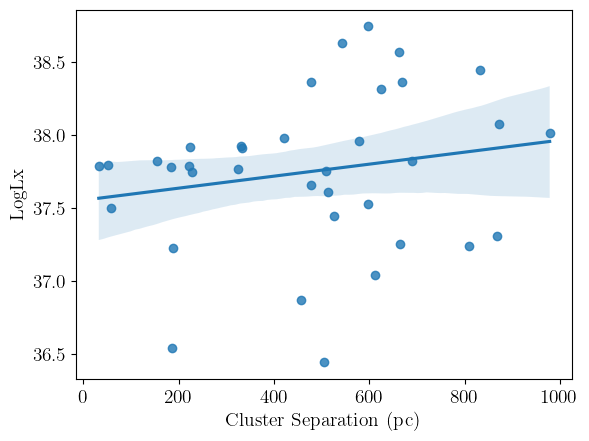

In [35]:
temp = velocity.drop(30)
sns.regplot(
    data=temp, 
    x="Cluster Separation (pc)", 
    y="LogLx",
    # hue='Class'
)

<Axes: xlabel='Cluster Separation (pc)', ylabel='LogLx'>

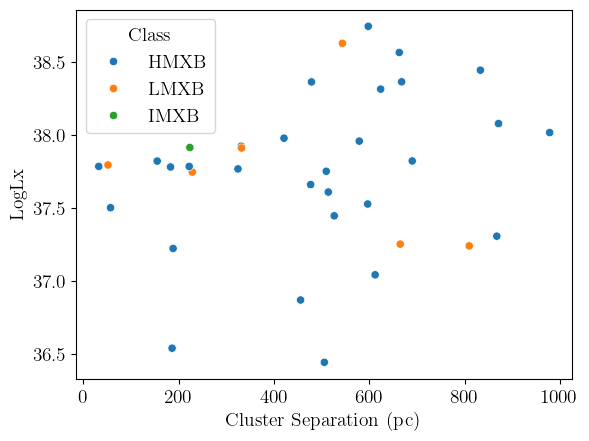

In [36]:
sns.scatterplot(
    data=velocity, 
    x="Cluster Separation (pc)", 
    y="LogLx",
    hue='Class'
)

# Perform linear regression after removing the -inf point in y
# from scipy import stats
# x = np.delete(velocity['Cluster Separation (pc)'].values, 30)
# y = np.delete(velocity['LogLx'].values, 30)
# res = stats.linregress(np.nan_to_num(x), np.nan_to_num(y))
# plt.scatter(x, y)
# plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

## XRB Lx vs Velocity

<Axes: xlabel='Minimum XRB Velocity (km/s)', ylabel='LogLx'>

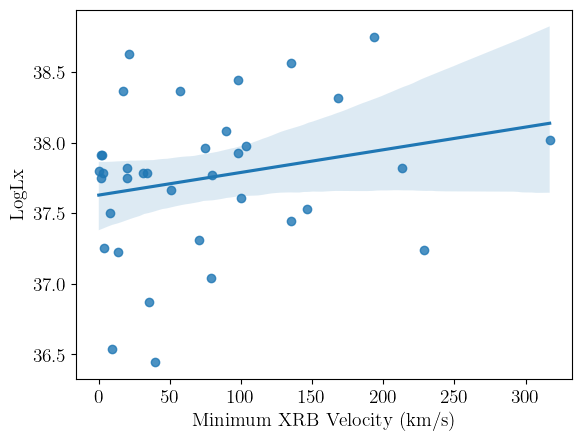

In [37]:
sns.regplot(
    data=temp, 
    x="Minimum XRB Velocity (km/s)", 
    y="LogLx",
)

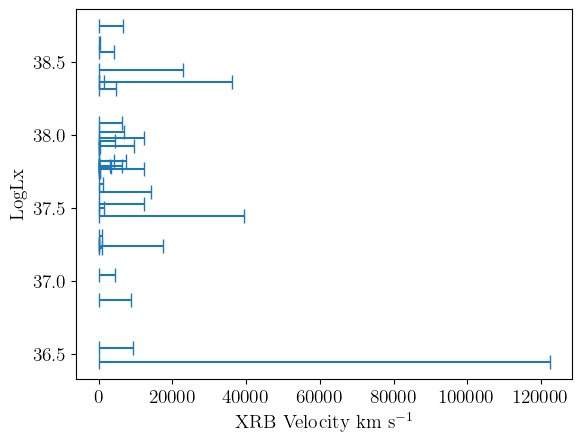

In [38]:
x = temp['Minimum XRB Velocity (km/s)'].values
y = temp['LogLx'].values
xerr = np.array([temp['Minimum XRB Velocity (km/s)'], temp['Maximum XRB Velocity (km/s)']])
fig, ax = plt.subplots()
ax.errorbar(x, y, fmt='none', xerr=xerr, capsize=5)
ax.set_xlabel(r'XRB Velocity km s$^{-1}$')
ax.set_ylabel('LogLx')
plt.show()

Text(0, 0.5, 'LogLx')

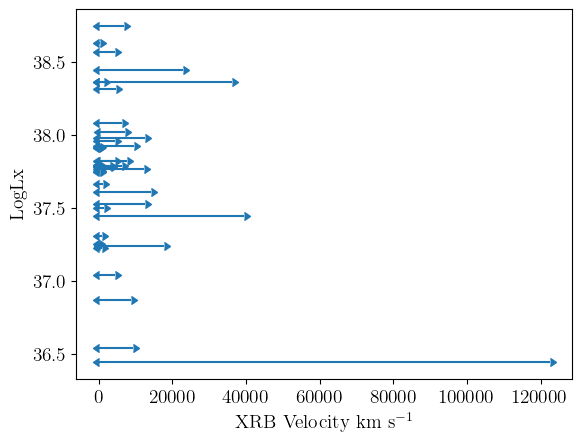

In [39]:
x = temp['Minimum XRB Velocity (km/s)']
y = temp['LogLx'].values
xerr = np.array([temp['Minimum XRB Velocity (km/s)'], temp['Maximum XRB Velocity (km/s)']])
# plt.errorbar(x, y, xerr=xerr, fmt='o', xlolims=True, xuplims=True)
plt.errorbar(x + x, y, xerr=xerr[0], fmt='none', xuplims=True)
plt.errorbar(x + x, y, xerr=xerr[1], fmt='none', xlolims=True)
plt.xlabel(r'XRB Velocity km s$^{-1}$')
plt.ylabel('LogLx')

## XRB Donor star age vs Cluster age

(-20.0, 450.0)

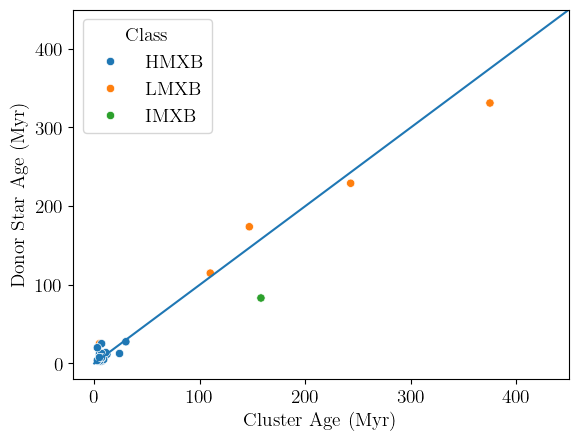

In [40]:
sns.scatterplot(
    data=velocity,
    x='Cluster Age (Myr)',
    y='Stellar Age (Myr)',
    hue='Class'
)

x = np.linspace(0, 500)
y = x
plt.plot(x, y)
plt.ylabel('Donor Star Age (Myr)')
plt.xlim(-20, 450)
plt.ylim(-20, 450)

Text(0, 0.5, 'Donor Star Age (Myr)')

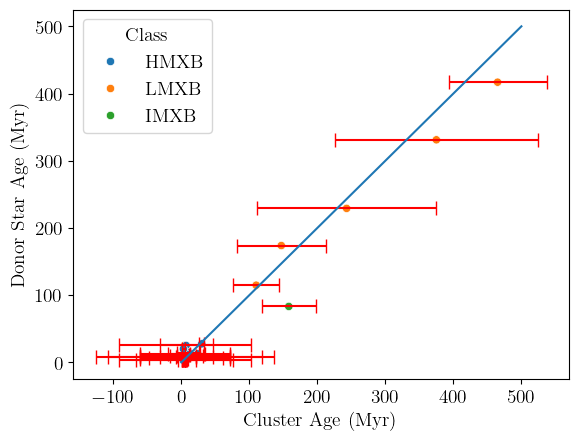

In [41]:
sns.scatterplot(
    data=velocity,
    x='Cluster Age (Myr)',
    y='Stellar Age (Myr)',
    hue='Class'
)
plt.errorbar(x=velocity['Cluster Age (Myr)'], 
            y=velocity['Stellar Age (Myr)'], 
            xerr=velocity['Cluster Age Err (Myr)'], 
            fmt='none', 
            ecolor='red', 
            capsize=5,
            zorder=1)
x = np.linspace(0, 500)
y = x
plt.plot(x, y)
plt.ylabel('Donor Star Age (Myr)')
# plt.xlim(-20, 450)
# plt.ylim(-20, 450)

## Stellar Age vs Cluster Age

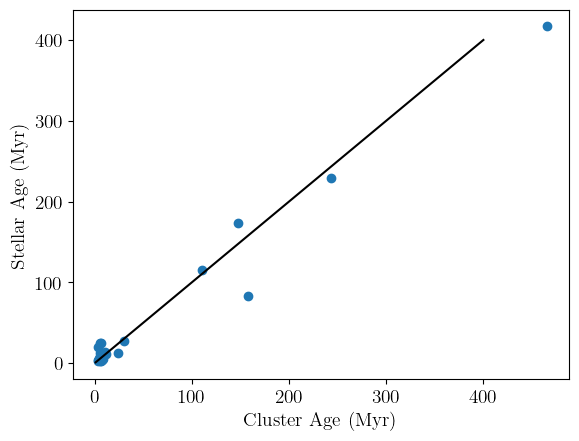

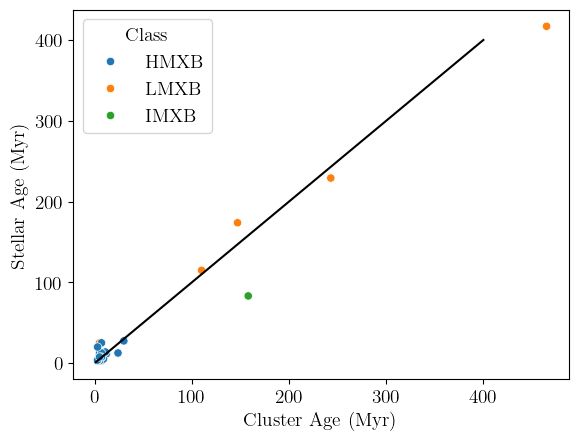

In [42]:
x = temp['Cluster Age (Myr)'].values
xerr = temp['Cluster Age Err (Myr)']
y = temp['Stellar Age (Myr)'].values
plt.scatter(x, y, marker='o')
# plt.errorbar(x, y, xerr=xerr, fmt='o', markersize=2, alpha=0.5)
plt.ylabel("Stellar Age (Myr)")
plt.xlabel('Cluster Age (Myr)')
x = np.linspace(1, 400)
y = x
plt.plot(x, y, c='k')

plt.show()

sns.scatterplot(
    data=temp, 
    x='Cluster Age (Myr)',
    y='Stellar Age (Myr)',
    hue='Class'
)
x = np.linspace(1, 400)
y = x
plt.plot(x, y, c='k')
# sns.move_legend(ax, "upper right")

## M/R vs Velocity

In [43]:
mass = velocity['Cluster Mass (M_sun)'].values
radius = velocity['Cluster half-mass Radius (pc)'].values 

# y measurements
ratio = mass / radius
y_err = velocity['Cluster Mass Err (M_sun)'].values

# x measurements
vel = velocity['Minimum XRB Velocity (km/s)'].values
# xerr = 

# plt.xlabel('Velocity (km/s)')
# plt.ylabel(r'$\frac{M}{R}(M_{\odot} pc^{-1})$')
# plt.errorbar(vel, ratio, fmt='o', 
#              yerr=y_err,
#              xerr=xerr
# )

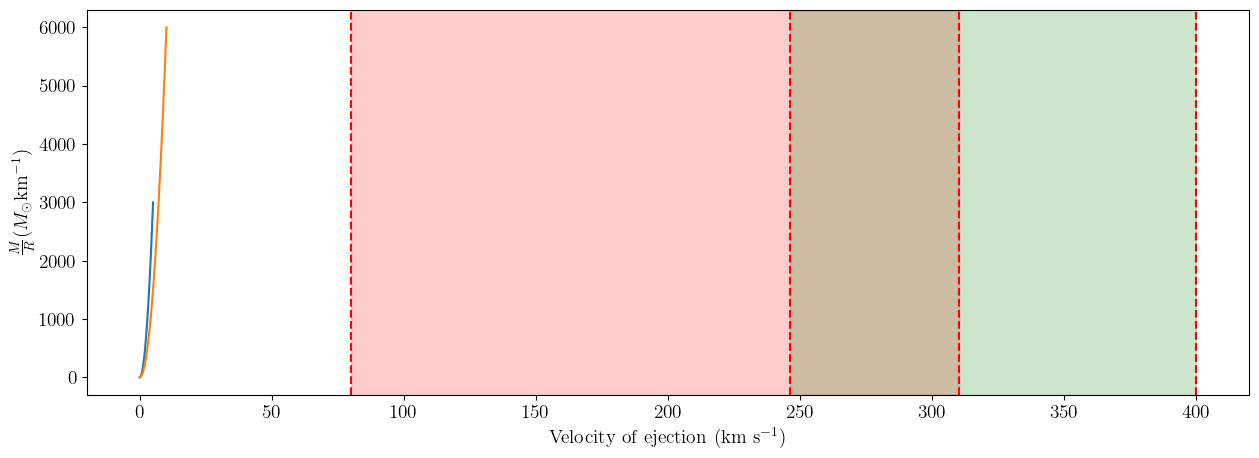

In [44]:
from astropy.constants import G

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel('Velocity of ejection (km s$^{-1}$)')
ax.set_ylabel(r'$\frac{M}{R} (M_{\odot}$km$^{-1})$')

G = 4.302e-3 # pc Msun^(-1) (km/s)^2
y = np.arange(0, 3000, 1)
x = np.sqrt(2 * G * y)
plt.plot(x, y)
plt.plot(2 * x, 2 * y)

# BHXB ejection velocities
plt.axvline(x=80, color='r', linestyle='--')
plt.axvline(x=310, color='r', linestyle='--')
ax.axvspan(80, 310, color='red', alpha=0.2)

# NSXB ejection velocities
plt.axvline(x=246, color='r', linestyle='--')
plt.axvline(x=400, color='r', linestyle='--')
ax.axvspan(246, 400, color='green', alpha=0.2)

# ax.set_ylim((0e6, 0.75e6))
plt.show()


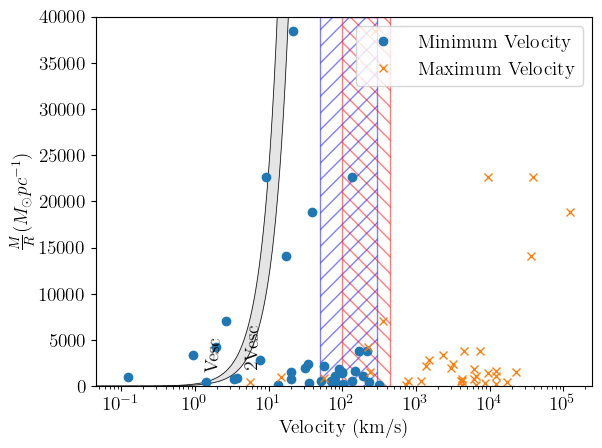

In [45]:
G = 4.302e-3 # pc Msun^(-1) (km/s)^2
y = np.arange(0, 40000, 1)
x = np.sqrt(2 * G * y)
y2 = 2 * y

plt.plot(x, y, color='black', lw=.5)
plt.plot(x, y2, color='black', lw=.5)
plt.fill_between(x, y, y2, alpha=0.2, color='gray')
plt.annotate(r'Vesc', (1.3, 1700), rotation=85)
plt.annotate(r'2Vesc', (4.6, 2000), rotation=88)

plt.xscale('log')
plt.axvspan(50, 300, alpha=0.5, edgecolor='blue', facecolor='none', hatch='//')
plt.axvspan(100, 450, alpha=0.5, edgecolor='red', facecolor='none', hatch='\\\\')
# plt.xlim(0.11, 1000)
plt.ylim(0, 40000)

plt.errorbar(velocity['Minimum XRB Velocity (km/s)'], ratio, fmt='o', label='Minimum Velocity')
plt.errorbar(velocity['Maximum XRB Velocity (km/s)'], ratio, fmt='x', label='Maximum Velocity')

plt.xlabel('Velocity (km/s)')
plt.ylabel(r'$\frac{M}{R} (M_{\odot} pc^{-1})$')
plt.legend()

In [46]:
velocity.columns

Index(['CSC ID', 'ID', 'Class', 'Cluster ID', 'Notes', 'CSC RA', 'CSC Dec',
       'Auxiliary ID', 'JWST ID', 'HST ID', 'JWST RA', 'JWST Dec', 'F2000W ID',
       'F3000M ID', 'F3350M ID', 'F3600M ID', 'JWST X', 'JWST Y', 'HST X',
       'HST Y', 'F555W ID', 'F275W ID', 'F336W ID', 'F438W ID', 'F814W ID',
       'HST RA', 'HST Dec', 'F2000W', 'F2000W Err', 'F3000M', 'F3000M Err',
       'F3350M', 'F3350M Err', 'F3600M', 'F3600M Err', 'F275W', 'F275W Err',
       'F438W', 'F438W Err', 'F555W', 'F555W Err', 'F814W', 'F814W Err',
       'logAge', 'Star Mass (Myr)', 'SED Test Statistic', 'Stellar Age (Myr)',
       '2 Sig (arcsec)', '2 Sig (pix)', 'Cluster RA', 'Cluster Dec',
       'Cluster Separation (arcsecs)', 'Cluster Separation (pc)',
       'Cluster Separation (km)', 'Cluster CI', 'Cluster Age (Myr)',
       'Cluster Age Err (Myr)', 'Cluster Mass (M_sun)',
       'Cluster Mass Err (M_sun)', 'Cluster EBV', 'Cluster EBV Err',
       'Cluster Test Statistic', 'Cluster FWHM', 'Cluster R

(0.0, 3000.0)

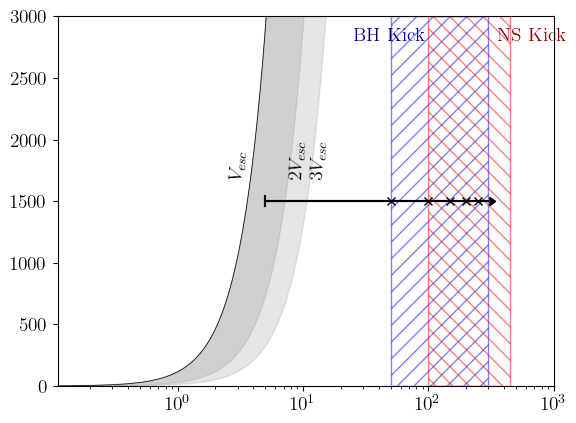

In [47]:
G_astro = 4.302e-3
x = np.linspace(0,50,500)
y = x**2 / (2*G_astro)
y2 = (x/2)**2 / (2*G_astro) # 2vesc
y3 = (x/3)**2 / (2*G_astro) # 3vesc

plt.plot(x,y, color="black", lw=.5)
# plt.plot(x,y2, color="black", lw=.5)
plt.fill_between(x, y, y2, alpha=0.2, color="grey")
plt.fill_between(x, y, y3, alpha=0.2, color="grey")
#plt.fill_between(x, y, y4, alpha=0.2, color="grey")
plt.annotate(r"$V_{esc}$", (2.5,1700), rotation=85)
plt.annotate(r"2$V_{esc}$", (7.5,1700), rotation=88)
plt.annotate(r"3$V_{esc}$", (11,1700), rotation=88)

plt.xscale("log")
plt.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.annotate("BH Kick", (25,2800), color="darkblue")
plt.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
plt.annotate("NS Kick", (350,2800), color="darkred")

# Simulating different ejection points
plt.plot(50,1500, marker="x", color="black")
plt.plot(100,1500, marker="x", color="black")
plt.plot(150,1500, marker="x", color="black")
plt.plot(200,1500, marker="x", color="black")
plt.plot(250,1500, marker="x", color="black")
plt.errorbar(5,1500,xerr=300,yerr=50,xlolims=50,color="black")
plt.errorbar(5, 1500, xerr=300, yerr=50, xlolims=True, color="black")

plt.xlim(0.11,1000)
plt.ylim(0,3000)

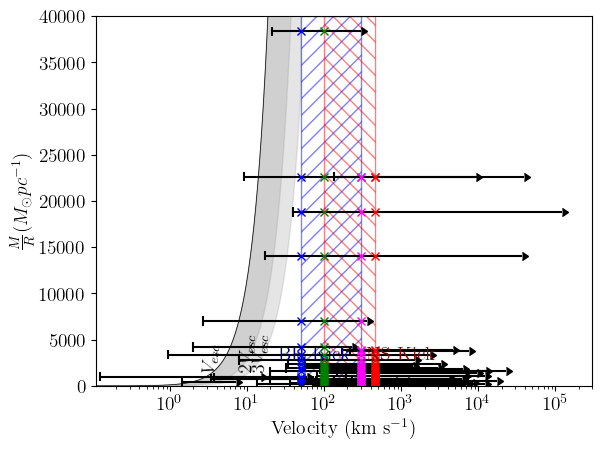

In [48]:
G_astro = 4.302e-3
x = np.linspace(0,50,500)
y = x**2 / (2*G_astro)
y2 = (x/2)**2 / (2*G_astro) # 2vesc
y3 = (x/3)**2 / (2*G_astro) # 3vesc

plt.plot(x,y, color="black", lw=.5)
plt.fill_between(x, y, y2, alpha=0.2, color="grey")
plt.fill_between(x, y, y3, alpha=0.2, color="grey")
plt.annotate(r"$V_{esc}$", (2.5,1700), rotation=85)
plt.annotate(r"2$V_{esc}$", (7.5,1700), rotation=88)
plt.annotate(r"3$V_{esc}$", (11,1700), rotation=88)

plt.xscale("log")
plt.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.annotate("BH Kick", (25,2800), color="darkblue")
plt.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
plt.annotate("NS Kick", (350,2800), color="darkred")

plt.errorbar(velocity['Minimum XRB Velocity (km/s)'], ratio, fmt='none',
             yerr=500, xerr=velocity['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='black')
plt.xlim(0.11, 300000)
plt.ylim(0, 40000)
plt.xlabel("Velocity (km s$^{-1}$)")
plt.ylabel(r'$\frac{M}{R} (M_{\odot} pc^{-1})$')

for index, row in velocity.iterrows():
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 50 and velocity['Maximum XRB Velocity (km/s)'][index] >= 50:
        plt.plot(50, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='blue', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 100 and velocity['Maximum XRB Velocity (km/s)'][index] >= 100:
        plt.plot(100, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='green', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 300 and velocity['Maximum XRB Velocity (km/s)'][index] >= 300:
        plt.plot(300, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='magenta', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 450 and velocity['Maximum XRB Velocity (km/s)'][index] >= 450:
        plt.plot(450, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='red', marker='x')

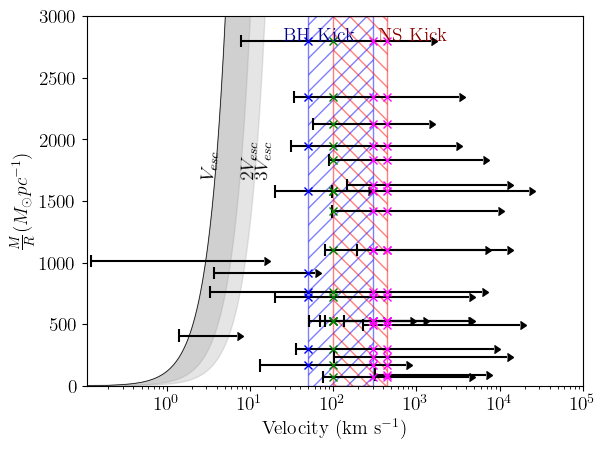

In [49]:
G_astro = 4.302e-3
x = np.linspace(0,50,500)
y = x**2 / (2*G_astro)
y2 = (x/2)**2 / (2*G_astro) # 2vesc
y3 = (x/3)**2 / (2*G_astro) # 3vesc

plt.plot(x,y, color="black", lw=.5)
plt.fill_between(x, y, y2, alpha=0.2, color="grey")
plt.fill_between(x, y, y3, alpha=0.2, color="grey")
plt.annotate(r"$V_{esc}$", (2.5,1700), rotation=85)
plt.annotate(r"2$V_{esc}$", (7.5,1700), rotation=88)
plt.annotate(r"3$V_{esc}$", (11,1700), rotation=88)

plt.xscale("log")
plt.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
plt.annotate("BH Kick", (25,2800), color="darkblue")
plt.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
plt.annotate("NS Kick", (350,2800), color="darkred")

plt.errorbar(velocity['Minimum XRB Velocity (km/s)'], ratio, fmt='none',
             yerr=50, xerr=velocity['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='black')
plt.xlim(0.11, 100000)
plt.ylim(0, 3000)
plt.xlabel("Velocity (km s$^{-1}$)")
plt.ylabel(r'$\frac{M}{R} (M_{\odot} pc^{-1})$')

for index, row in velocity.iterrows():
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 50 and velocity['Maximum XRB Velocity (km/s)'][index] >= 50:
        plt.plot(50, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='blue', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 100 and velocity['Maximum XRB Velocity (km/s)'][index] >= 100:
        plt.plot(100, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='green', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 300 and velocity['Maximum XRB Velocity (km/s)'][index] >= 300:
        plt.plot(300, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='magenta', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 450 and velocity['Maximum XRB Velocity (km/s)'][index] >= 450:
        plt.plot(450, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='magenta', marker='x')

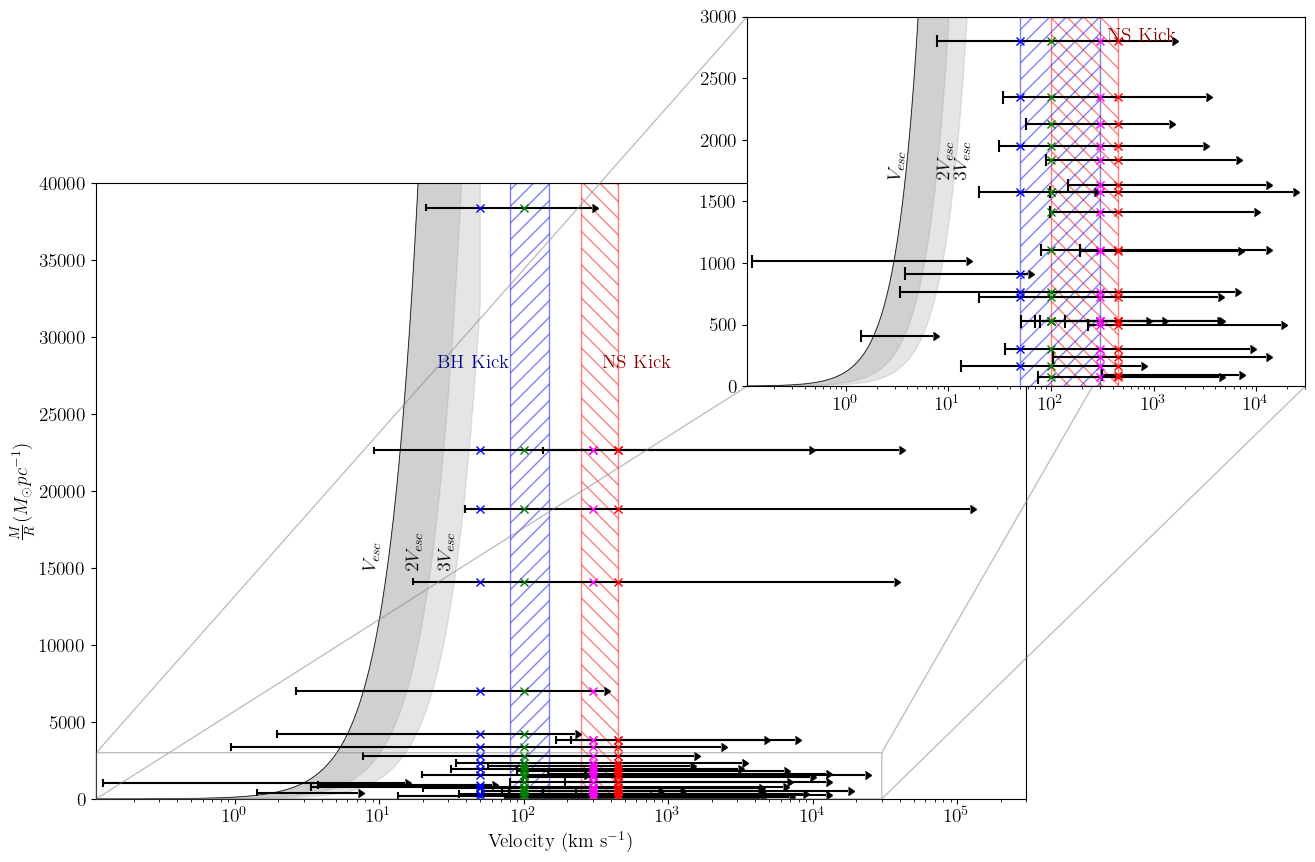

In [80]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

G_astro = 4.302e-3
x = np.linspace(0,50,500)
y = x**2 / (2*G_astro)
y2 = (x/2)**2 / (2*G_astro) # 2vesc
y3 = (x/3)**2 / (2*G_astro) # 3vesc

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x,y, color="black", lw=.5)
ax.fill_between(x, y, y2, alpha=0.2, color="grey")
ax.fill_between(x, y, y3, alpha=0.2, color="grey")
ax.annotate(r"$V_{esc}$", (7.5,15000), rotation=85)
ax.annotate(r"2$V_{esc}$", (15,15000), rotation=88)
ax.annotate(r"3$V_{esc}$", (25,15000), rotation=88)

ax.set_xscale("log")
ax.axvspan(80,150, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
ax.annotate("BH Kick", (25,28000), color="darkblue")
ax.axvspan(250,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
ax.annotate("NS Kick", (350,28000), color="darkred")

ax.errorbar(velocity['Minimum XRB Velocity (km/s)'], ratio, fmt='none',
             yerr=250, xerr=velocity['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='black')
ax.set_xlim(0.11, 300000)
ax.set_ylim(0, 40000)
ax.set_xlabel("Velocity (km s$^{-1}$)")
ax.set_ylabel(r'$\frac{M}{R} (M_{\odot} pc^{-1})$')

for index, row in velocity.iterrows():
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 50 and velocity['Maximum XRB Velocity (km/s)'][index] >= 50:
        ax.plot(50, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='blue', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 100 and velocity['Maximum XRB Velocity (km/s)'][index] >= 100:
        ax.plot(100, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='green', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 300 and velocity['Maximum XRB Velocity (km/s)'][index] >= 300:
        ax.plot(300, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='magenta', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 450 and velocity['Maximum XRB Velocity (km/s)'][index] >= 450:
        ax.plot(450, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='red', marker='x')

x1, x2, y1, y2 = 0.11, 30000, 0, 3000
axins = ax.inset_axes(
    [0.7, 0.67, 0.6, 0.6],
    xlim=(x1, x2), ylim=(y1, y2), #xticklabels=[], yticklabels=[]
)

G_astro = 4.302e-3
x = np.linspace(0,50,500)
y = x**2 / (2*G_astro)
y2 = (x/2)**2 / (2*G_astro) # 2vesc
y3 = (x/3)**2 / (2*G_astro) # 3vesc
axins.plot(x,y, color="black", lw=.5)
axins.fill_between(x, y, y2, alpha=0.2, color="grey")
axins.fill_between(x, y, y3, alpha=0.2, color="grey")
axins.annotate(r"$V_{esc}$", (2.5,1700), rotation=85)
axins.annotate(r"2$V_{esc}$", (7.5,1700), rotation=88)
axins.annotate(r"3$V_{esc}$", (11,1700), rotation=88)

axins.set_xscale('log')
axins.errorbar(velocity['Minimum XRB Velocity (km/s)'], ratio, fmt='none',
             yerr=50, xerr=velocity['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='black')
for index, row in velocity.iterrows():
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 50 and velocity['Maximum XRB Velocity (km/s)'][index] >= 50:
        axins.plot(50, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='blue', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 100 and velocity['Maximum XRB Velocity (km/s)'][index] >= 100:
        axins.plot(100, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='green', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 300 and velocity['Maximum XRB Velocity (km/s)'][index] >= 300:
        axins.plot(300, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='magenta', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 450 and velocity['Maximum XRB Velocity (km/s)'][index] >= 450:
        axins.plot(450, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='red', marker='x')
        
axins.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
# axins.annotate("BH Kick", (25,2800), color="darkblue")
axins.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
axins.annotate("NS Kick", (350,2800), color="darkred")
inset_indicator = ax.indicate_inset_zoom(axins)
inset_indicator.connectors[0].set_visible(True)
inset_indicator.connectors[1].set_visible(True)
inset_indicator.connectors[2].set_visible(True)
inset_indicator.connectors[3].set_visible(True)

plt.savefig('/Users/undergradstudent/Research/XRB-Analysis/Poster/velocity.png', bbox_inches='tight')
plt.show()

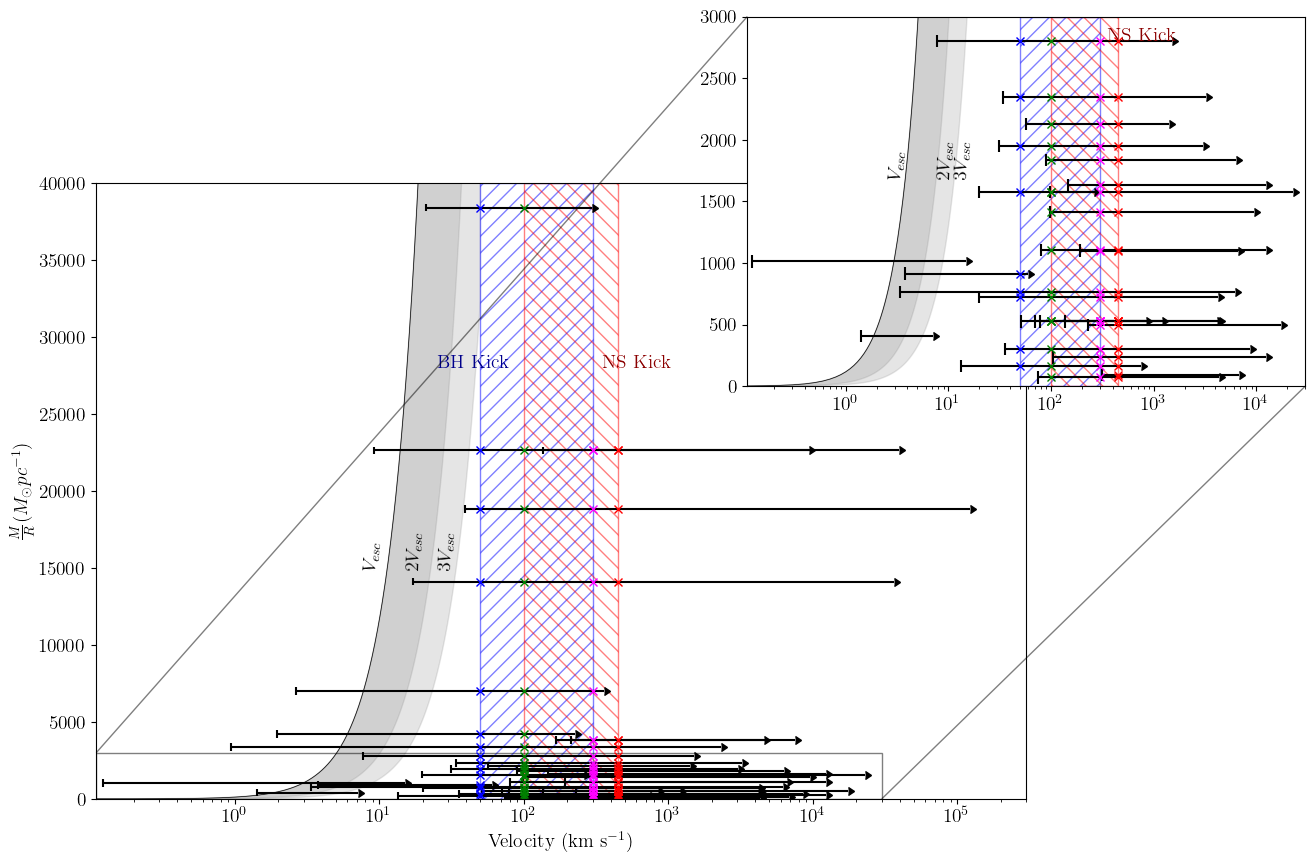

In [51]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

G_astro = 4.302e-3
x = np.linspace(0,50,500)
y = x**2 / (2*G_astro)
y2 = (x/2)**2 / (2*G_astro) # 2vesc
y3 = (x/3)**2 / (2*G_astro) # 3vesc

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x,y, color="black", lw=.5)
ax.fill_between(x, y, y2, alpha=0.2, color="grey")
ax.fill_between(x, y, y3, alpha=0.2, color="grey")
ax.annotate(r"$V_{esc}$", (7.5,15000), rotation=85)
ax.annotate(r"2$V_{esc}$", (15,15000), rotation=88)
ax.annotate(r"3$V_{esc}$", (25,15000), rotation=88)

ax.set_xscale("log")
ax.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
ax.annotate("BH Kick", (25,28000), color="darkblue")
ax.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
ax.annotate("NS Kick", (350,28000), color="darkred")

ax.errorbar(velocity['Minimum XRB Velocity (km/s)'], ratio, fmt='none',
             yerr=250, xerr=velocity['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='black')
ax.set_xlim(0.11, 300000)
ax.set_ylim(0, 40000)
ax.set_xlabel("Velocity (km s$^{-1}$)")
ax.set_ylabel(r'$\frac{M}{R} (M_{\odot} pc^{-1})$')

for index, row in velocity.iterrows():
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 50 and velocity['Maximum XRB Velocity (km/s)'][index] >= 50:
        ax.plot(50, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='blue', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 100 and velocity['Maximum XRB Velocity (km/s)'][index] >= 100:
        ax.plot(100, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='green', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 300 and velocity['Maximum XRB Velocity (km/s)'][index] >= 300:
        ax.plot(300, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='magenta', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 450 and velocity['Maximum XRB Velocity (km/s)'][index] >= 450:
        ax.plot(450, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='red', marker='x')

x1, x2, y1, y2 = 0.11, 30000, 0, 3000
axins = ax.inset_axes(
    [0.7, 0.67, 0.6, 0.6],
    xlim=(x1, x2), ylim=(y1, y2), #xticklabels=[], yticklabels=[]
)

G_astro = 4.302e-3
x = np.linspace(0,50,500)
y = x**2 / (2*G_astro)
y2 = (x/2)**2 / (2*G_astro) # 2vesc
y3 = (x/3)**2 / (2*G_astro) # 3vesc
axins.plot(x,y, color="black", lw=.5)
axins.fill_between(x, y, y2, alpha=0.2, color="grey")
axins.fill_between(x, y, y3, alpha=0.2, color="grey")
axins.annotate(r"$V_{esc}$", (2.5,1700), rotation=85)
axins.annotate(r"2$V_{esc}$", (7.5,1700), rotation=88)
axins.annotate(r"3$V_{esc}$", (11,1700), rotation=88)

axins.set_xscale('log')
axins.errorbar(velocity['Minimum XRB Velocity (km/s)'], ratio, fmt='none',
             yerr=50, xerr=velocity['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='black')
for index, row in velocity.iterrows():
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 50 and velocity['Maximum XRB Velocity (km/s)'][index] >= 50:
        axins.plot(50, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='blue', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 100 and velocity['Maximum XRB Velocity (km/s)'][index] >= 100:
        axins.plot(100, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='green', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 300 and velocity['Maximum XRB Velocity (km/s)'][index] >= 300:
        axins.plot(300, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='magenta', marker='x')
    if velocity['Minimum XRB Velocity (km/s)'][index] <= 450 and velocity['Maximum XRB Velocity (km/s)'][index] >= 450:
        axins.plot(450, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
                 color='red', marker='x')
        
axins.axvspan(50,300, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
# axins.annotate("BH Kick", (25,2800), color="darkblue")
axins.axvspan(100,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
axins.annotate("NS Kick", (350,2800), color="darkred")
# inset_indicator = ax.indicate_inset_zoom(axins)
# inset_indicator.connectors[0].set_visible(True)
# inset_indicator.connectors[1].set_visible(True)
# inset_indicator.connectors[2].set_visible(True)
# inset_indicator.connectors[3].set_visible(True)
mark_inset(ax, axins, loc1=2, loc2=4, alpha=0.5)

plt.show()

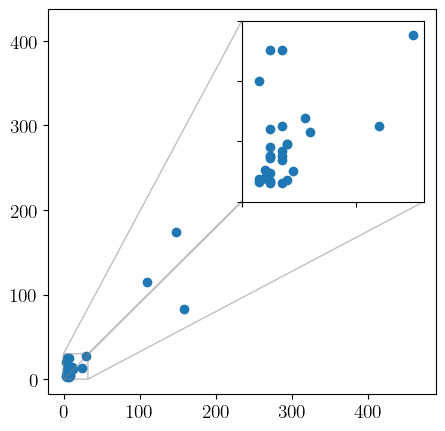

In [52]:
# Plot a zoomed in image in the same figure
x = velocity['Cluster Age (Myr)']
y = velocity['Stellar Age (Myr)']

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x, y)

# Inset Axes
x1, x2, y1, y2 = 0, 32, 0, 30 # subregions of the original image
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[]
)

axins.scatter(x, y)
# Code for making the connector lines
inset_indicator = ax.indicate_inset_zoom(axins)
inset_indicator.connectors[0].set_visible(True)
inset_indicator.connectors[1].set_visible(True)
inset_indicator.connectors[2].set_visible(True)
inset_indicator.connectors[3].set_visible(True)

plt.show()

# Poster plots

These are all the plots/images that are going to be up on my poster:
1. Velocity Plot
2. XRB cluster separation plot

In [53]:
velocity = remove_unnamed(pd.read_csv(M66_dir+"XRB-ejection/M66_velocity.txt"))

In [92]:
hmxbs

CSC ID      ID Class  Cluster ID  \
0   2CXO J112014.9+125933  CXO003  HMXB      7359.0   
1   2CXO J112015.0+125936  CXO006  HMXB      8032.0   
2   2CXO J112015.0+125921  CXO007  HMXB      7359.0   
3   2CXO J112015.2+125921  CXO008  HMXB      7359.0   
4   2CXO J112014.7+125937  CXO009  HMXB      7359.0   
5   2CXO J112015.0+125938  CXO010  HMXB      8004.0   
6   2CXO J112015.8+125910  CXO016  HMXB      6381.0   
7   2CXO J112013.9+125913  CXO017  HMXB      7251.0   
8   2CXO J112013.4+125928  CXO018  HMXB      6269.0   
9   2CXO J112015.5+125955  CXO020  HMXB      8032.0   
10  2CXO J112012.8+125947  CXO022  HMXB      8368.0   
11  2CXO J112012.6+125947  CXO023  HMXB      7827.0   
12  2CXO J112016.8+125959  CXO024  HMXB      8501.0   
13  2CXO J112017.1+130003  CXO026  HMXB      9088.0   
14  2CXO J112012.2+125952  CXO027  HMXB      8627.0   
15  2CXO J112012.0+125910  CXO028  HMXB      6798.0   
16  2CXO J112015.8+130019  CXO030  HMXB      9398.0   
17  2CXO J112016.6+125844  CXO031  HMXB      4070.0   
18  2CXO J112018.2+125959  CXO032  HMXB      8019.0   
19  2CXO J112018.8+125924  CXO035  HMXB      7406.0   
20  2CXO J112013.7+130025  CXO036  HMXB      9598.0   
21  2CXO J112012.3+125846  CXO037  HMXB      5857.0   
22  2CXO J112016.7+125830  CXO044  HMXB      3724.0   
23  2CXO J112019.5+125958  CXO047  HMXB      8028.0   
24  2CXO J112017.5+125818  CXO050  HMXB      2918.0   
25  2CXO J112019.0+130027  CXO051  HMXB      9555.0   
26  2CXO J112011.8+125811  CXO052  HMXB      2612.0   
27  2CXO J112019.7+130030  CXO053  HMXB      9555.0   
28  2CXO J112013.0+125736  CXO060  HMXB      1183.0   

                              Notes      CSC RA    CSC Dec  \
0                               NaN  170.062259  12.992633   
1        7359 is also a good parent  170.062785  12.993429   
2                               NaN  170.062538  12.989251   
3                               NaN  170.063419  12.989393   
4                               NaN  170.061339  12.993597   
5                               NaN  170.062887  12.993977   
6                               NaN  170.065983  12.986237   
7                               NaN  170.058048  12.986939   
8                               NaN  170.055921  12.991105   
9                               NaN  170.064793  12.998581   
10                              NaN  170.053614  12.996594   
11                              NaN  170.052527  12.996542   
12                              NaN  170.070149  12.999835   
13                              NaN  170.071585  13.000886   
14                              NaN  170.050873  12.997819   
15                              NaN  170.050187  12.986338   
16                              NaN  170.066003  13.005280   
17                              NaN  170.069365  12.978872   
18                              NaN  170.075880  12.999774   
19                              NaN  170.078512  12.990211   
20                              NaN  170.057330  13.006947   
21                              NaN  170.051250  12.979514   
22                              NaN  170.069903  12.975028   
23                              NaN  170.081516  12.999423   
24                              NaN  170.072942  12.971853   
25   Phangs age bad but my age good  170.079541  13.007541   
26                              NaN  170.049536  12.969903   
27                              NaN  170.082346  13.008354   
28                              NaN  170.054213  12.960156   

                      Auxiliary ID  JWST ID  HST ID     JWST RA   JWST Dec  \
0    2CXO J112014.9+125933-3.0-2.0      3.0     2.0  170.062307  12.992623   
1    2CXO J112015.0+125936-2.0-1.0      2.0     1.0  170.062808  12.993437   
2    2CXO J112015.0+125921-7.0-1.0      7.0     1.0  170.062475  12.989191   
3    2CXO J112015.2+125921-7.0-3.0      7.0     3.0  170.063489  12.989460   
4    2CXO J112014.7+125937-7.0-1.0      7.0     1.0  170.061275  12.993558   
5    2CXO J112015.0+125938-6.0-1.0     

In [94]:
hmxbs = Find(velocity, 'Class == HMXB')
hmxb_ratio = hmxbs['Cluster Mass (M_sun)'] / hmxbs['Cluster half-mass Radius (pc)']
lmxbs = Find(velocity, 'Class == LMXB')
lmxb_ratio = lmxbs['Cluster Mass (M_sun)'] / lmxbs['Cluster half-mass Radius (pc)']
imxbs = Find(velocity, 'Class == IMXB')
imxb_ratio = imxbs['Cluster Mass (M_sun)'] / imxbs['Cluster half-mass Radius (pc)']

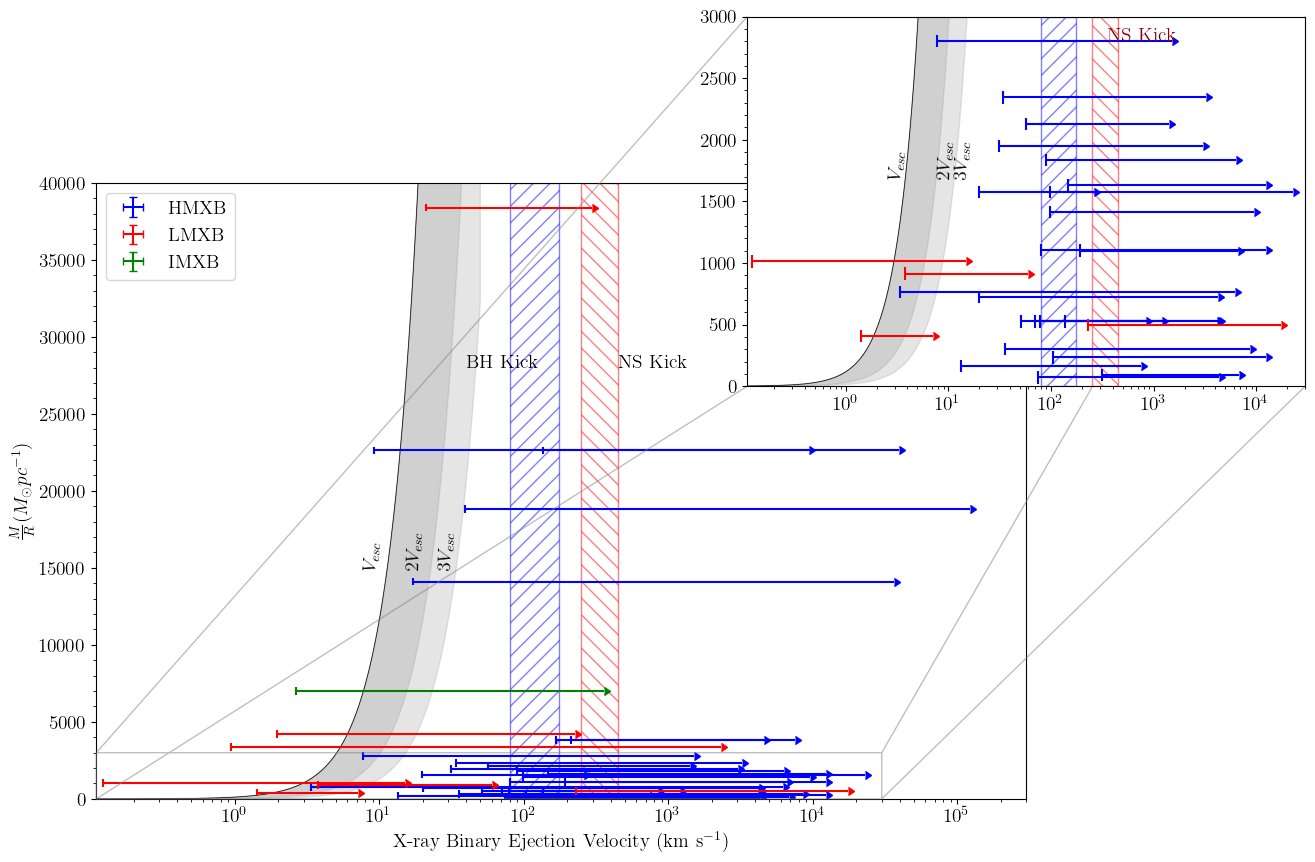

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.ticker as tck

G_astro = 4.302e-3
x = np.linspace(0,50,500)
y = x**2 / (2*G_astro)
y2 = (x/2)**2 / (2*G_astro) # 2vesc
y3 = (x/3)**2 / (2*G_astro) # 3vesc

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y, color="black", lw=.5)
ax.fill_between(x, y, y2, alpha=0.2, color="grey")
ax.fill_between(x, y, y3, alpha=0.2, color="grey")
ax.annotate(r"$V_{esc}$", (7.5,15000), rotation=85)
ax.annotate(r"2$V_{esc}$", (15,15000), rotation=88)
ax.annotate(r"3$V_{esc}$", (25,15000), rotation=88)

ax.set_xscale("log")
ax.axvspan(80,175, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
ax.annotate("BH Kick", (40,28000), color="black",)
ax.axvspan(250,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
ax.annotate("NS Kick", (450,28000), color="black")

# ax.errorbar(velocity['Minimum XRB Velocity (km/s)'], ratio, fmt='none',
#              yerr=250, xerr=velocity['Maximum XRB Velocity (km/s)'], xlolims=True,
#              color='blue',)
ax.errorbar(hmxbs['Minimum XRB Velocity (km/s)'], hmxb_ratio, fmt='none',
             yerr=250, xerr=hmxbs['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='blue', label='HMXB')
ax.errorbar(lmxbs['Minimum XRB Velocity (km/s)'], lmxb_ratio, fmt='none',
             yerr=250, xerr=lmxbs['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='red', label='LMXB')
ax.errorbar(imxbs['Minimum XRB Velocity (km/s)'], imxb_ratio, fmt='none',
             yerr=250, xerr=imxbs['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='green', label='IMXB')

ax.set_xlim(0.11, 300000)
ax.set_ylim(0, 40000)
ax.set_xlabel("X-ray Binary Ejection Velocity (km s$^{-1}$)")
ax.set_ylabel(r'$\frac{M}{R} (M_{\odot} pc^{-1})$')

# for index, row in velocity.iterrows():
#     if velocity['Minimum XRB Velocity (km/s)'][index] <= 50 and velocity['Maximum XRB Velocity (km/s)'][index] >= 50:
#         ax.plot(50, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
#                  color='blue', marker='x')
#     if velocity['Minimum XRB Velocity (km/s)'][index] <= 100 and velocity['Maximum XRB Velocity (km/s)'][index] >= 100:
#         ax.plot(100, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
#                  color='green', marker='x')
#     if velocity['Minimum XRB Velocity (km/s)'][index] <= 300 and velocity['Maximum XRB Velocity (km/s)'][index] >= 300:
#         ax.plot(300, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
#                  color='magenta', marker='x')
#     if velocity['Minimum XRB Velocity (km/s)'][index] <= 450 and velocity['Maximum XRB Velocity (km/s)'][index] >= 450:
#         ax.plot(450, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
#                  color='red', marker='x')

x1, x2, y1, y2 = 0.11, 30000, 0, 3000
axins = ax.inset_axes(
    [0.7, 0.67, 0.6, 0.6],
    xlim=(x1, x2), ylim=(y1, y2), #xticklabels=[], yticklabels=[]
)

G_astro = 4.302e-3
x = np.linspace(0,50,500)
y = x**2 / (2*G_astro)
y2 = (x/2)**2 / (2*G_astro) # 2vesc
y3 = (x/3)**2 / (2*G_astro) # 3vesc
axins.plot(x,y, color="black", lw=.5)
axins.fill_between(x, y, y2, alpha=0.2, color="grey")
axins.fill_between(x, y, y3, alpha=0.2, color="grey")
axins.annotate(r"$V_{esc}$", (2.5,1700), rotation=85)
axins.annotate(r"2$V_{esc}$", (7.5,1700), rotation=88)
axins.annotate(r"3$V_{esc}$", (11,1700), rotation=88)

axins.set_xscale('log')
# axins.errorbar(velocity['Minimum XRB Velocity (km/s)'], ratio, fmt='none',
#              yerr=50, xerr=velocity['Maximum XRB Velocity (km/s)'], xlolims=True,
#              color='black')
axins.errorbar(hmxbs['Minimum XRB Velocity (km/s)'], hmxb_ratio, fmt='none',
             yerr=50, xerr=hmxbs['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='blue')
axins.errorbar(lmxbs['Minimum XRB Velocity (km/s)'], lmxb_ratio, fmt='none',
             yerr=50, xerr=lmxbs['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='red')
axins.errorbar(imxbs['Minimum XRB Velocity (km/s)'], imxb_ratio, fmt='none',
             yerr=50, xerr=imxbs['Maximum XRB Velocity (km/s)'], xlolims=True,
             color='green')
# for index, row in velocity.iterrows():
#     if velocity['Minimum XRB Velocity (km/s)'][index] <= 50 and velocity['Maximum XRB Velocity (km/s)'][index] >= 50:
#         axins.plot(50, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
#                  color='blue', marker='x')
#     if velocity['Minimum XRB Velocity (km/s)'][index] <= 100 and velocity['Maximum XRB Velocity (km/s)'][index] >= 100:
#         axins.plot(100, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
#                  color='green', marker='x')
#     if velocity['Minimum XRB Velocity (km/s)'][index] <= 300 and velocity['Maximum XRB Velocity (km/s)'][index] >= 300:
#         axins.plot(300, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
#                  color='magenta', marker='x')
#     if velocity['Minimum XRB Velocity (km/s)'][index] <= 450 and velocity['Maximum XRB Velocity (km/s)'][index] >= 450:
#         axins.plot(450, velocity['Cluster Mass (M_sun)'][index]/velocity['Cluster half-mass Radius (pc)'][index],
#                  color='red', marker='x')
        
axins.axvspan(80,175, alpha=0.5, edgecolor='blue', facecolor="none", hatch="//")
# axins.annotate("BH Kick", (25,2800), color="darkblue")
axins.axvspan(250,450, alpha=0.5, edgecolor='red', facecolor="none", hatch="\\\\")
axins.annotate("NS Kick", (350,2800), color="darkred")
inset_indicator = ax.indicate_inset_zoom(axins)
inset_indicator.connectors[0].set_visible(True)
inset_indicator.connectors[1].set_visible(True)
inset_indicator.connectors[2].set_visible(True)
inset_indicator.connectors[3].set_visible(True)

# Figure customizations
axins.yaxis.set_minor_locator(tck.AutoMinorLocator()) 
# axins.spines['right'].set_visible(False)
# axins.grid(alpha=0.4)
ax.yaxis.set_minor_locator(tck.AutoMinorLocator()) # minor ticks in the y-axis
# ax.spines['right'].set_visible(False)
# ax.grid(alpha=0.4)
ax.legend(loc='upper left')
# plt.savefig('/Users/undergradstudent/Research/XRB-Analysis/Poster/velocity.png', bbox_inches='tight')
plt.show()

## Plot a colour image of M66

I do not like the blending of colours that I get with this code so I am abandoning it. 

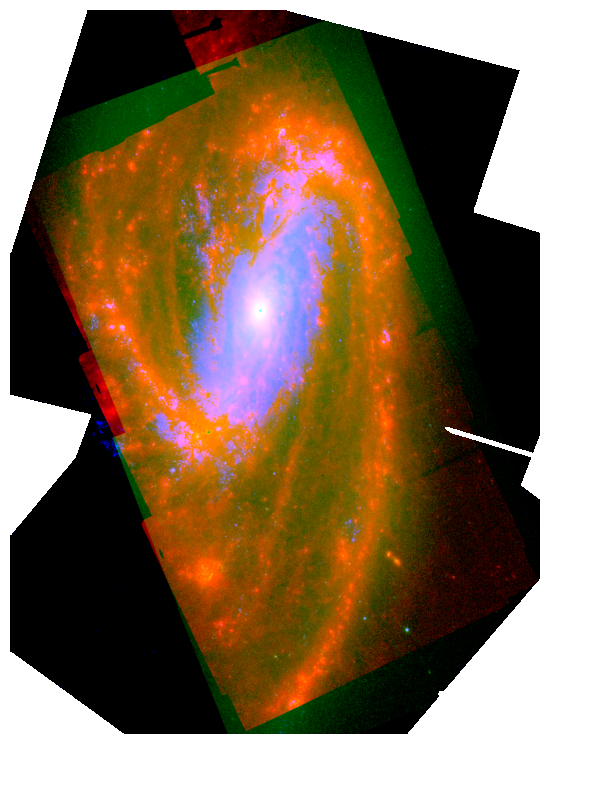

In [56]:
import numpy as np
from reproject import reproject_interp    # May need to install first
from astropy.wcs import WCS

f2100w = jwstdir + "/hlsp_phangs-jwst_jwst_miri_ngc3627_f2100w_v1p1_img.fits"
# Calling FITS files as the RGB filters
hdu_r = fits.open(f2100w)
hdu_g = fits.open(f200w)
hdu_b = fits.open(f555w)
data_g = hdu_g['SCI'].data   # Pulling data from FITS HDU

# Resizing images that don't match the base HDU, hdu_g (required)
if hdu_r['SCI'].data.shape != hdu_g['SCI'].data.shape:
  data_r, _ = reproject_interp(hdu_r['SCI'], hdu_g['SCI'].header)
else: data_r = hdu_r['SCI'].data
if hdu_b['PRIMARY'].data.shape != hdu_g['SCI'].data.shape:
  data_b, _ = reproject_interp(hdu_b['PRIMARY'], hdu_g['SCI'].header)
else: data_b = hdu_b['PRIMARY'].data

# Defining the min and max brightness cutoff of RGB image, per filter
# These are obtained through trial and error.
clipmin_r = 0.2
clipmax_r = 20
clipmin_g = 0.2
clipmax_g = 150
clipmin_b = 0.2
clipmax_b = 0.35

# Applying mag clipping and converting data to log
r = np.log10(np.clip(data_r, clipmin_r, clipmax_r))
g = np.log10(np.clip(data_g, clipmin_g, clipmax_g))
b = np.log10(np.clip(data_b, clipmin_b, clipmax_b))

# Rescaling the filters based on their individual min and max values
r_scaled = (r-np.nanmin(r))/(np.nanmax(r)-np.nanmin(r))
g_scaled = (g-np.nanmin(g))/(np.nanmax(g)-np.nanmin(g))
b_scaled = (b-np.nanmin(b))/(np.nanmax(b)-np.nanmin(b))
rgb_scaled = np.dstack((r_scaled,g_scaled,b_scaled))

# Plotting RGB image
plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=WCS(hdu_g['PRIMARY'].header))
plt.imshow(rgb_scaled)
plt.axis("off")
plt.show()

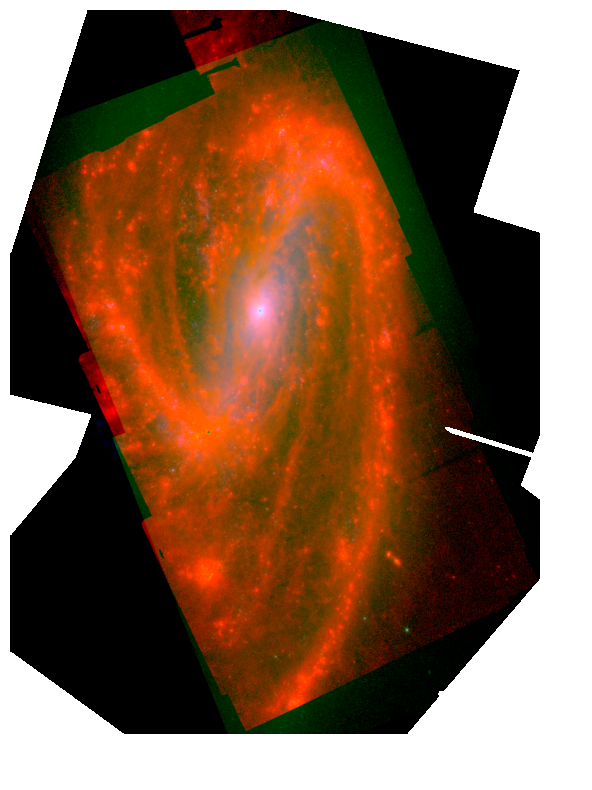

In [129]:
import numpy as np
from reproject import reproject_interp    # May need to install first
from astropy.wcs import WCS

f2100w = jwstdir + "/hlsp_phangs-jwst_jwst_miri_ngc3627_f2100w_v1p1_img.fits"
# Calling FITS files as the RGB filters
hdu_r = fits.open(f2100w)
hdu_g = fits.open(f200w)
hdu_b = fits.open(f555w)
data_g = hdu_g['SCI'].data   # Pulling data from FITS HDU

# Resizing images that don't match the base HDU, hdu_g (required)
if hdu_r['SCI'].data.shape != hdu_g['SCI'].data.shape:
  data_r, _ = reproject_interp(hdu_r['SCI'], hdu_g['SCI'].header)
else: data_r = hdu_r['SCI'].data
if hdu_b['PRIMARY'].data.shape != hdu_g['SCI'].data.shape:
  data_b, _ = reproject_interp(hdu_b['PRIMARY'], hdu_g['SCI'].header)
else: data_b = hdu_b['PRIMARY'].data

# Defining the min and max brightness cutoff of RGB image, per filter
# These are obtained through trial and error.
clipmin_r = 0.2
clipmax_r = 20
clipmin_g = 0.2
clipmax_g = 3000 # 200
clipmin_b = 0.2
clipmax_b = 7

# Applying mag clipping and converting data to log
r = np.log10(np.clip(data_r, clipmin_r, clipmax_r))
g = np.log10(np.clip(data_g, clipmin_g, clipmax_g))
b = np.log10(np.clip(data_b, clipmin_b, clipmax_b))

# Rescaling the filters based on their individual min and max values
r_scaled = (r-np.nanmin(r))/(np.nanmax(r)-np.nanmin(r))
g_scaled = (g-np.nanmin(g))/(np.nanmax(g)-np.nanmin(g))
b_scaled = (b-np.nanmin(b))/(np.nanmax(b)-np.nanmin(b))
rgb_scaled = np.dstack((r_scaled,g_scaled,b_scaled))

# Plotting RGB image
plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=WCS(hdu_g['PRIMARY'].header))
plt.imshow(rgb_scaled)
plt.axis("off")
plt.show()

In [189]:
hdu_r['SCI'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1959                                                  
NAXIS2  =                 2683                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =    59957.50940304213 / [d] exposure start time in MJD                 
MJD-AVG =   59957.547357426745 / [d] exposure mid-point in MJD                  
MJD-END =    59957.58520478009 / [d] exposure end time in MJD                   
TDB-BEG =    59957.51366271431 / [d] TDB time of exposure start in MJD          
TDB-MID =    59957.551620143

In [210]:
data_r

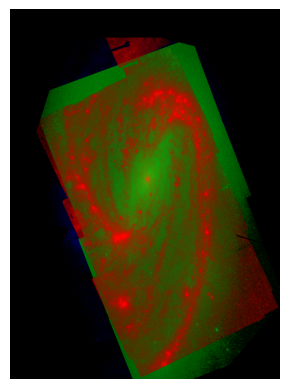

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from reproject import reproject_interp

# Load FITS files (replace with your actual file paths)
# Assuming 'red_image.fits', 'green_image.fits', 'blue_image.fits' are your files
with fits.open(f2100w) as hdul_r:
    data_r = fits.getdata(f2100w)
    wcs_r = WCS(hdul_r[1])

with fits.open(f200w) as hdul_g:
    data_g = fits.getdata(f200w)
    wcs_g = WCS(hdul_g[1])

with fits.open(f555w) as hdul_b:
    data_b = fits.getdata(f555w)
    wcs_b = WCS(hdul_b[0])

# Reproject images to a common WCS (e.g., the WCS of the red image)
# This handles different dimensions and aligns the images
data_g_reprojected, footprint_g = reproject_interp((data_g, wcs_g), wcs_r, shape_out=data_r.shape)
data_b_reprojected, footprint_b = reproject_interp((data_b, wcs_b), wcs_r, shape_out=data_r.shape)

# Create RGB image using make_lupton_rgb (handles scaling and combination)
rgb_image = make_lupton_rgb(data_r, data_g_reprojected, data_b_reprojected, stretch=1, Q=100)

# Display the image
plt.imshow(rgb_image, origin='lower')
plt.axis('off')
plt.show()

In [94]:
# Make regions of XRBs pointing to their parent clusters
velocity = remove_unnamed(pd.read_csv(M66_dir+"XRB-ejection/M66_velocity.txt"))
M66_best = remove_unnamed(pd.read_csv(chandra_hst_dir+"M66_csc_bestrads.frame"))
velocity = velocity.merge(M66_best[['CSC ID', '2Sig']])

# XRB regions
WriteReg(
    sources=velocity,
    outfile=M66_dir+"XRB-ejection/M66_xrbs.reg",
    coordsys='fk5',
    coordheads=['CSC RA', 'CSC Dec'],
    # radius=velocity['2Sig'].tolist(),
    radius=1,
    radunit='arcsec',
    color='green'
)

# Cluster regions
WriteReg(
    sources=velocity,
    outfile=M66_dir+"XRB-ejection/M66_parent_clusters.reg",
    coordsys='fk5',
    coordheads=['Cluster RA', 'Cluster Dec'],
    # radius=velocity['Cluster Radius Eff (arcsec)'].tolist(),
    radius=10,
    marker='diamond',
    radunit=' ',
    color='blue'
)

# Cluster to XRB regions
make_regions(
    sources=velocity,
    outfile=M66_dir+"XRB-ejection/M66_xrb_to_parent_clusters.reg",
    hdu=f555w,
    coordsys='fk5',
    reg_type='vector',
    coordheads=['Cluster RA', 'Cluster Dec'],
    additional_coords=['CSC RA', 'CSC Dec'],
    radius='Cluster Radius Eff (arcsec)',
    radunit='arcsec',
    color='#f3722c'
)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_xrbs.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_xrbs.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_parent_clusters.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_parent_clusters.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_xrb_to_parent_clusters.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/XRB-ejection/M66_xrb_to_parent_clusters.reg saved!


([], [])

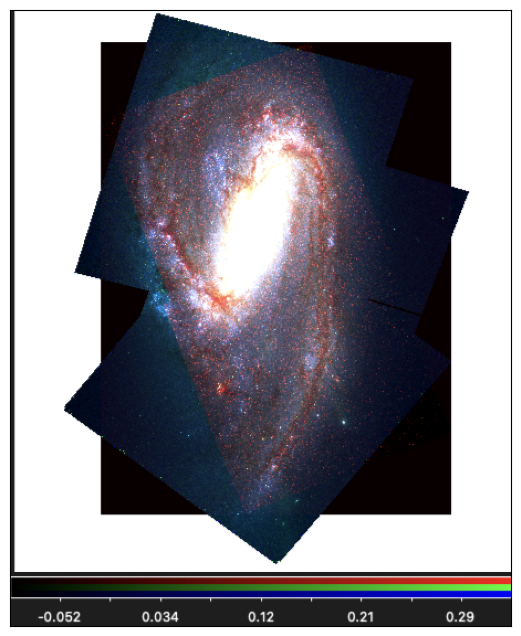

In [102]:
# read M66 image
M66_img = mpimg.imread('/Users/undergradstudent/Downloads/test_image1.png')
plt.figure(figsize=(10, 8))
plt.imshow(M66_img)
plt.yticks([])
plt.xticks([])


([], [])

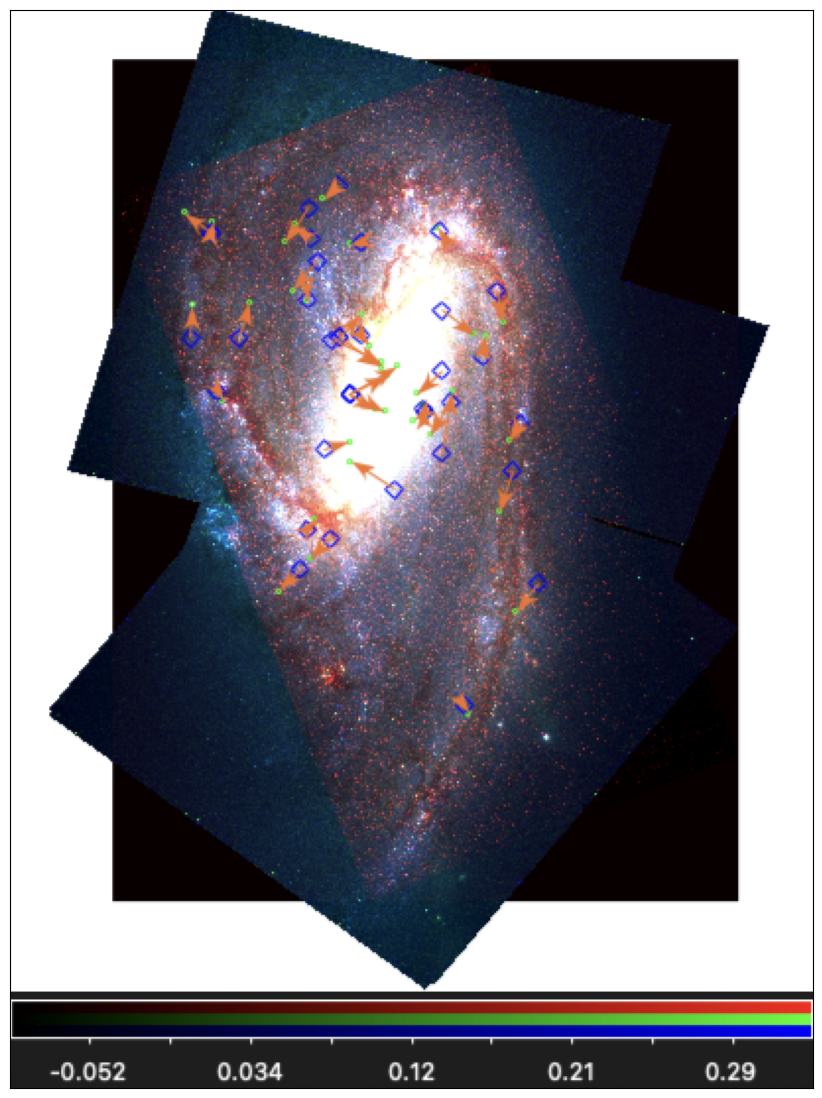

In [104]:
# read M66 image
M66_img = mpimg.imread('/Users/undergradstudent/Downloads/test_image1.png')
plt.figure(figsize=(18, 14))
plt.imshow(M66_img)
plt.yticks([])
plt.xticks([])

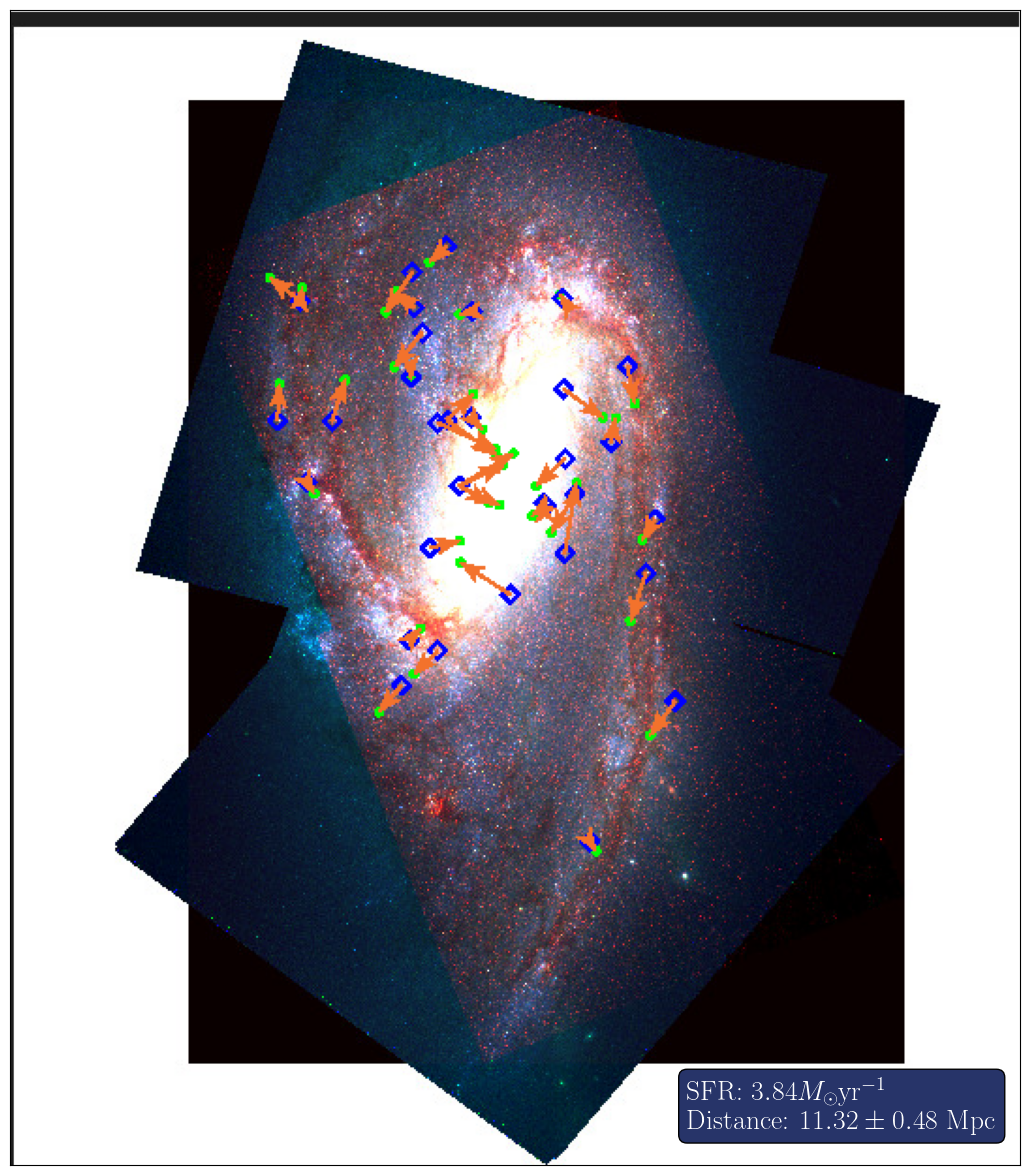

In [179]:
# read M66 image
M66_img = mpimg.imread('/Users/undergradstudent/Downloads/M66_img.png')
plt.figure(figsize=(18, 15))
plt.imshow(M66_img)
plt.yticks([])
plt.xticks([])

# place a text box in upper left in axes coords
textstr = '\n'.join((
    r'SFR: $3.84M_{\odot}$yr$^{-1}$',
    r'Distance: $11.32 \pm 0.48$ Mpc',))
props = dict(boxstyle='round', facecolor='#273469', alpha=1)
# ax.text(50, 50, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
plt.text(360, 595.5, textstr, 
         fontsize=20, color='white',
         bbox=props)
# plt.savefig(M66_dir+'XRB-ejection/M66_poster_image.png')
plt.show()